In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import probplot
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.stats import f_oneway
from datetime import timedelta
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from scipy.stats import shapiro, normaltest
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [21]:
# Função para filtrar as linhas com base na percentagem especificada
def filter_by_percentage(group, random_state=42,**kwargs): # Definir uma semente fixa para reprodução
    p = percentagens.get(group.name.strip(), 0)  # Obter a probabilidade associada
    n = int(np.ceil(len(group) * p))  # Calcular o número de entradas a manter, arredondando para cima
    return group.sample(n, random_state=random_state) if n > 0 else pd.DataFrame()  # Retornar uma amostra aleatória das linhas com semente fixa

# Carregar ficheiros Excel
df_road = pd.read_excel('C:/Users/-adm-local/Desktop/TESE/Dados Porto de Sines (Sofia)/Dados Dezembro/DadosPortoSines(meus).xlsx', sheet_name='Origem_DestinoMercad.Rodovia')
df_rail = pd.read_excel('C:/Users/-adm-local/Desktop/TESE/Dados Porto de Sines (Sofia)/Dados Dezembro/DadosPortoSines(meus).xlsx', sheet_name='Origem_DestinoMercad.Ferrovia.')

df_road['dataMovimentoContentor'] = pd.to_datetime(df_road['dataMovimentoContentor'], format='%d/%m/%Y')
df_rail['OrigemComboio'] = df_rail['OrigemComboio'].str.strip()
df_rail['DestinoComboio'] = df_rail['DestinoComboio'].str.strip()
df_rail['dataChegadaComboio'] = pd.to_datetime(df_rail['dataChegadaComboio'])
df_rail['dataPartidaComboio'] = pd.to_datetime(df_rail['dataPartidaComboio'])

# Criar um intervalo contínuo de datas
start_date = '2021-10-01'
end_date = '2023-06-30'
all_dates = pd.date_range(start=start_date, end=end_date, freq='D')

# Filtrar o dataframe
df_rail_filtered = df_rail[(df_rail['DestinoComboio'].isin(['Terminal XXI', 'T.CMPX.SINES'])) & 
                     (df_rail['OrigemComboio'] == 'Entroncamento')]

#Criar um dicionário para cada destino de contentores
percentagens = {'Louriçal': 0.0, 'Alfarelos': 0.0, 'MEDWAY TERMINAL- Entroncamento': 0.8, 'T.M.G. Terminal Marítima del Guadalquivir, S.L.': 0.0,
                'Medway Terminal de Aveiro':0.0, 'Mérida-Medway': 0.5, 'Terminal IP Leixões':0.0}

# Aplicar a função ao DataFrame agrupado por 'OrigemContentor'
df_rail_final = df_rail_filtered.groupby('OrigemContentor').apply(filter_by_percentage, include_groups=False).reset_index(drop=True)

# Criar um dataframe com todas as datas
df_rail_all_dates = pd.DataFrame(all_dates, columns=['dataChegadaComboio'])
df_road_all_dates = pd.DataFrame({'dataMovimentoContentor': all_dates})
# Juntar o dataframe original com o dataframe de todas as datas
df_road = pd.merge(df_road_all_dates, df_road, on='dataMovimentoContentor', how='left')
df_rail = pd.merge(df_rail_all_dates, df_rail_final, on='dataChegadaComboio', how='left')
# Preencher os valores ausentes com zero
df_road.fillna({'MercadoriaPerigosa': 0, 'QuantidadeCarga': 0, 'QuantidadeDescarga': 0, 'TEUCarga': 0, 'TEUDescarga': 0}, inplace=True)
df_rail_final = df_rail.fillna({'TEU': 0})

# Ajustar o processamento para somar os valores da coluna MercadoriaPerigosa
df_road_final = df_road.groupby('dataMovimentoContentor').agg({
    'MercadoriaPerigosa': 'max',  # Mantém o valor máximo (1 se houver perigosa)
    'QuantidadeCarga': 'sum',    # Soma os valores de carga
    'QuantidadeDescarga': 'sum', # Soma os valores de descarga
    'TEUCarga': 'sum',           # Soma os TEUs de carga
    'TEUDescarga': 'sum'         # Soma os TEUs de descarga
}).reset_index()

# Filtrar os valores para a rota Sines-Madrid (5% da carga total)
df_road_final['QuantidadeCarga'] = (df_road_final['QuantidadeCarga'] * 0.05).round().astype(int)
df_road_final['QuantidadeDescarga'] = (df_road_final['QuantidadeDescarga'] * 0.05).round().astype(int)
df_road_final['TEUCarga'] = (df_road_final['TEUCarga'] * 0.05).round().astype(int)
df_road_final['TEUDescarga'] = (df_road_final['TEUDescarga'] * 0.05).round().astype(int)

# Adicionar colunas de dia da semana, semana do ano e identificador de ano-semana
df_road_final['Dia_da_semana'] = df_road_final['dataMovimentoContentor'].dt.day_name()
df_rail_final['Dia_da_semana'] = df_rail_final['dataChegadaComboio'].dt.day_name()
df_road_final['Semana_do_ano'] = df_road_final['dataMovimentoContentor'].dt.isocalendar().week
df_rail_final['Semana_do_ano'] = df_rail_final['dataChegadaComboio'].dt.isocalendar().week
df_road_final['Ano_Semana'] = df_road_final['dataMovimentoContentor'].dt.strftime('%Y-') + df_road_final['Semana_do_ano'].astype(str)
df_rail_final['Ano_Semana'] = df_rail_final['dataChegadaComboio'].dt.strftime('%Y-') + df_rail_final['Semana_do_ano'].astype(str)

# Guardar os dados finais em ficheiros CSV
df_road_final.to_csv('df_road_final_chegada.csv', index=False)
df_rail_final.to_csv('df_rail_final_chegada.csv', index=False)

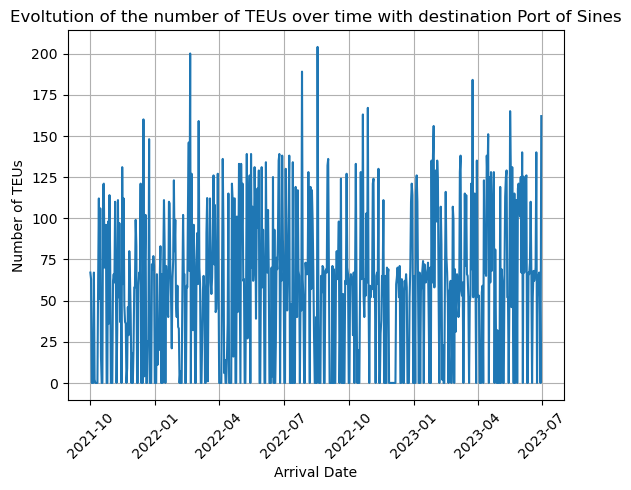

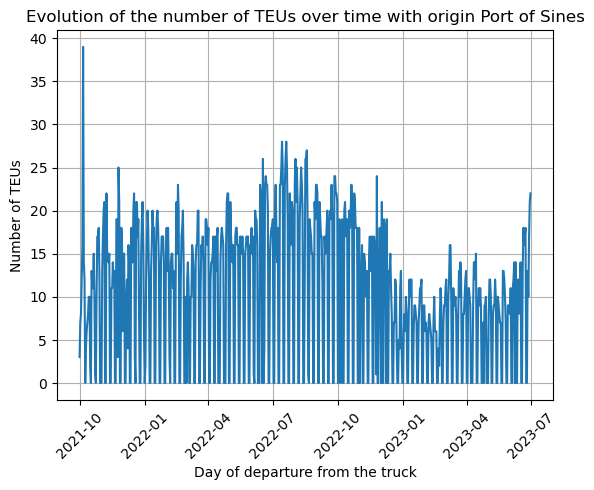

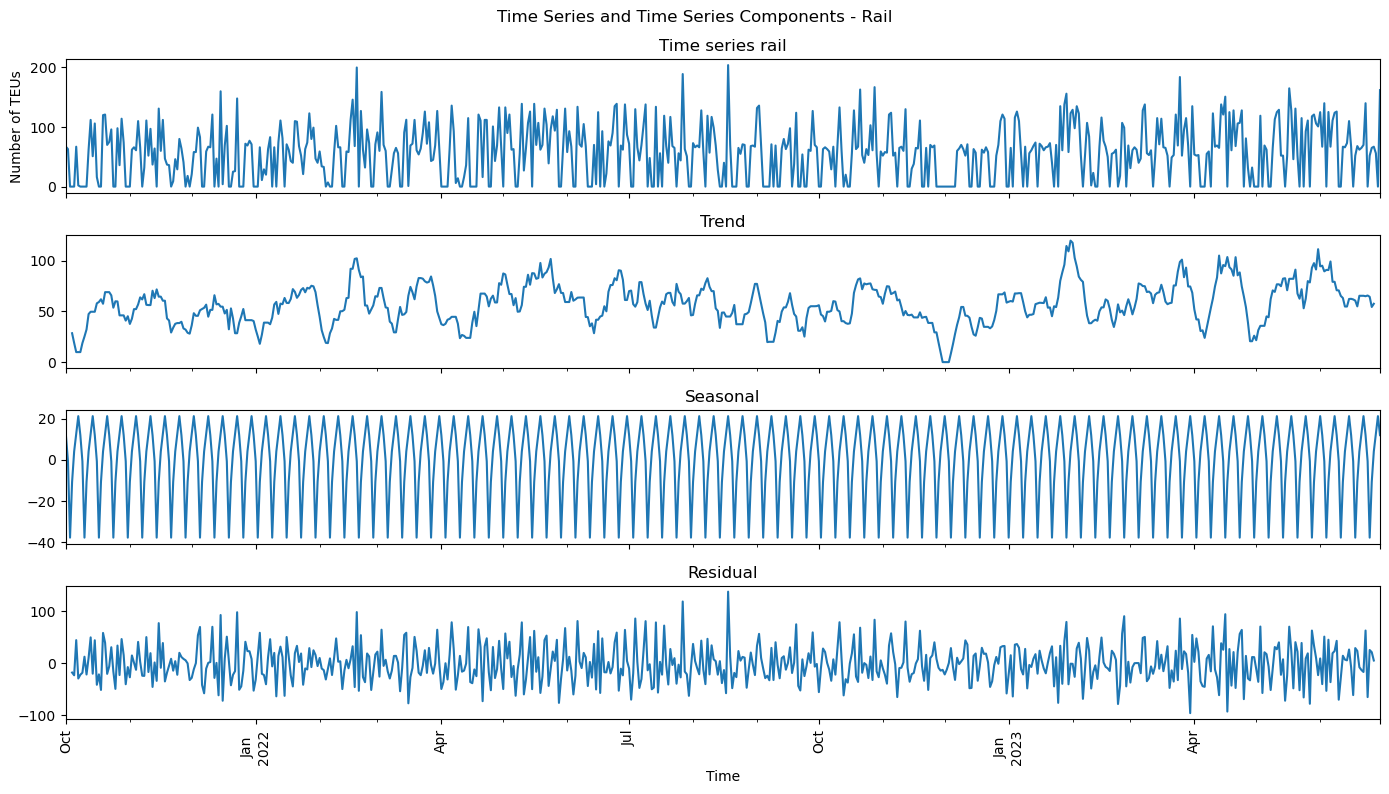

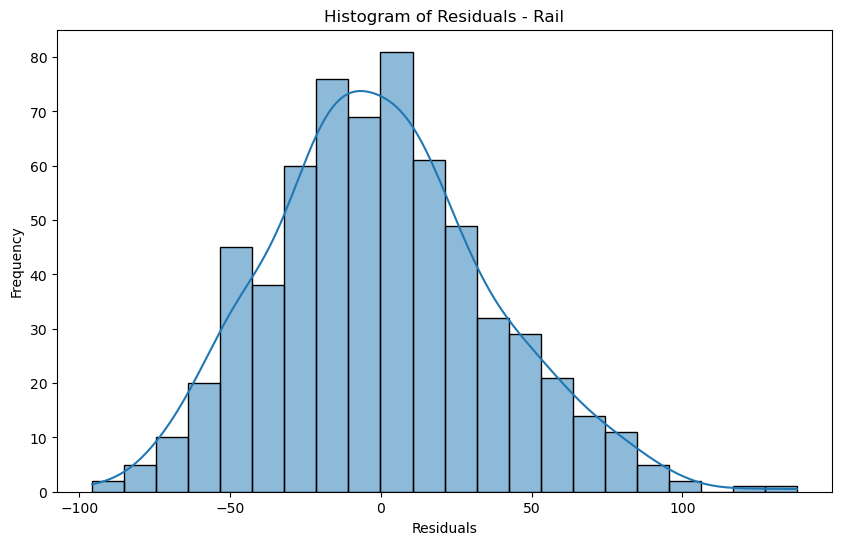

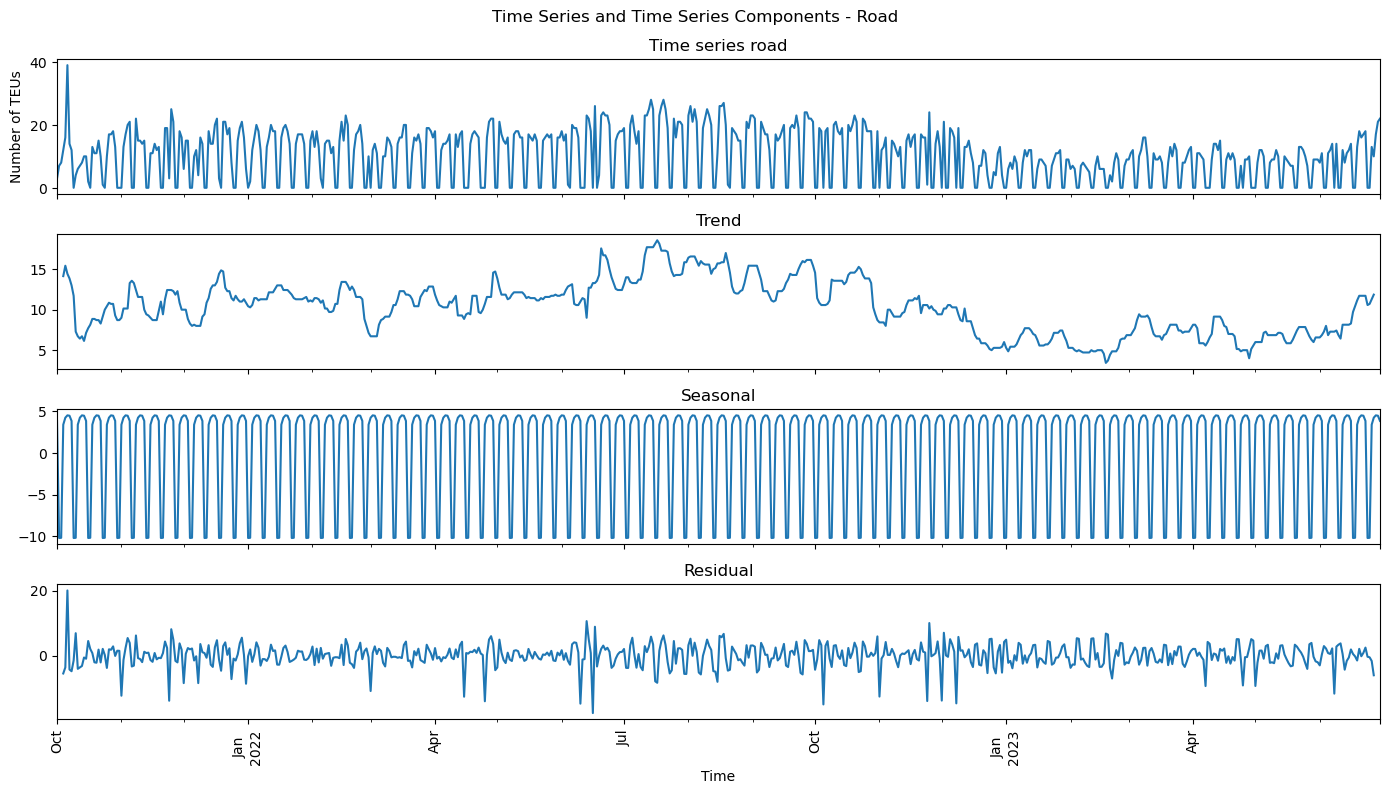

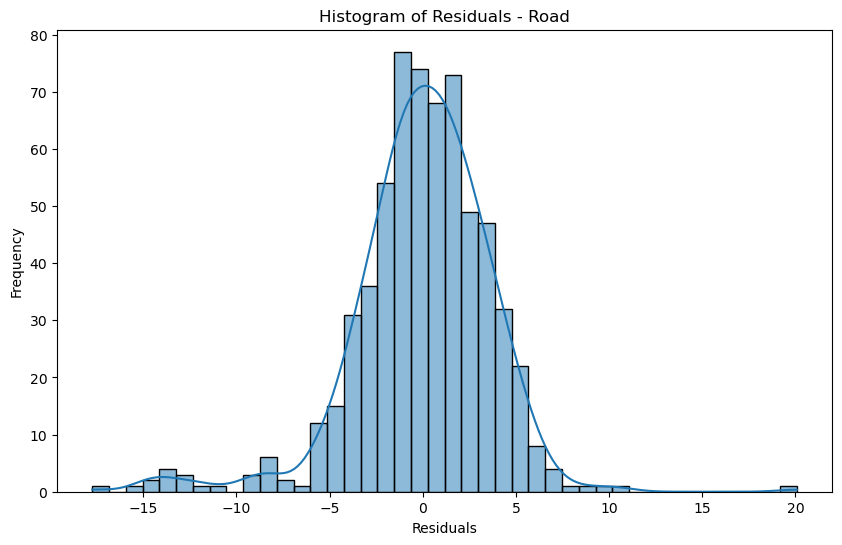

In [22]:
#Agrupar os dados pela data de chegada do comboio e camiões e somar os TEUs
serie_chegada_road = df_road_final.groupby('dataMovimentoContentor')['TEUDescarga'].sum()
serie_chegada_rail = df_rail_final.groupby('dataChegadaComboio')['TEU'].sum()

#Plotar a série temporal ferrovia
plt.plot(serie_chegada_rail) 
plt.title('Evoltution of the number of TEUs over time with destination Port of Sines')
plt.xlabel('Arrival Date')  
plt.ylabel('Number of TEUs')
plt.grid(True) 
plt.xticks(rotation=45)
plt.show()

#Plotar a série temporal rodovia
plt.plot(serie_chegada_road) 
plt.title('Evolution of the number of TEUs over time with origin Port of Sines')  
plt.xlabel('Day of departure from the truck') 
plt.ylabel('Number of TEUs')
plt.grid(True) 
plt.xticks(rotation=45)
plt.show() 

# Decomposição da série temporal da ferrovia
result_rail = seasonal_decompose(serie_chegada_rail, model='additive', period=7)
# Plotar os componentes da decomposição
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(14, 8), sharex=True)
result_rail.observed.plot(ax=ax1, title='Observed')
ax1.set_title('Time series rail')  
ax1.set_ylabel('Number of TEUs')
result_rail.trend.plot(ax=ax2, title='Trend')
result_rail.seasonal.plot(ax=ax3, title='Seasonal')
result_rail.resid.plot(ax=ax4, title='Residual')
plt.suptitle("Time Series and Time Series Components - Rail")
plt.xlabel('Time')
plt.tight_layout()
plt.xticks(rotation=90)
plt.show()

residuals_rail = result_rail.resid.dropna()  # result é o output de sua decomposição sazonal
# Plotando o histograma dos resíduos
plt.figure(figsize=(10, 6))
sns.histplot(residuals_rail, kde=True)
plt.title('Histogram of Residuals - Rail')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

# Decomposição da série temporal da rodovia
result_road = seasonal_decompose(serie_chegada_road, model='additive', period=7)
# Plotar os componentes da decomposição
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(14, 8), sharex=True)
result_road.observed.plot(ax=ax1, title='Observed')
ax1.set_title('Time series road')  
ax1.set_ylabel('Number of TEUs')
result_road.trend.plot(ax=ax2, title='Trend')
result_road.seasonal.plot(ax=ax3, title='Seasonal')
result_road.resid.plot(ax=ax4, title='Residual')
plt.suptitle("Time Series and Time Series Components - Road")
plt.xlabel('Time')
plt.tight_layout()
plt.xticks(rotation=90)
plt.show()

residuals_road = result_road.resid.dropna()  # result é o output de sua decomposição sazonal
# Plotando o histograma dos resíduos
plt.figure(figsize=(10, 6))
sns.histplot(residuals_road, kde=True)
plt.title('Histogram of Residuals - Road')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

# Um Forecast Rail

Expressão da regressão linear da ferroviar: y = 0.0244x + 49.3933


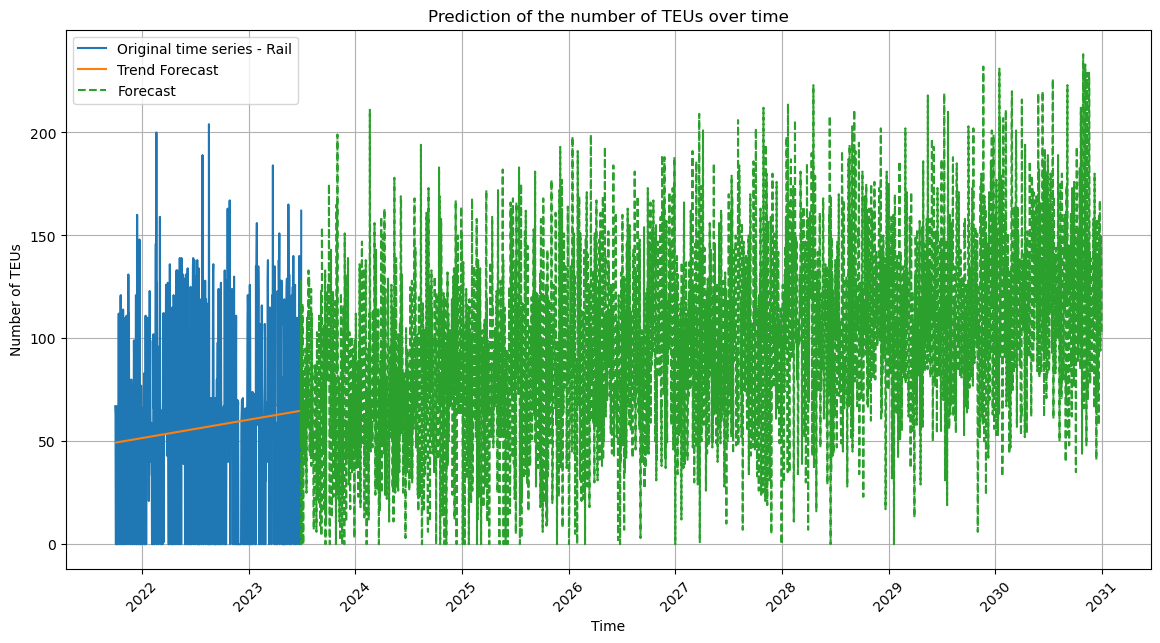

In [23]:
# Isolar os parametros da decomposição sazonal
trend_rail = result_rail.trend.dropna()
seasonal_rail = result_rail.seasonal.dropna()[:7]  # Sazonalidade de 7 dias
residuals_rail = result_rail.resid.dropna()

# Preparar os dados para a regressão linear
X_rail = np.arange(len(trend_rail)).reshape(-1, 1)
y_rail = trend_rail.values

# Ajustar a regressão linear
model_rail = LinearRegression()
model_rail.fit(X_rail, y_rail)
# Fazer previsões para a tendência usando os dados
y_rail_pred = model_rail.predict(X_rail)

# Obter os coeficientes da regressão linear
m_rail = model_rail.coef_[0]
b_rail = model_rail.intercept_
# Exibir a expressão da regressão linear
print(f'Expressão da regressão linear da ferroviar: y = {m_rail:.4f}x + {b_rail:.4f}')

# Calcular a última data dos seus dados conhecidos
last_known_date = trend_rail.index[-1]
# Definir a data de fim da previsão
end_date_2030 = pd.Timestamp('2030-12-31')

# Calcular o número de dias até a última data dos dados
days_until_2030 = (end_date_2030 - last_known_date).days

# Prever a tendência para 2030
X_future_rail = np.arange(len(trend_rail), len(trend_rail) + days_until_2030).reshape(-1, 1)
y_future_rail = model_rail.predict(X_future_rail)
y_full_pred_rail = y_future_rail

# Adicionar a sazonalidade
seasonal_repeated_rail = np.tile(seasonal_rail, len(y_full_pred_rail) // 7 + 1)[:len(y_full_pred_rail)]
y_full_pred_with_seasonal_rail = y_full_pred_rail + seasonal_repeated_rail

# Adicionar ruído baseado nos resíduos históricos
noise_rail = np.random.choice(residuals_rail, size=len(y_full_pred_rail), replace=True)
y_full_pred_with_noise_rail = y_full_pred_with_seasonal_rail + noise_rail

# Garantir que os valores negativos são ajustados para zero
y_full_pred_with_noise_rail = np.maximum(y_full_pred_with_noise_rail, 0)
y_full_pred_with_noise_rail = np.round(y_full_pred_with_noise_rail)

# Preparar a série temporal completa com as previsões
dates_full_rail = pd.date_range(start=last_known_date + pd.Timedelta(days=1), periods=len(y_full_pred_with_noise_rail), freq='D')
pred_series_rail = pd.Series(y_full_pred_with_noise_rail, index=dates_full_rail)

# Plotar a série temporal original e a previsão
plt.figure(figsize=(14, 7))
plt.plot(serie_chegada_rail, label='Original time series - Rail')
plt.plot(trend_rail.index, model_rail.predict(X_rail), label='Trend Forecast')
plt.plot(pred_series_rail.loc[trend_rail.index[-1] + pd.Timedelta(days=1):], label='Forecast', linestyle='--')
plt.title('Prediction of the number of TEUs over time')
plt.xlabel('Time')
plt.ylabel('Number of TEUs')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

## Rail Forecast baseline e growth scenarios

In [24]:
def run_simulation(result, n_sims, growth_rate, noise_dist, noise_scale = 1):
    # Extrai componentes
    trend = result.trend.dropna()
    seasonal = result.seasonal.dropna()[:7]
    residuals = result.resid.dropna()
    resid_std = residuals.std()

    # Ajuste da tendência
    X = np.arange(len(trend)).reshape(-1,1)
    y = trend.values
    model = LinearRegression().fit(X, y)

    # Datas futuras até 2030
    last_date = trend.index[-1]
    end_2030 = pd.Timestamp('2030-12-31')
    days = (end_2030 - last_date).days
    X_future = np.arange(len(trend), len(trend)+days).reshape(-1,1)
    base_forecast = model.predict(X_future)

    dates = pd.date_range(start=last_date + pd.Timedelta(days=1),
                          periods=len(base_forecast), freq='D')

    # Aplica crescimento se growth_rate > 0
    if growth_rate:
        frac_year = (dates - last_date).days / 365.0
        growth_f = (1 + growth_rate) ** frac_year
        trend_forecast = base_forecast * growth_f
    else:
        trend_forecast = base_forecast

    # Monte Carlo
    seasonal_rep = np.tile(seasonal, len(trend_forecast)//7 + 1)[:len(trend_forecast)]
    sims = []

    for _ in range(n_sims):
        # dentro do for:
        if noise_dist == 'empirical':
            noise = np.random.choice(residuals, size=len(trend_forecast), replace=True)
        elif noise_dist == 'normal':
            sigma = resid_std * noise_scale
            noise = np.random.normal(loc=0.0, scale=sigma, size=len(trend_forecast))
        else:
            raise ValueError(f"noise_dist invalid: {noise_dist}")
        y_sim = trend_forecast + seasonal_rep + noise
        y_sim = np.round(np.maximum(y_sim, 0))
        sims.append(y_sim)

    df = pd.DataFrame(sims).T
    df.index = dates
    return df


Values WithOUT growth: 2030-01-31    3839.0
2030-02-28    3474.0
2030-03-31    3812.0
2030-04-30    3804.0
2030-05-31    3876.0
2030-06-30    3806.0
2030-07-31    3990.0
2030-08-31    3923.0
2030-09-30    3897.0
2030-10-31    4058.0
2030-11-30    3887.0
2030-12-31    4098.0
Freq: M, dtype: float64
Average TEUs for 2030 without growth: 46465.70
Std TEUs for 2030 without growth: 753.16


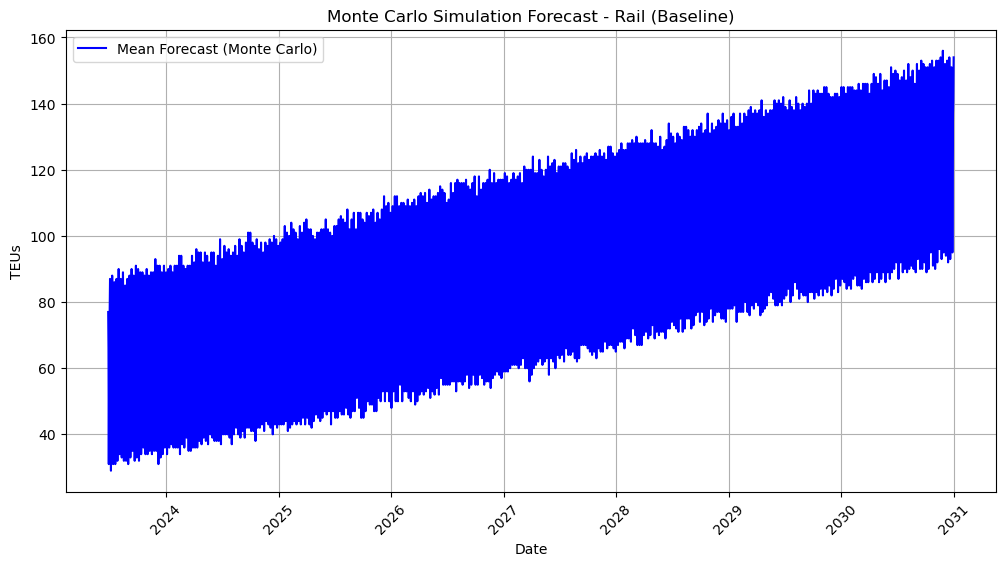

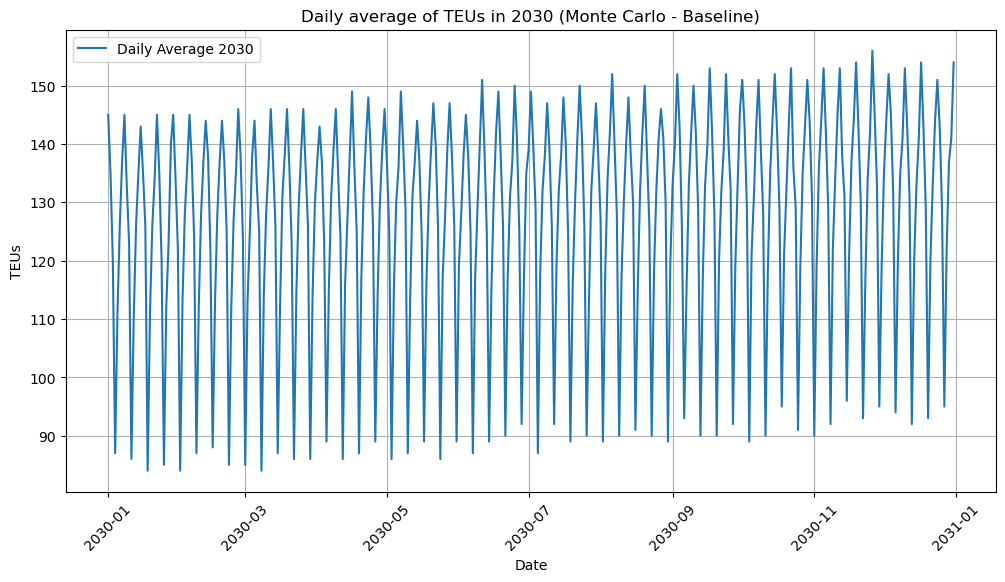

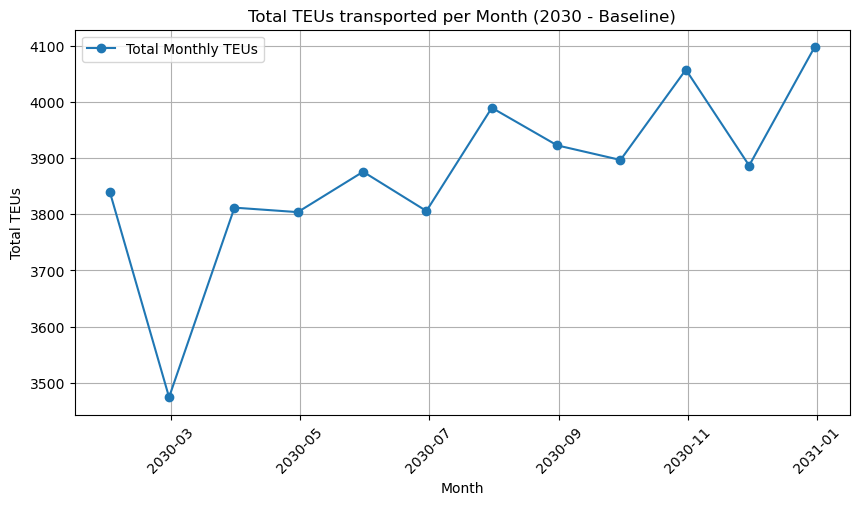

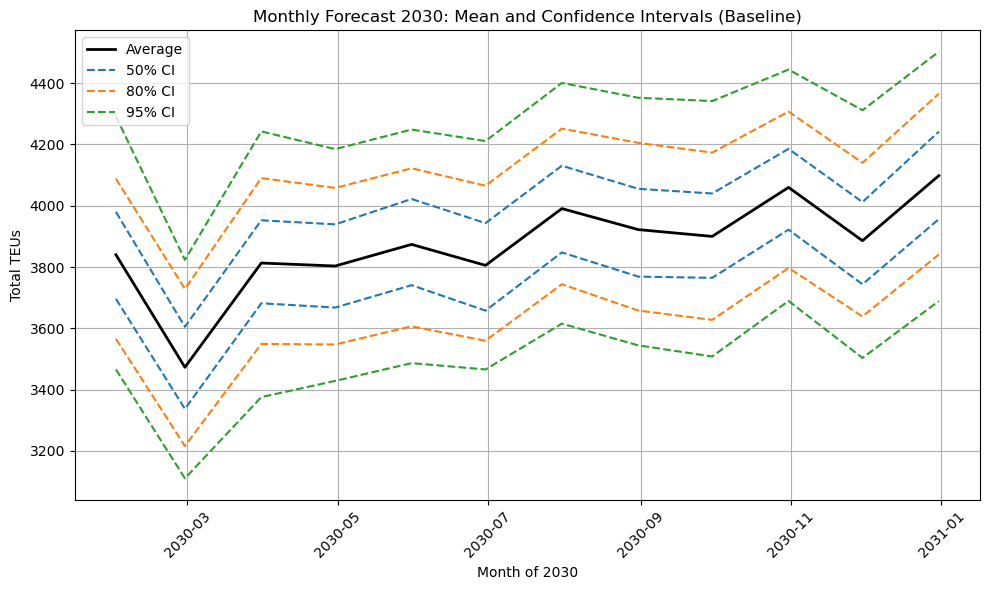

Values WITH growth: 2030-01-31    4609.0
2030-02-28    4177.0
2030-03-31    4607.0
2030-04-30    4572.0
2030-05-31    4697.0
2030-06-30    4608.0
2030-07-31    4846.0
2030-08-31    4807.0
2030-09-30    4748.0
2030-10-31    4957.0
2030-11-30    4755.0
2030-12-31    5032.0
Freq: M, dtype: float64
Average TEUs for 2030 with growth: 56413.25
Std TEUs for 2030 with growth: 721.44


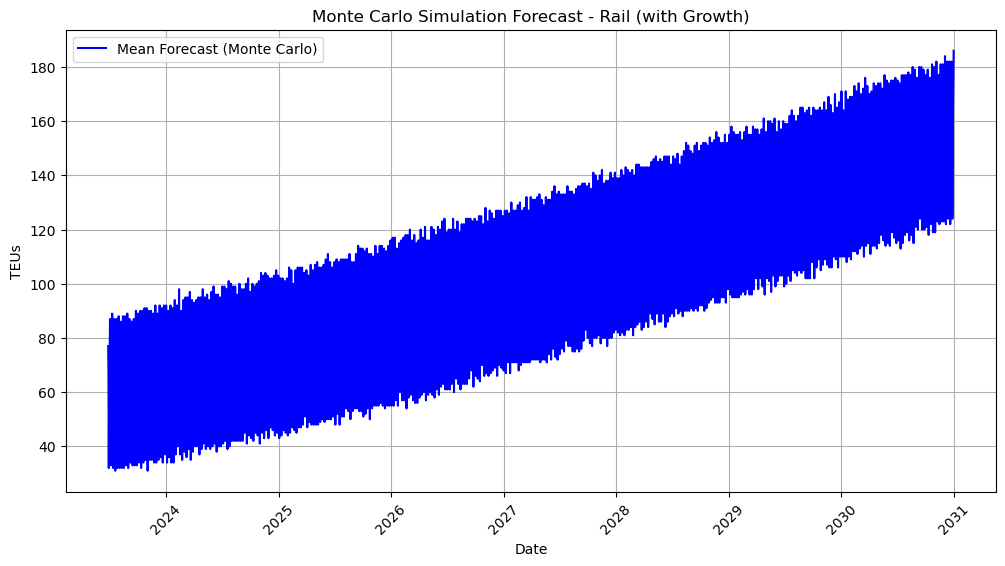

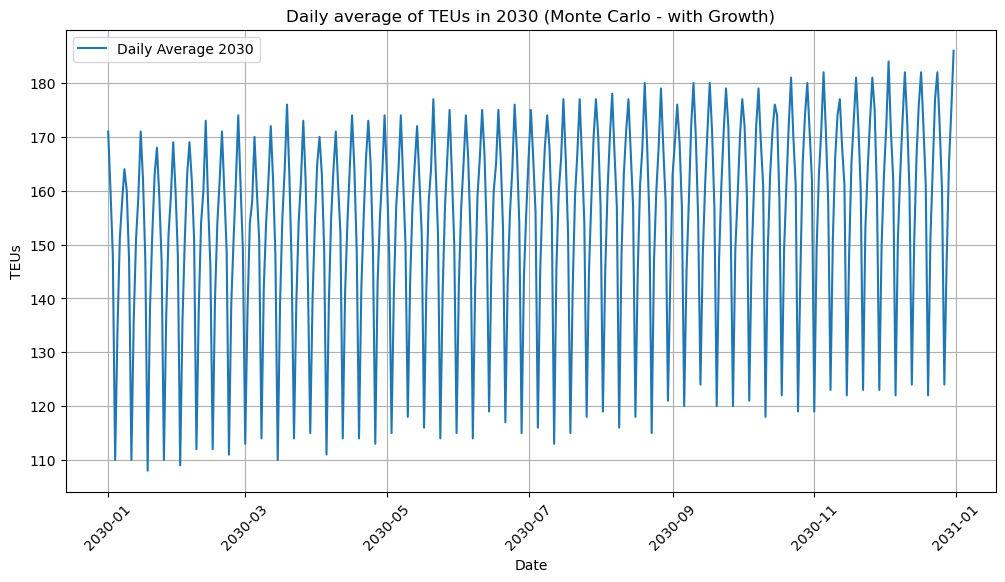

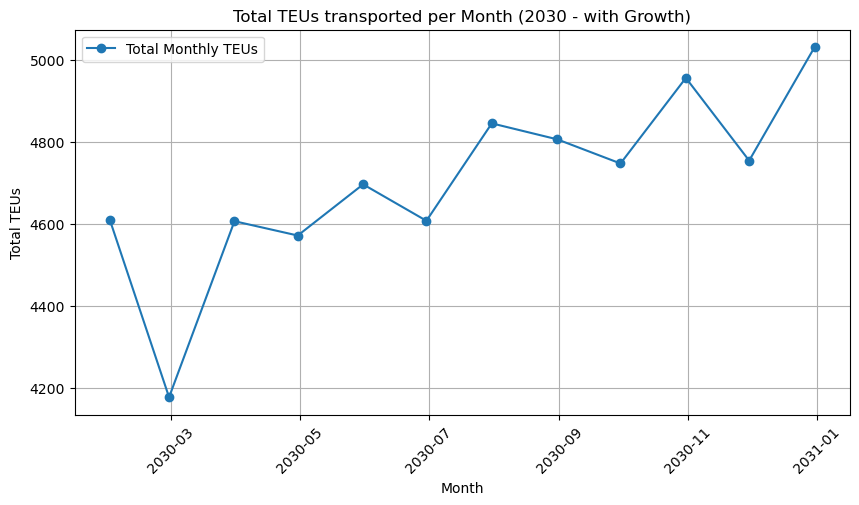

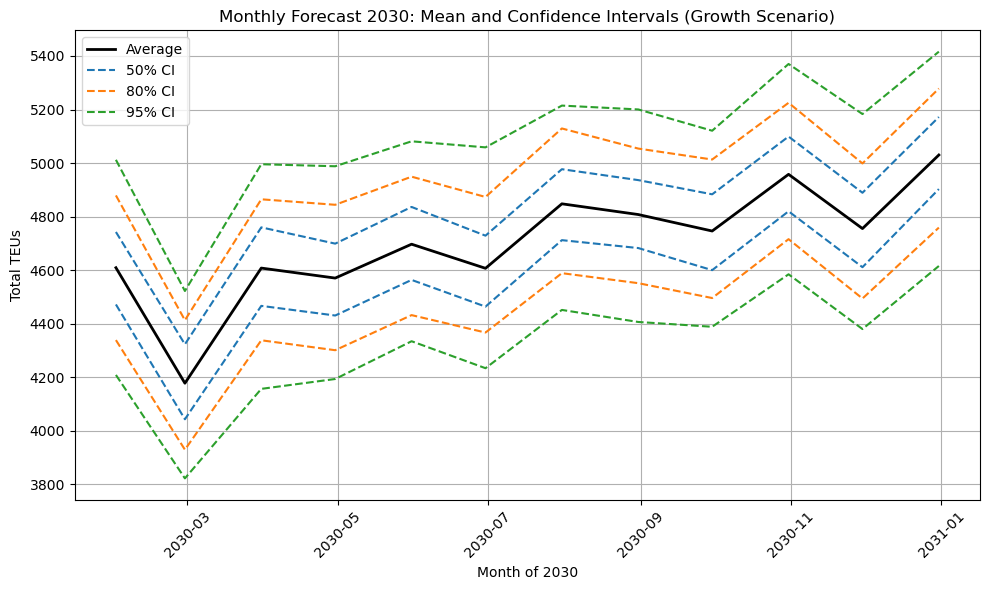

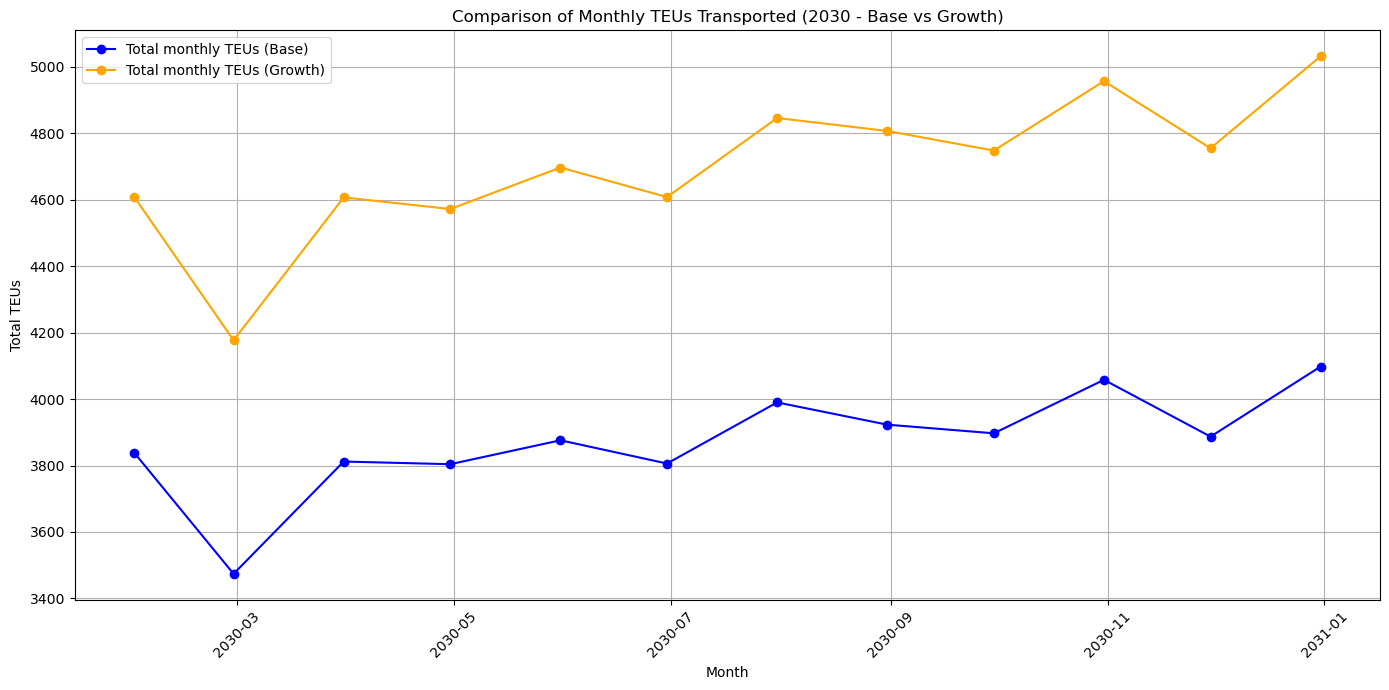

Values WITH growth and noise scale 1: 2030-01-31    4603.0
2030-02-28    4167.0
2030-03-31    4603.0
2030-04-30    4575.0
2030-05-31    4686.0
2030-06-30    4616.0
2030-07-31    4864.0
2030-08-31    4814.0
2030-09-30    4738.0
2030-10-31    4961.0
2030-11-30    4762.0
2030-12-31    5049.0
Freq: M, dtype: float64
Average TEUs for 2030 with growth and noise scale 1: 56430.88
Std TEUs for 2030 with growth and noise scale 1: 717.74


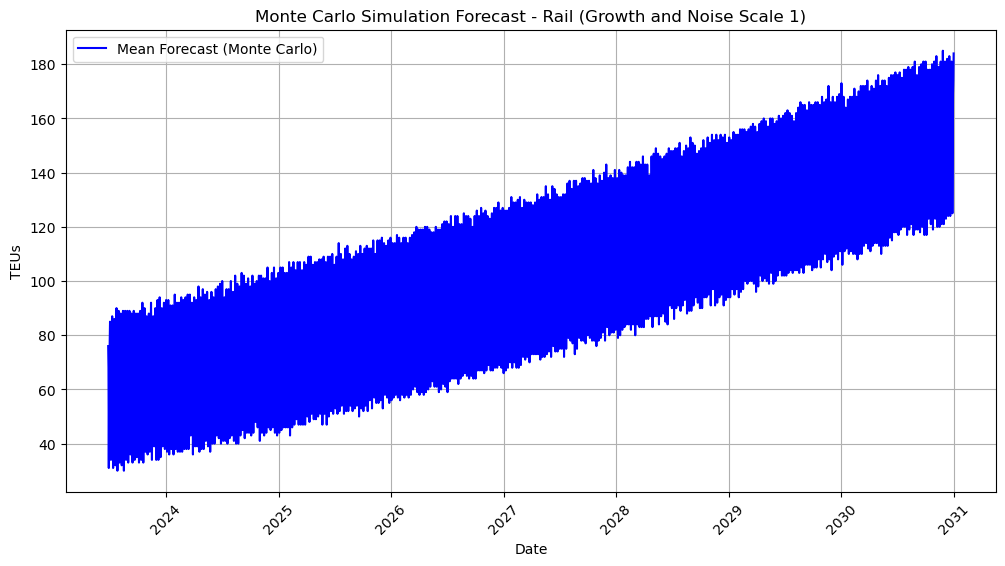

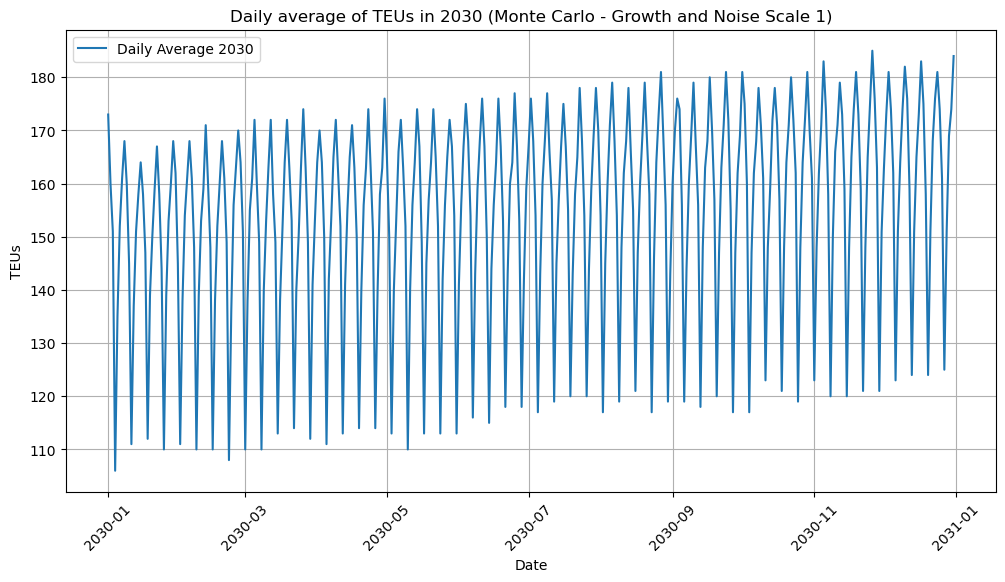

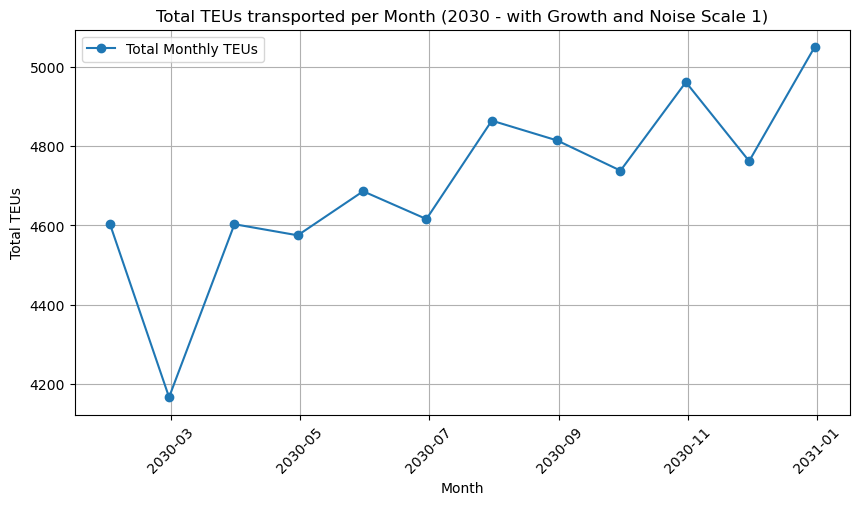

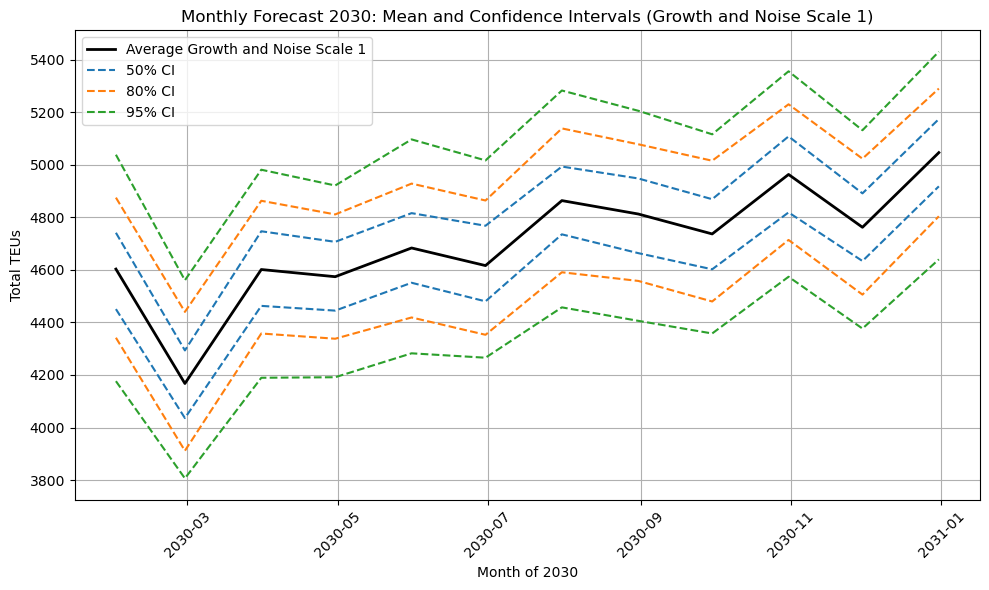

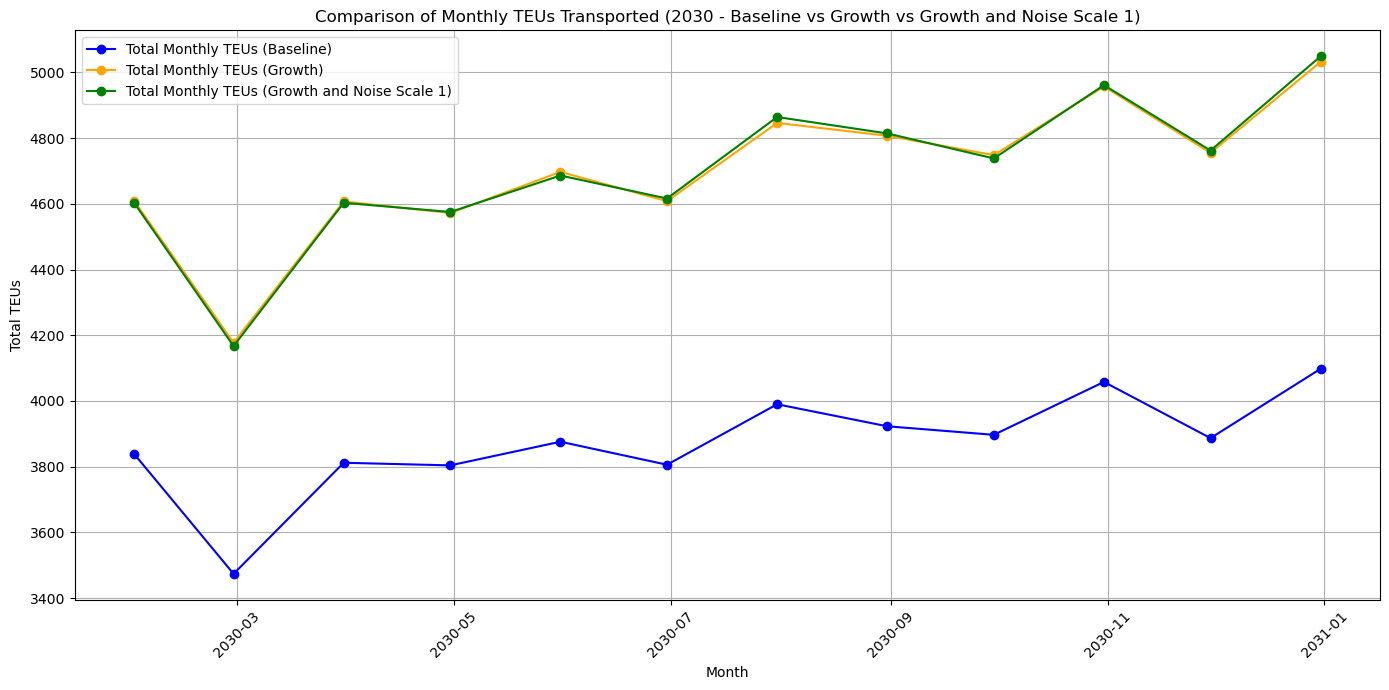

Values WITH growth and noise scale 2: 2030-01-31    4619.0
2030-02-28    4155.0
2030-03-31    4632.0
2030-04-30    4575.0
2030-05-31    4745.0
2030-06-30    4645.0
2030-07-31    4886.0
2030-08-31    4805.0
2030-09-30    4758.0
2030-10-31    4976.0
2030-11-30    4792.0
2030-12-31    5083.0
Freq: M, dtype: float64
Average TEUs for 2030 with growth and noise scale 2: 56665.26
Std TEUs for 2030 with growth and noise scale 2: 1290.99


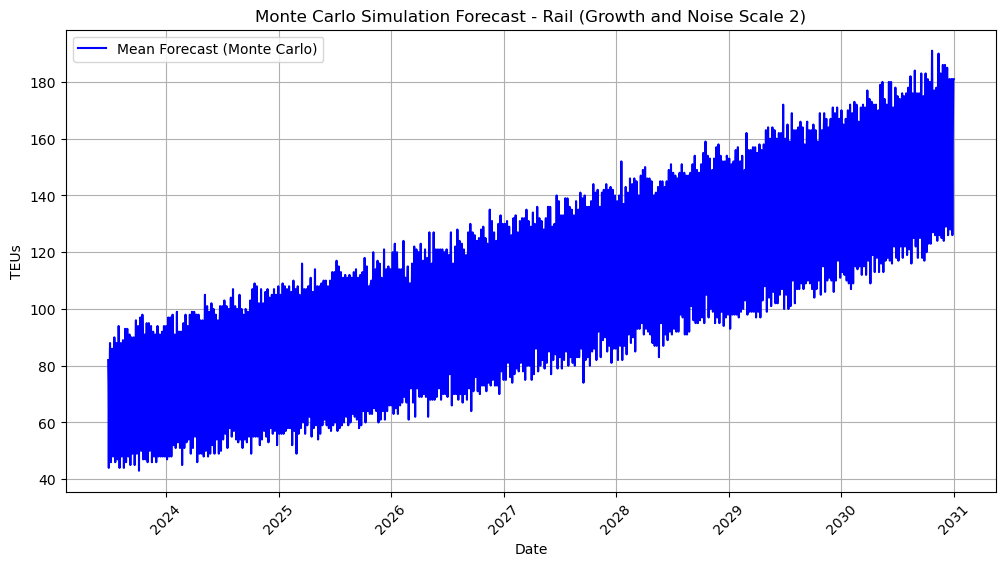

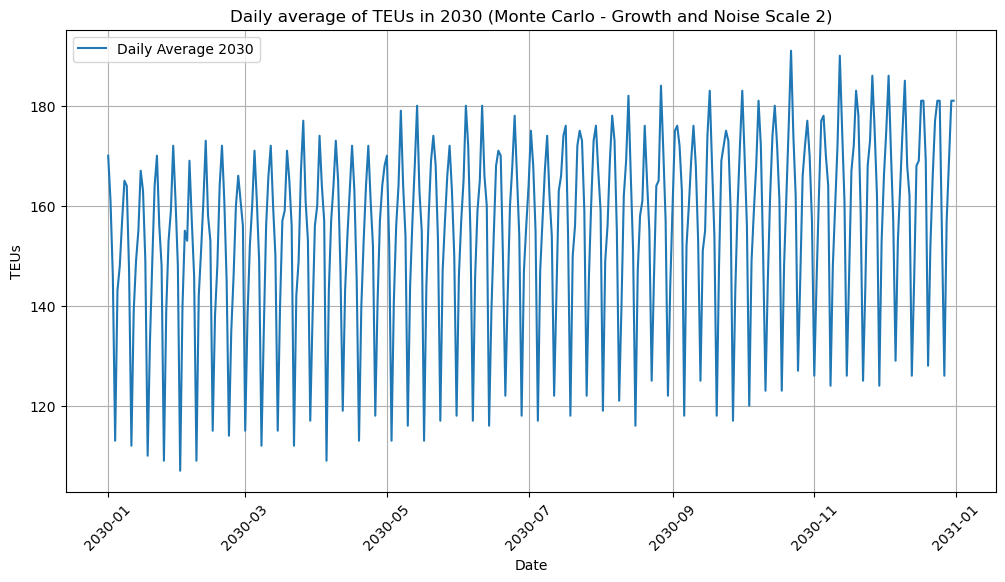

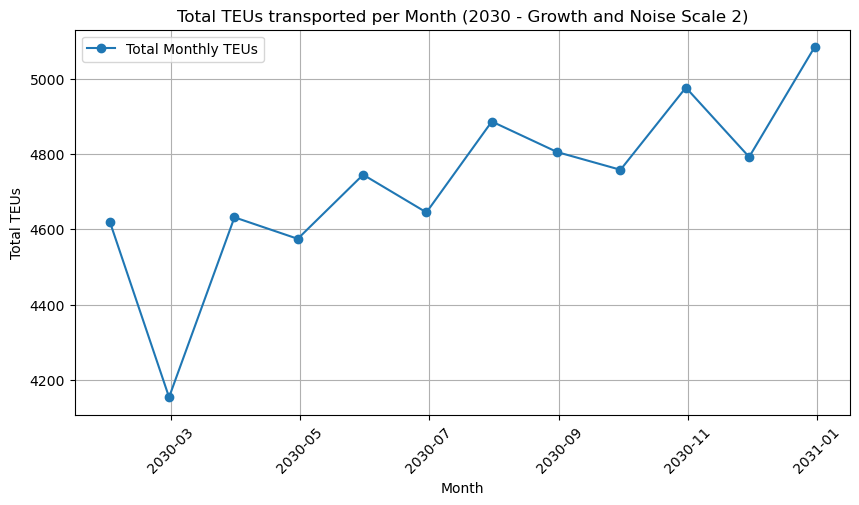

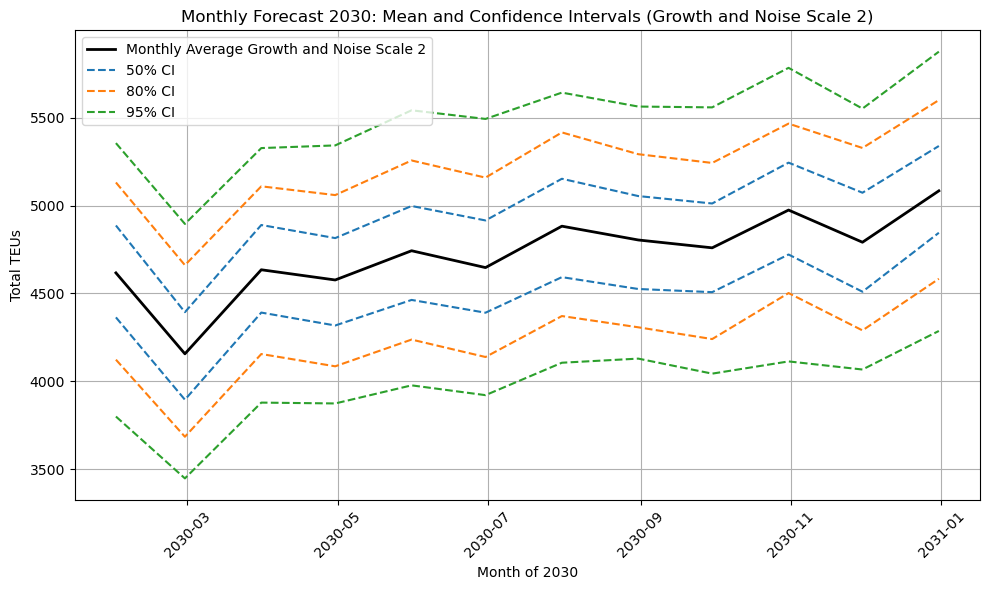

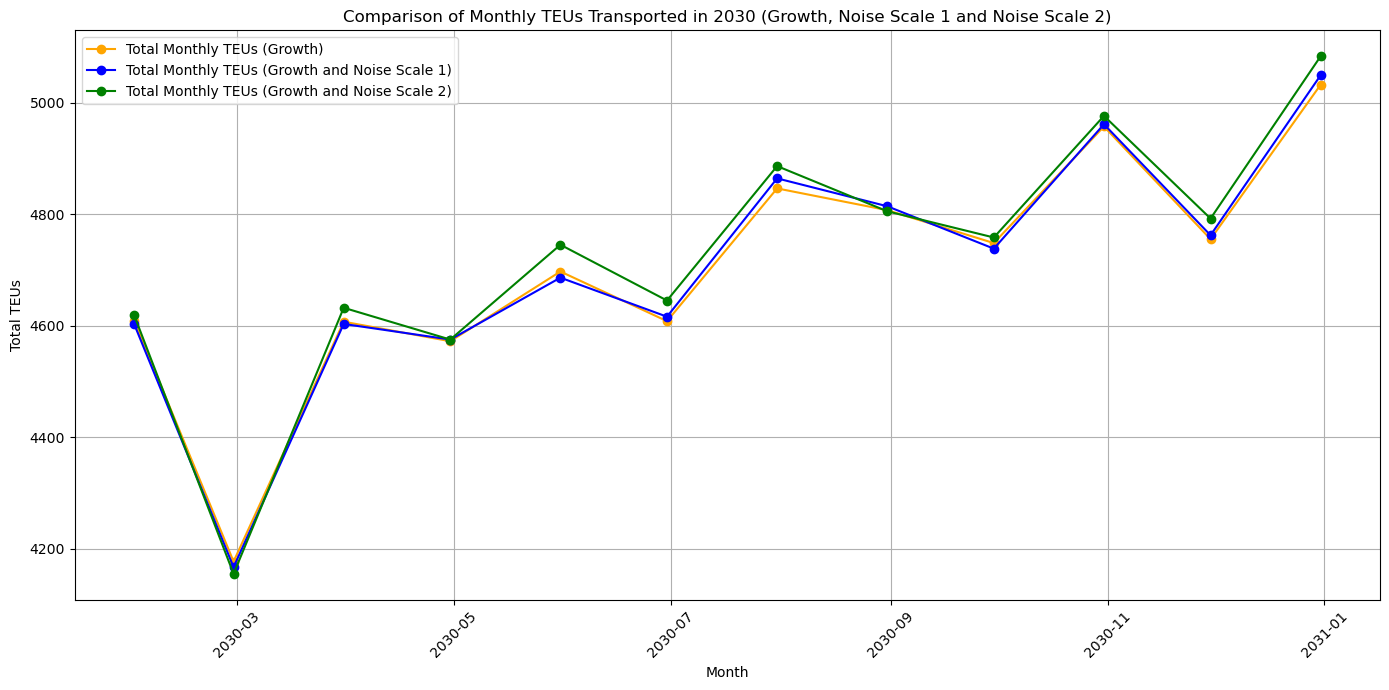

Values WITH growth and noise scale 3: 2030-01-31    4706.0
2030-02-28    4258.0
2030-03-31    4740.0
2030-04-30    4733.0
2030-05-31    4857.0
2030-06-30    4700.0
2030-07-31    4979.0
2030-08-31    4951.0
2030-09-30    4865.0
2030-10-31    5070.0
2030-11-30    4862.0
2030-12-31    5166.0
Freq: M, dtype: float64
Average TEUs for 2030 with growth and noise scale 3: 57885.36
Std TEUs for 2030 with growth and noise scale 3: 2002.67


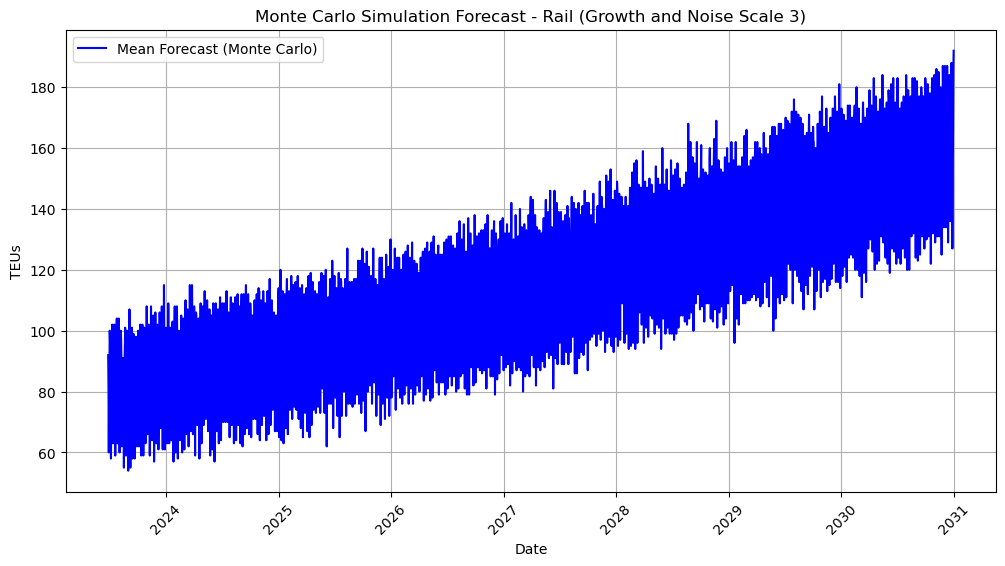

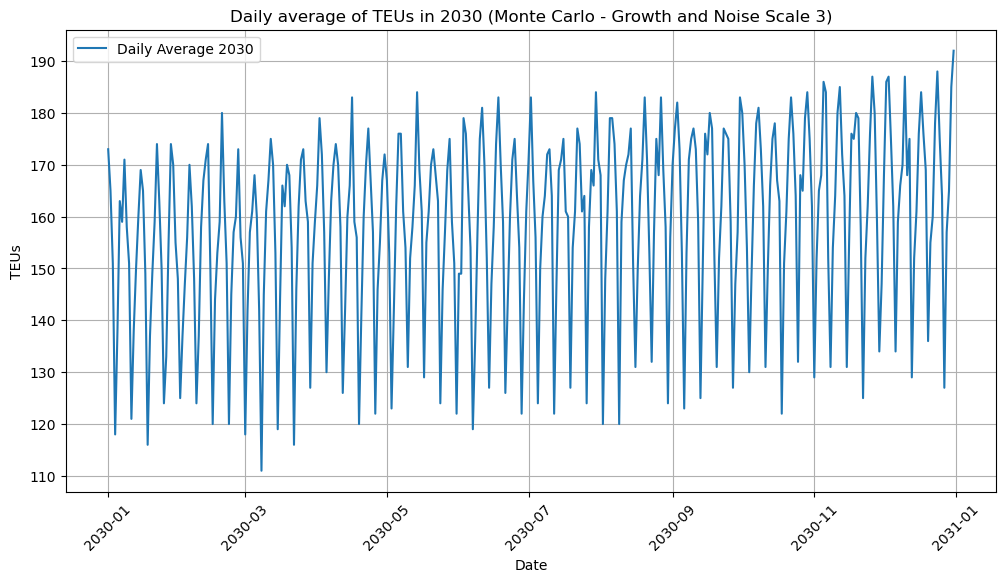

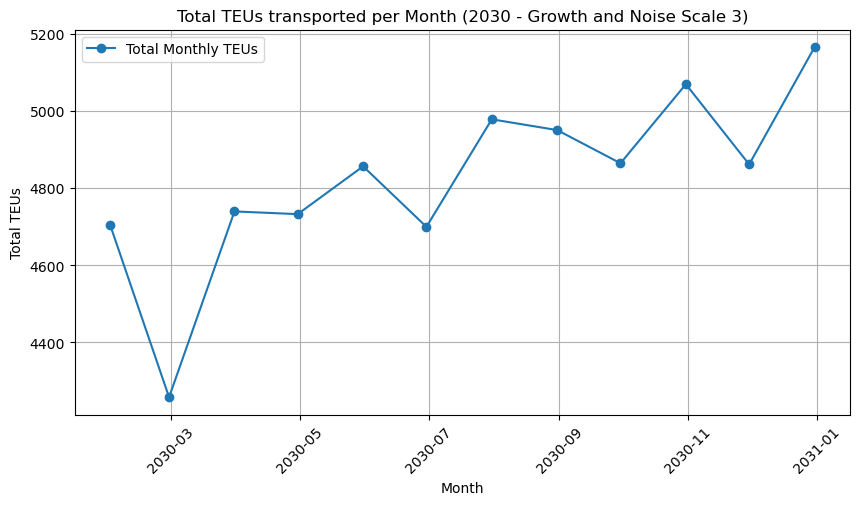

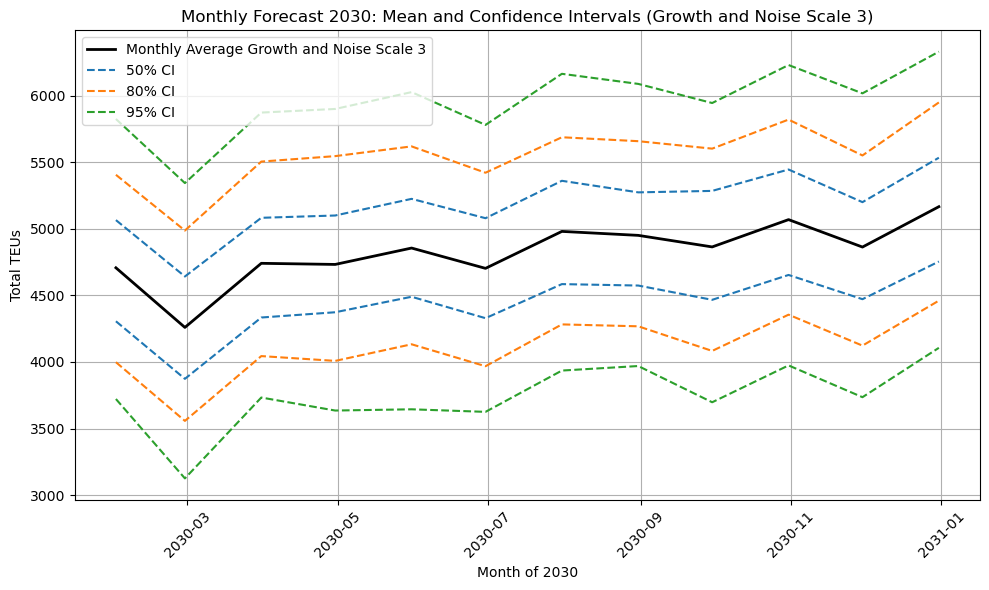

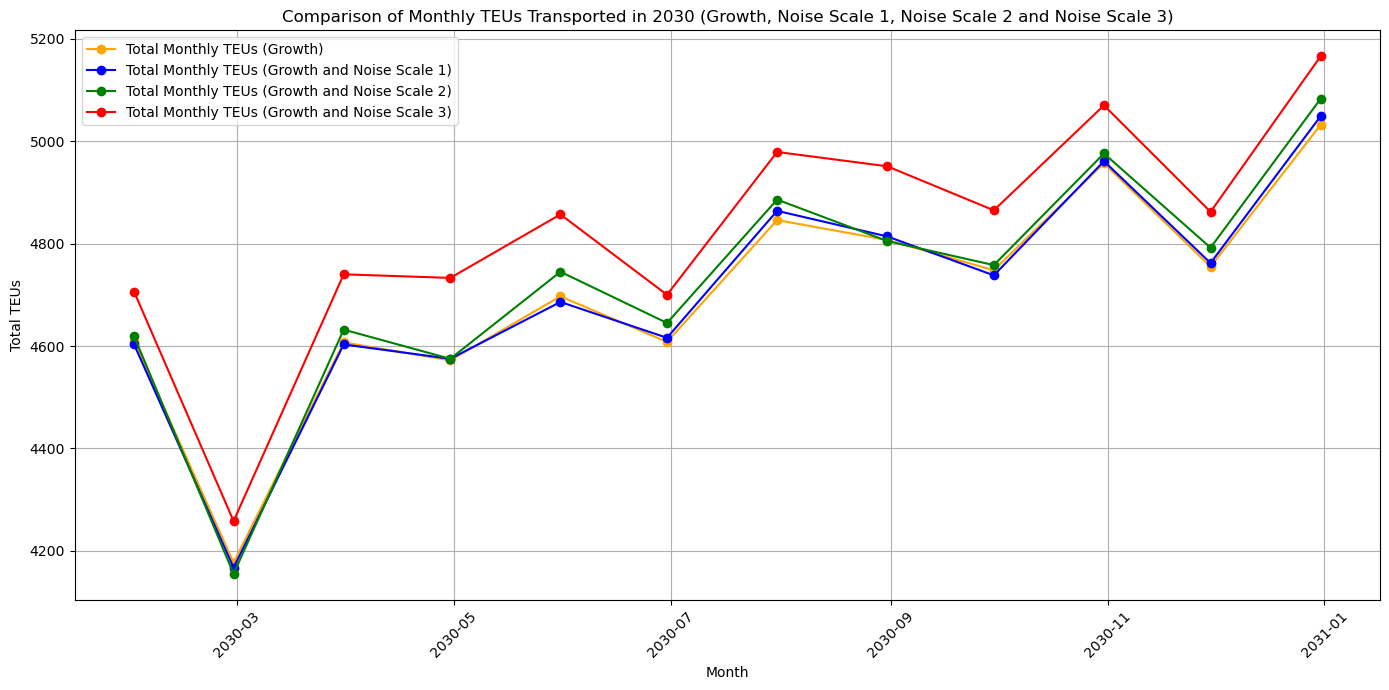

Values WITH growth and noise scale 4: 2030-01-31    4963.0
2030-02-28    4506.0
2030-03-31    5009.0
2030-04-30    4898.0
2030-05-31    5097.0
2030-06-30    4979.0
2030-07-31    5133.0
2030-08-31    5149.0
2030-09-30    5035.0
2030-10-31    5264.0
2030-11-30    5038.0
2030-12-31    5412.0
Freq: M, dtype: float64
Average TEUs for 2030 with growth and noise scale 4: 60469.70
Std TEUs for 2030 with growth and noise scale 4: 2428.59


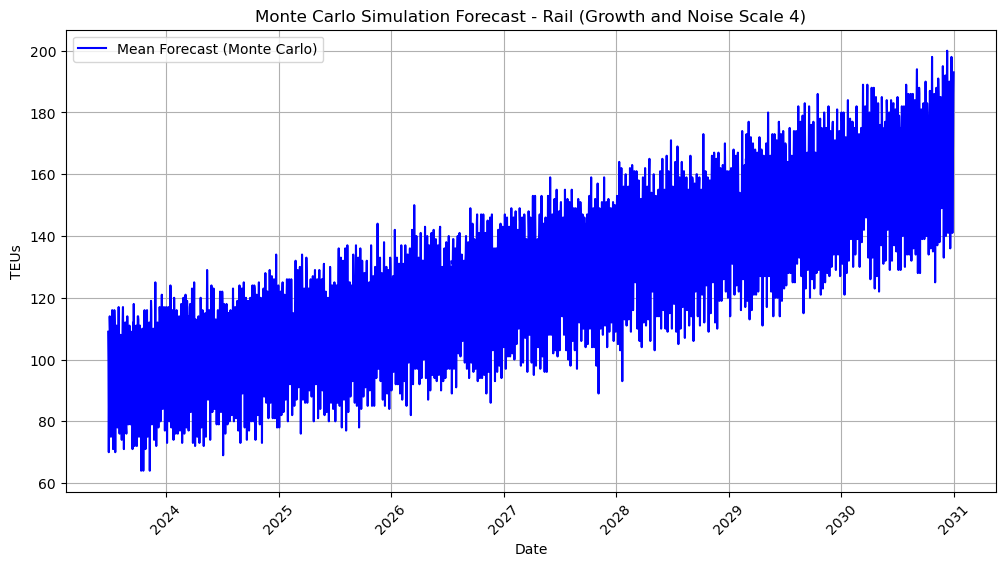

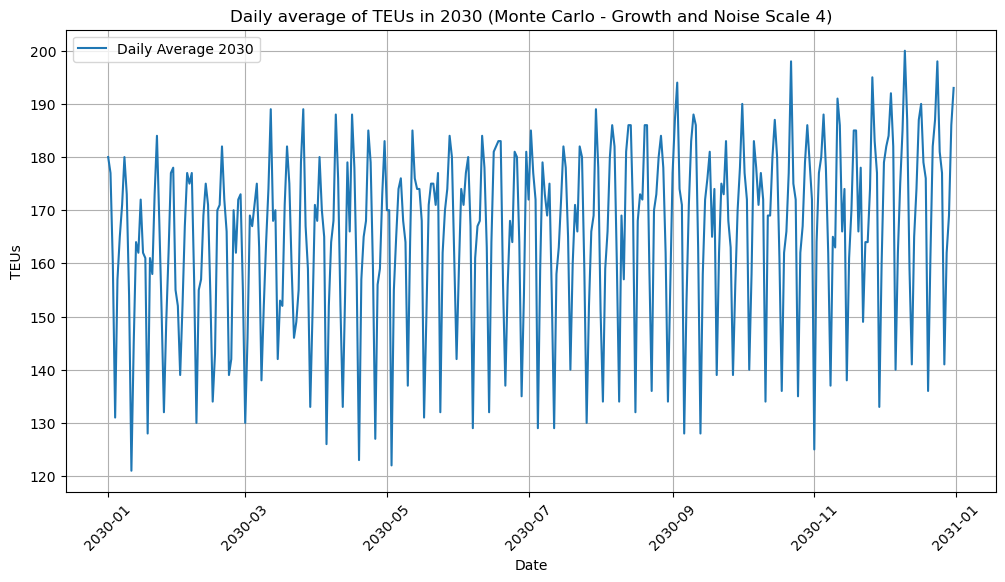

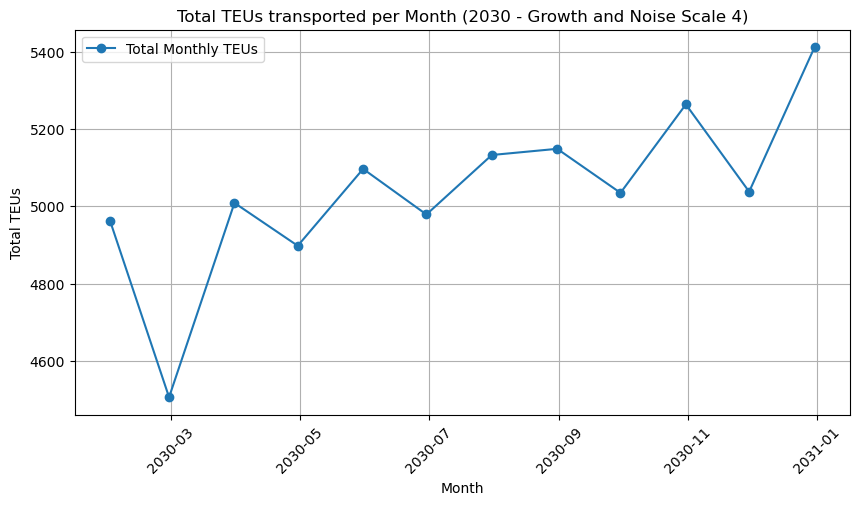

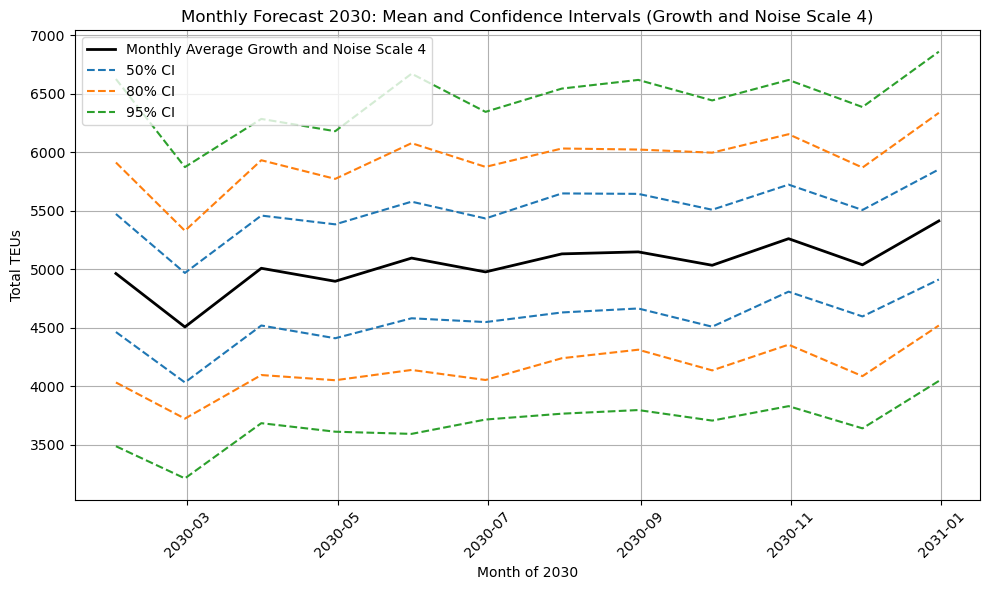

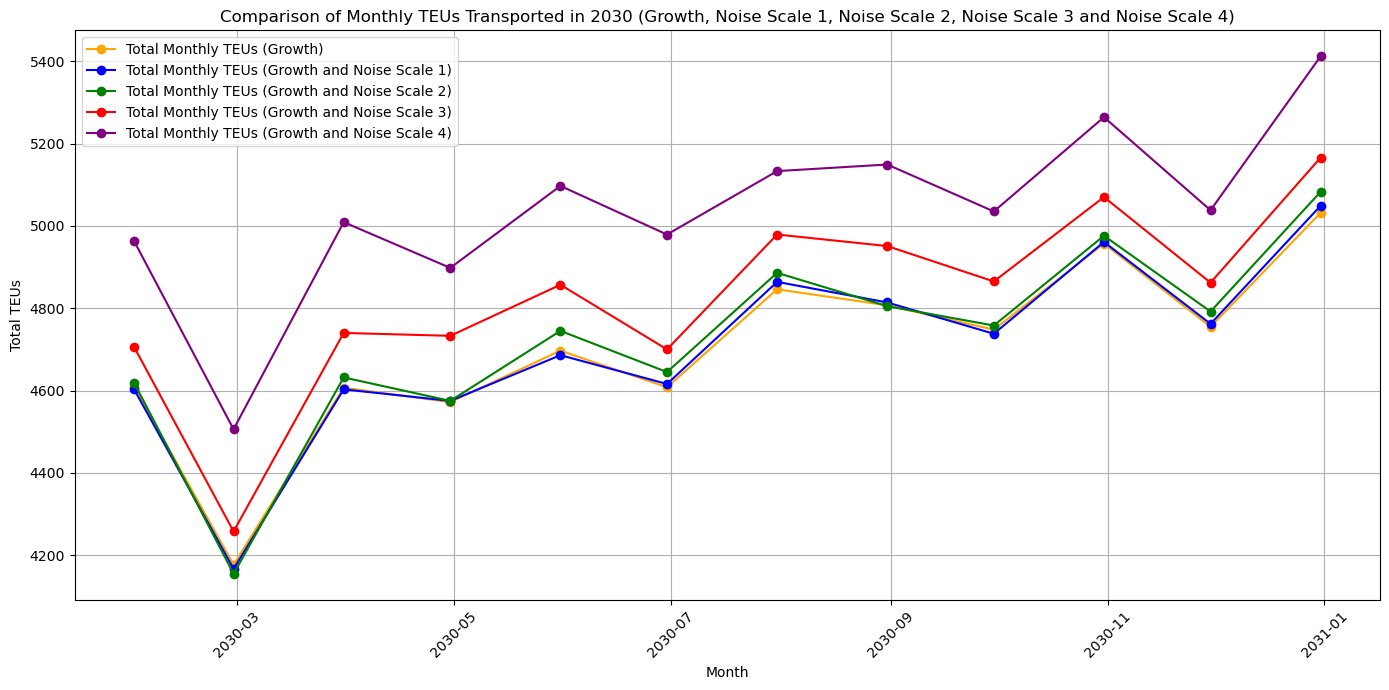

In [40]:
df_forecast_base   = run_simulation(result_rail, n_sims=500, growth_rate=0.0, noise_dist='empirical', noise_scale=1)
df_forecast_growth = run_simulation(result_rail, n_sims=500, growth_rate=0.028, noise_dist='empirical', noise_scale=1)

df_forecast_growth_norm1 = run_simulation(result_rail, n_sims=500, growth_rate=0.028, noise_dist='normal', noise_scale=1)
df_forecast_growth_norm2 = run_simulation(result_rail, n_sims=500, growth_rate=0.028, noise_dist='normal', noise_scale=2)
df_forecast_growth_norm3 = run_simulation(result_rail, n_sims=500, growth_rate=0.028, noise_dist='normal', noise_scale=3)
df_forecast_growth_norm4 = run_simulation(result_rail, n_sims=500, growth_rate=0.028, noise_dist='normal', noise_scale=4)

# Selecionar apenas os dias de 2030
simulations_2030_base = df_forecast_base.loc['2030-01-01':'2030-12-31']
# Selecionar apenas os dias de 2030 para o DataFrame com crescimento
simulations_2030_growth = df_forecast_growth.loc['2030-01-01':'2030-12-31']
# Selecionar apenas os dias de 2030 para os DataFrames com crescimento normal
simulations_2030_growth_norm1 = df_forecast_growth_norm1.loc['2030-01-01':'2030-12-31']
simulations_2030_growth_norm2 = df_forecast_growth_norm2.loc['2030-01-01':'2030-12-31']
simulations_2030_growth_norm3 = df_forecast_growth_norm3.loc['2030-01-01':'2030-12-31']
simulations_2030_growth_norm4 = df_forecast_growth_norm4.loc['2030-01-01':'2030-12-31']

# Calcular a média mensal e os intervalos de confiança para o caso base
monthly_sims_base = simulations_2030_base.resample('M').sum()
monthly_mean_base   = monthly_sims_base.mean(axis=1)
monthly_lower95_base, monthly_upper95_base = (
    monthly_sims_base.quantile(0.025, axis=1), 
    monthly_sims_base.quantile(0.975, axis=1),
)
monthly_lower80_base, monthly_upper80_base = (
    monthly_sims_base.quantile(0.10, axis=1), 
    monthly_sims_base.quantile(0.90, axis=1),
)
#Print os limites de confiança de 80%
#print(f"Lower 80%: {monthly_lower80_base}")
#print(f"Upper 80%: {monthly_upper80_base}")
monthly_lower50_base, monthly_upper50_base = (
    monthly_sims_base.quantile(0.25, axis=1),
    monthly_sims_base.quantile(0.75, axis=1),
)

# Calcular a média diária (ou qualquer estatística) ao longo de todas as simulações
mean_forecast_base= np.round(df_forecast_base.mean(axis=1))
# Média diária de cada dia arredondada (ao longo de todas as simulações)
mean_daily_2030_base = np.round(simulations_2030_base.mean(axis=1))
# Total de TEUs por mês
monthly_total_2030_base = np.round(mean_daily_2030_base.resample('M').sum())
# Printar o total de TEUs por mês
print(f"Values WithOUT growth: {monthly_total_2030_base}")

teus_2030_simulations_base = []  # Lista para armazenar o total anual de cada simulação
# Iterar sobre cada simulação (cada coluna do DataFrame)
for col in df_forecast_base.columns:
    sim_series = df_forecast_base[col]
    # Filtrar os dados de 2030 e somar para obter o total anual de TEUs
    teus_2030_base = sim_series["2030-01-01":"2030-12-31"].sum()
    teus_2030_simulations_base.append(teus_2030_base)
# Converter a lista para um array NumPy
teus_2030_simulations_base = np.array(teus_2030_simulations_base)
print(f"Average TEUs for 2030 without growth: {teus_2030_simulations_base.mean():.2f}")
print(f"Std TEUs for 2030 without growth: {teus_2030_simulations_base.std():.2f}")

# Plotar a média das simulações para 2030
plt.figure(figsize=(12, 6))
plt.plot(mean_forecast_base.index, mean_forecast_base.values, label='Mean Forecast (Monte Carlo)', color='blue')
plt.title('Monte Carlo Simulation Forecast - Rail (Baseline)')
plt.xlabel('Date')
plt.ylabel('TEUs')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(mean_daily_2030_base.index, mean_daily_2030_base.values, label='Daily Average 2030')
plt.title('Daily average of TEUs in 2030 (Monte Carlo - Baseline)')
plt.xlabel('Date')
plt.ylabel('TEUs')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10,5))
plt.plot(monthly_total_2030_base.index, monthly_total_2030_base.values, marker='o', label='Total Monthly TEUs')
plt.title("Total TEUs transported per Month (2030 - Baseline)")
plt.xlabel("Month")
plt.ylabel("Total TEUs")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

fig, ax = plt.subplots(figsize=(10,6))

ax.plot(monthly_mean_base.index, monthly_mean_base.values,
        label='Average', linewidth=2, color='black')

levels = [
    (monthly_lower50_base, monthly_upper50_base,  '50% CI', 'C0'),
    (monthly_lower80_base, monthly_upper80_base,  '80% CI', 'C1'),
    (monthly_lower95_base, monthly_upper95_base,  '95% CI', 'C2'),
]

for lower, upper, label, color in levels:
    ax.plot(lower.index, lower.values,
            linestyle='--', color=color, label=label)
    ax.plot(upper.index, upper.values,
            linestyle='--', color=color, label='_nolegend_')

ax.set_xlabel('Month of 2030')
ax.set_ylabel('Total TEUs')
ax.set_title('Monthly Forecast 2030: Mean and Confidence Intervals (Baseline)')
ax.legend(loc='upper left')
ax.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Calcular a média mensal e os intervalos de confiança para o caso com crescimento
monthly_sims_growth = simulations_2030_growth.resample('M').sum()
monthly_mean_growth   = monthly_sims_growth.mean(axis=1)
monthly_lower95_growth, monthly_upper95_growth = (
    monthly_sims_growth.quantile(0.025, axis=1),
    monthly_sims_growth.quantile(0.975, axis=1),
)
monthly_lower80_growth, monthly_upper80_growth = (
    monthly_sims_growth.quantile(0.10, axis=1),
    monthly_sims_growth.quantile(0.90, axis=1),
)
monthly_lower50_growth, monthly_upper50_growth = (
    monthly_sims_growth.quantile(0.25, axis=1),
    monthly_sims_growth.quantile(0.75, axis=1),
)

# Calcular a média diária (ou qualquer estatística) ao longo de todas as simulações
mean_forecast_growth = np.round(df_forecast_growth.mean(axis=1))
# Média diária de cada dia arredondada (ao longo de todas as simulações)
mean_daily_2030_growth = np.round(simulations_2030_growth.mean(axis=1))
# Total de TEUs por mês
monthly_total_2030_growth = np.round(mean_daily_2030_growth.resample('M').sum())
# Printar o total de TEUs por mês
print(f"Values WITH growth: {monthly_total_2030_growth}")

teus_2030_simulations_growth = []  # Lista para armazenar o total anual de cada simulação

# Iterar sobre cada simulação (cada coluna do DataFrame)
for col in df_forecast_growth.columns:
    sim_series = df_forecast_growth[col]
    # Filtrar os dados de 2030 e somar para obter o total anual de TEUs
    teus_2030_growth = sim_series["2030-01-01":"2030-12-31"].sum()
    teus_2030_simulations_growth.append(teus_2030_growth)

# Converter a lista para um array NumPy
teus_2030_simulations_growth = np.array(teus_2030_simulations_growth)
print(f"Average TEUs for 2030 with growth: {teus_2030_simulations_growth.mean():.2f}")
print(f"Std TEUs for 2030 with growth: {teus_2030_simulations_growth.std():.2f}")

# Plotar a média das simulações para 2030
plt.figure(figsize=(12, 6))
plt.plot(mean_forecast_growth.index, mean_forecast_growth.values, label='Mean Forecast (Monte Carlo)', color='blue')
plt.title('Monte Carlo Simulation Forecast - Rail (with Growth)')
plt.xlabel('Date')
plt.ylabel('TEUs')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(mean_daily_2030_growth.index, mean_daily_2030_growth.values, label='Daily Average 2030')
plt.title('Daily average of TEUs in 2030 (Monte Carlo - with Growth)')
plt.xlabel('Date')
plt.ylabel('TEUs')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10,5))
plt.plot(monthly_total_2030_growth.index, monthly_total_2030_growth.values, marker='o', label='Total Monthly TEUs')
plt.title("Total TEUs transported per Month (2030 - with Growth)")
plt.xlabel("Month")
plt.ylabel("Total TEUs")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

# Plotar os resultados com crescimento
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(monthly_mean_growth.index, monthly_mean_growth.values,
        label='Average', linewidth=2, color='black')
levels = [
    (monthly_lower50_growth, monthly_upper50_growth,  '50% CI', 'C0'),
    (monthly_lower80_growth, monthly_upper80_growth,  '80% CI', 'C1'),
    (monthly_lower95_growth, monthly_upper95_growth,  '95% CI', 'C2'),
]
for lower, upper, label, color in levels:
    ax.plot(lower.index, lower.values,
            linestyle='--', color=color, label=label)
    ax.plot(upper.index, upper.values,
            linestyle='--', color=color, label='_nolegend_')
ax.set_xlabel('Month of 2030')
ax.set_ylabel('Total TEUs')
ax.set_title('Monthly Forecast 2030: Mean and Confidence Intervals (Growth Scenario)')
ax.legend(loc='upper left')
ax.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Comparar os resultados com e sem crescimento
plt.figure(figsize=(14, 7))
plt.plot(monthly_total_2030_base.index, monthly_total_2030_base.values, marker='o', label='Total monthly TEUs (Base)', color='blue')
plt.plot(monthly_total_2030_growth.index, monthly_total_2030_growth.values, marker='o', label='Total monthly TEUs (Growth)', color='orange')
plt.title("Comparison of Monthly TEUs Transported (2030 - Base vs Growth)")
plt.xlabel("Month")
plt.ylabel("Total TEUs")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

monthly_sims_growth_norm1 = simulations_2030_growth_norm1.resample('M').sum()
monthly_mean_growth_norm1 = monthly_sims_growth_norm1.mean(axis=1)
monthly_lower95_growth_norm1, monthly_upper95_growth_norm1 = (
    monthly_sims_growth_norm1.quantile(0.025, axis=1),
    monthly_sims_growth_norm1.quantile(0.975, axis=1),
)
monthly_lower80_growth_norm1, monthly_upper80_growth_norm1 = (
    monthly_sims_growth_norm1.quantile(0.10, axis=1),
    monthly_sims_growth_norm1.quantile(0.90, axis=1),
)
monthly_lower50_growth_norm1, monthly_upper50_growth_norm1 = (
    monthly_sims_growth_norm1.quantile(0.25, axis=1),
    monthly_sims_growth_norm1.quantile(0.75, axis=1),
)
# Calcular a média diária (ou qualquer estatística) ao longo de todas as simulações
mean_forecast_growth_norm1 = np.round(df_forecast_growth_norm1.mean(axis=1))
# Média diária de cada dia arredondada (ao longo de todas as simulações)
mean_daily_2030_growth_norm1 = np.round(simulations_2030_growth_norm1.mean(axis=1))
# Total de TEUs por mês
monthly_total_2030_growth_norm1 = np.round(mean_daily_2030_growth_norm1.resample('M').sum())
# Printar o total de TEUs por mês
print(f"Values WITH growth and noise scale 1: {monthly_total_2030_growth_norm1}")
teus_2030_simulations_growth_norm1 = []  # Lista para armazenar o total anual de cada simulação
# Iterar sobre cada simulação (cada coluna do DataFrame)
for col in df_forecast_growth_norm1.columns:
    sim_series = df_forecast_growth_norm1[col]
    # Filtrar os dados de 2030 e somar para obter o total anual de TEUs
    teus_2030_growth_norm1 = sim_series["2030-01-01":"2030-12-31"].sum()
    teus_2030_simulations_growth_norm1.append(teus_2030_growth_norm1)
# Converter a lista para um array NumPy
teus_2030_simulations_growth_norm1 = np.array(teus_2030_simulations_growth_norm1)
print(f"Average TEUs for 2030 with growth and noise scale 1: {teus_2030_simulations_growth_norm1.mean():.2f}")
print(f"Std TEUs for 2030 with growth and noise scale 1: {teus_2030_simulations_growth_norm1.std():.2f}")

# Plotar a média das simulações para 2030
plt.figure(figsize=(12, 6))
plt.plot(mean_forecast_growth_norm1.index, mean_forecast_growth_norm1.values, label='Mean Forecast (Monte Carlo)', color='blue')
plt.title('Monte Carlo Simulation Forecast - Rail (Growth and Noise Scale 1)')
plt.xlabel('Date')
plt.ylabel('TEUs')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(mean_daily_2030_growth_norm1.index, mean_daily_2030_growth_norm1.values, label='Daily Average 2030')
plt.title('Daily average of TEUs in 2030 (Monte Carlo - Growth and Noise Scale 1)')
plt.xlabel('Date')
plt.ylabel('TEUs')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10,5))
plt.plot(monthly_total_2030_growth_norm1.index, monthly_total_2030_growth_norm1.values, marker='o', label='Total Monthly TEUs')
plt.title("Total TEUs transported per Month (2030 - with Growth and Noise Scale 1)")
plt.xlabel("Month")
plt.ylabel("Total TEUs")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(monthly_mean_growth_norm1.index, monthly_mean_growth_norm1.values,
        label='Average Growth and Noise Scale 1', linewidth=2, color='black')
levels = [
    (monthly_lower50_growth_norm1, monthly_upper50_growth_norm1,  '50% CI', 'C0'),
    (monthly_lower80_growth_norm1, monthly_upper80_growth_norm1,  '80% CI', 'C1'),
    (monthly_lower95_growth_norm1, monthly_upper95_growth_norm1,  '95% CI', 'C2'),
]
for lower, upper, label, color in levels:
    ax.plot(lower.index, lower.values,
            linestyle='--', color=color, label=label)
    ax.plot(upper.index, upper.values,
            linestyle='--', color=color, label='_nolegend_')
ax.set_xlabel('Month of 2030')
ax.set_ylabel('Total TEUs')
ax.set_title('Monthly Forecast 2030: Mean and Confidence Intervals (Growth and Noise Scale 1)')
ax.legend(loc='upper left')
ax.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
# Comparar os resultados com e sem crescimento e com noise scale 1
plt.figure(figsize=(14, 7))
plt.plot(monthly_total_2030_base.index, monthly_total_2030_base.values, marker='o', label='Total Monthly TEUs (Baseline)', color='blue')
plt.plot(monthly_total_2030_growth.index, monthly_total_2030_growth.values, marker='o', label='Total Monthly TEUs (Growth)', color='orange')
plt.plot(monthly_total_2030_growth_norm1.index, monthly_total_2030_growth_norm1.values, marker='o', label='Total Monthly TEUs (Growth and Noise Scale 1)', color='green')
plt.title("Comparison of Monthly TEUs Transported (2030 - Baseline vs Growth vs Growth and Noise Scale 1)")
plt.xlabel("Month")
plt.ylabel("Total TEUs")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

monthly_sims_growth_norm2 = simulations_2030_growth_norm2.resample('M').sum()
monthly_mean_growth_norm2 = monthly_sims_growth_norm2.mean(axis=1)
monthly_lower95_growth_norm2, monthly_upper95_growth_norm2 = (
    monthly_sims_growth_norm2.quantile(0.025, axis=1),
    monthly_sims_growth_norm2.quantile(0.975, axis=1),
)
monthly_lower80_growth_norm2, monthly_upper80_growth_norm2 = (
    monthly_sims_growth_norm2.quantile(0.10, axis=1),
    monthly_sims_growth_norm2.quantile(0.90, axis=1),
)
monthly_lower50_growth_norm2, monthly_upper50_growth_norm2 = (
    monthly_sims_growth_norm2.quantile(0.25, axis=1),
    monthly_sims_growth_norm2.quantile(0.75, axis=1),
)
# Calcular a média diária (ou qualquer estatística) ao longo de todas as simulações
mean_forecast_growth_norm2 = np.round(df_forecast_growth_norm2.mean(axis=1))
# Média diária de cada dia arredondada (ao longo de todas as simulações)
mean_daily_2030_growth_norm2 = np.round(simulations_2030_growth_norm2.mean(axis=1))
# Total de TEUs por mês
monthly_total_2030_growth_norm2 = np.round(mean_daily_2030_growth_norm2.resample('M').sum())
# Printar o total de TEUs por mês
print(f"Values WITH growth and noise scale 2: {monthly_total_2030_growth_norm2}")
teus_2030_simulations_growth_norm2 = []  # Lista para armazenar o total anual de cada simulação
# Iterar sobre cada simulação (cada coluna do DataFrame)
for col in df_forecast_growth_norm2.columns:
    sim_series = df_forecast_growth_norm2[col]
    # Filtrar os dados de 2030 e somar para obter o total anual de TEUs
    teus_2030_growth_norm2 = sim_series["2030-01-01":"2030-12-31"].sum()
    teus_2030_simulations_growth_norm2.append(teus_2030_growth_norm2)
# Converter a lista para um array NumPy
teus_2030_simulations_growth_norm2 = np.array(teus_2030_simulations_growth_norm2)
print(f"Average TEUs for 2030 with growth and noise scale 2: {teus_2030_simulations_growth_norm2.mean():.2f}")
print(f"Std TEUs for 2030 with growth and noise scale 2: {teus_2030_simulations_growth_norm2.std():.2f}")
# Plotar a média das simulações para 2030
plt.figure(figsize=(12, 6))
plt.plot(mean_forecast_growth_norm2.index, mean_forecast_growth_norm2.values, label='Mean Forecast (Monte Carlo)', color='blue')
plt.title('Monte Carlo Simulation Forecast - Rail (Growth and Noise Scale 2)')
plt.xlabel('Date')
plt.ylabel('TEUs')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()
plt.figure(figsize=(12, 6))
plt.plot(mean_daily_2030_growth_norm2.index, mean_daily_2030_growth_norm2.values, label='Daily Average 2030')
plt.title('Daily average of TEUs in 2030 (Monte Carlo - Growth and Noise Scale 2)')
plt.xlabel('Date')
plt.ylabel('TEUs')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()
plt.figure(figsize=(10,5))
plt.plot(monthly_total_2030_growth_norm2.index, monthly_total_2030_growth_norm2.values, marker='o', label='Total Monthly TEUs')
plt.title("Total TEUs transported per Month (2030 - Growth and Noise Scale 2)")
plt.xlabel("Month")
plt.ylabel("Total TEUs")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(monthly_mean_growth_norm2.index, monthly_mean_growth_norm2.values,
        label='Monthly Average Growth and Noise Scale 2', linewidth=2, color='black')
levels = [
    (monthly_lower50_growth_norm2, monthly_upper50_growth_norm2,  '50% CI', 'C0'),
    (monthly_lower80_growth_norm2, monthly_upper80_growth_norm2,  '80% CI', 'C1'),
    (monthly_lower95_growth_norm2, monthly_upper95_growth_norm2,  '95% CI', 'C2'),
]
for lower, upper, label, color in levels:
    ax.plot(lower.index, lower.values,
            linestyle='--', color=color, label=label)
    ax.plot(upper.index, upper.values,
            linestyle='--', color=color, label='_nolegend_')
ax.set_xlabel('Month of 2030')
ax.set_ylabel('Total TEUs')
ax.set_title('Monthly Forecast 2030: Mean and Confidence Intervals (Growth and Noise Scale 2)')
ax.legend(loc='upper left')
ax.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
# Comparar os resultados com com crescimento, com noise scale 1 e com noise scale 2
plt.figure(figsize=(14, 7))
plt.plot(monthly_total_2030_growth.index, monthly_total_2030_growth.values, marker='o', label='Total Monthly TEUs (Growth)', color='orange')
plt.plot(monthly_total_2030_growth_norm1.index, monthly_total_2030_growth_norm1.values, marker='o', label='Total Monthly TEUs (Growth and Noise Scale 1)', color='blue')
plt.plot(monthly_total_2030_growth_norm2.index, monthly_total_2030_growth_norm2.values, marker='o', label='Total Monthly TEUs (Growth and Noise Scale 2)', color='green')
plt.title("Comparison of Monthly TEUs Transported in 2030 (Growth, Noise Scale 1 and Noise Scale 2)")
plt.xlabel("Month")
plt.ylabel("Total TEUs")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

monthly_sims_growth_norm3 = simulations_2030_growth_norm3.resample('M').sum()
monthly_mean_growth_norm3 = monthly_sims_growth_norm3.mean(axis=1)
monthly_lower95_growth_norm3, monthly_upper95_growth_norm3 = (
    monthly_sims_growth_norm3.quantile(0.025, axis=1),
    monthly_sims_growth_norm3.quantile(0.975, axis=1),
)
monthly_lower80_growth_norm3, monthly_upper80_growth_norm3 = (
    monthly_sims_growth_norm3.quantile(0.10, axis=1),
    monthly_sims_growth_norm3.quantile(0.90, axis=1),
)
monthly_lower50_growth_norm3, monthly_upper50_growth_norm3 = (
    monthly_sims_growth_norm3.quantile(0.25, axis=1),
    monthly_sims_growth_norm3.quantile(0.75, axis=1),
)
# Calcular a média diária (ou qualquer estatística) ao longo de todas as simulações
mean_forecast_growth_norm3 = np.round(df_forecast_growth_norm3.mean(axis=1))
# Média diária de cada dia arredondada (ao longo de todas as simulações)
mean_daily_2030_growth_norm3 = np.round(simulations_2030_growth_norm3.mean(axis=1))
# Total de TEUs por mês
monthly_total_2030_growth_norm3 = np.round(mean_daily_2030_growth_norm3.resample('M').sum())
# Printar o total de TEUs por mês
print(f"Values WITH growth and noise scale 3: {monthly_total_2030_growth_norm3}")
teus_2030_simulations_growth_norm3 = []  # Lista para armazenar o total anual de cada simulação
# Iterar sobre cada simulação (cada coluna do DataFrame)
for col in df_forecast_growth_norm3.columns:
    sim_series = df_forecast_growth_norm3[col]
    # Filtrar os dados de 2030 e somar para obter o total anual de TEUs
    teus_2030_growth_norm3 = sim_series["2030-01-01":"2030-12-31"].sum()
    teus_2030_simulations_growth_norm3.append(teus_2030_growth_norm3)
# Converter a lista para um array NumPy
teus_2030_simulations_growth_norm3 = np.array(teus_2030_simulations_growth_norm3)
print(f"Average TEUs for 2030 with growth and noise scale 3: {teus_2030_simulations_growth_norm3.mean():.2f}")
print(f"Std TEUs for 2030 with growth and noise scale 3: {teus_2030_simulations_growth_norm3.std():.2f}")
# Plotar a média das simulações para 2030
plt.figure(figsize=(12, 6))
plt.plot(mean_forecast_growth_norm3.index, mean_forecast_growth_norm3.values, label='Mean Forecast (Monte Carlo)', color='blue')
plt.title('Monte Carlo Simulation Forecast - Rail (Growth and Noise Scale 3)')
plt.xlabel('Date')
plt.ylabel('TEUs')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()
plt.figure(figsize=(12, 6))
plt.plot(mean_daily_2030_growth_norm3.index, mean_daily_2030_growth_norm3.values, label='Daily Average 2030')
plt.title('Daily average of TEUs in 2030 (Monte Carlo - Growth and Noise Scale 3)')
plt.xlabel('Date')
plt.ylabel('TEUs')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()
plt.figure(figsize=(10,5))
plt.plot(monthly_total_2030_growth_norm3.index, monthly_total_2030_growth_norm3.values, marker='o', label='Total Monthly TEUs')
plt.title("Total TEUs transported per Month (2030 - Growth and Noise Scale 3)")
plt.xlabel("Month")
plt.ylabel("Total TEUs")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(monthly_mean_growth_norm3.index, monthly_mean_growth_norm3.values,
        label='Monthly Average Growth and Noise Scale 3', linewidth=2, color='black')
levels = [
    (monthly_lower50_growth_norm3, monthly_upper50_growth_norm3,  '50% CI', 'C0'),
    (monthly_lower80_growth_norm3, monthly_upper80_growth_norm3,  '80% CI', 'C1'),
    (monthly_lower95_growth_norm3, monthly_upper95_growth_norm3,  '95% CI', 'C2'),
]
for lower, upper, label, color in levels:
    ax.plot(lower.index, lower.values,
            linestyle='--', color=color, label=label)
    ax.plot(upper.index, upper.values,
            linestyle='--', color=color, label='_nolegend_')
ax.set_xlabel('Month of 2030')
ax.set_ylabel('Total TEUs')
ax.set_title('Monthly Forecast 2030: Mean and Confidence Intervals (Growth and Noise Scale 3)')
ax.legend(loc='upper left')
ax.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
# Comparar os resultados com com crescimento, com noise scale 1, noise scale 2 e noise scale 3
plt.figure(figsize=(14, 7))
plt.plot(monthly_total_2030_growth.index, monthly_total_2030_growth.values, marker='o', label='Total Monthly TEUs (Growth)', color='orange')
plt.plot(monthly_total_2030_growth_norm1.index, monthly_total_2030_growth_norm1.values, marker='o', label='Total Monthly TEUs (Growth and Noise Scale 1)', color='blue')
plt.plot(monthly_total_2030_growth_norm2.index, monthly_total_2030_growth_norm2.values, marker='o', label='Total Monthly TEUs (Growth and Noise Scale 2)', color='green')
plt.plot(monthly_total_2030_growth_norm3.index, monthly_total_2030_growth_norm3.values, marker='o', label='Total Monthly TEUs (Growth and Noise Scale 3)', color='red')
plt.title("Comparison of Monthly TEUs Transported in 2030 (Growth, Noise Scale 1, Noise Scale 2 and Noise Scale 3)")
plt.xlabel("Month")
plt.ylabel("Total TEUs")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
monthly_sims_growth_norm4 = simulations_2030_growth_norm4.resample('M').sum()
monthly_mean_growth_norm4 = monthly_sims_growth_norm4.mean(axis=1)
monthly_lower95_growth_norm4, monthly_upper95_growth_norm4 = (
    monthly_sims_growth_norm4.quantile(0.025, axis=1),
    monthly_sims_growth_norm4.quantile(0.975, axis=1),
)
monthly_lower80_growth_norm4, monthly_upper80_growth_norm4 = (
    monthly_sims_growth_norm4.quantile(0.10, axis=1),
    monthly_sims_growth_norm4.quantile(0.90, axis=1),
)
monthly_lower50_growth_norm4, monthly_upper50_growth_norm4 = (
    monthly_sims_growth_norm4.quantile(0.25, axis=1),
    monthly_sims_growth_norm4.quantile(0.75, axis=1),
)
# Calcular a média diária (ou qualquer estatística) ao longo de todas as simulações
mean_forecast_growth_norm4 = np.round(df_forecast_growth_norm4.mean(axis=1))
# Média diária de cada dia arredondada (ao longo de todas as simulações)
mean_daily_2030_growth_norm4 = np.round(simulations_2030_growth_norm4.mean(axis=1))
# Total de TEUs por mês
monthly_total_2030_growth_norm4 = np.round(mean_daily_2030_growth_norm4.resample('M').sum())
# Printar o total de TEUs por mês
print(f"Values WITH growth and noise scale 4: {monthly_total_2030_growth_norm4}")
teus_2030_simulations_growth_norm4 = []  # Lista para armazenar o total anual de cada simulação
# Iterar sobre cada simulação (cada coluna do DataFrame)
for col in df_forecast_growth_norm4.columns:
    sim_series = df_forecast_growth_norm4[col]
    # Filtrar os dados de 2030 e somar para obter o total anual de TEUs
    teus_2030_growth_norm4 = sim_series["2030-01-01":"2030-12-31"].sum()
    teus_2030_simulations_growth_norm4.append(teus_2030_growth_norm4)
# Converter a lista para um array NumPy
teus_2030_simulations_growth_norm4 = np.array(teus_2030_simulations_growth_norm4)
print(f"Average TEUs for 2030 with growth and noise scale 4: {teus_2030_simulations_growth_norm4.mean():.2f}")
print(f"Std TEUs for 2030 with growth and noise scale 4: {teus_2030_simulations_growth_norm4.std():.2f}")
# Plotar a média das simulações para 2030
plt.figure(figsize=(12, 6))
plt.plot(mean_forecast_growth_norm4.index, mean_forecast_growth_norm4.values, label='Mean Forecast (Monte Carlo)', color='blue')
plt.title('Monte Carlo Simulation Forecast - Rail (Growth and Noise Scale 4)')
plt.xlabel('Date')
plt.ylabel('TEUs')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()
plt.figure(figsize=(12, 6))
plt.plot(mean_daily_2030_growth_norm4.index, mean_daily_2030_growth_norm4.values, label='Daily Average 2030')
plt.title('Daily average of TEUs in 2030 (Monte Carlo - Growth and Noise Scale 4)')
plt.xlabel('Date')
plt.ylabel('TEUs')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()
plt.figure(figsize=(10,5))
plt.plot(monthly_total_2030_growth_norm4.index, monthly_total_2030_growth_norm4.values, marker='o', label='Total Monthly TEUs')
plt.title("Total TEUs transported per Month (2030 - Growth and Noise Scale 4)")
plt.xlabel("Month")
plt.ylabel("Total TEUs")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(monthly_mean_growth_norm4.index, monthly_mean_growth_norm4.values,
        label='Monthly Average Growth and Noise Scale 4', linewidth=2, color='black')
levels = [
    (monthly_lower50_growth_norm4, monthly_upper50_growth_norm4,  '50% CI', 'C0'),
    (monthly_lower80_growth_norm4, monthly_upper80_growth_norm4,  '80% CI', 'C1'),
    (monthly_lower95_growth_norm4, monthly_upper95_growth_norm4,  '95% CI', 'C2'),
]
for lower, upper, label, color in levels:
    ax.plot(lower.index, lower.values,
            linestyle='--', color=color, label=label)
    ax.plot(upper.index, upper.values,
            linestyle='--', color=color, label='_nolegend_')
ax.set_xlabel('Month of 2030')
ax.set_ylabel('Total TEUs')
ax.set_title('Monthly Forecast 2030: Mean and Confidence Intervals (Growth and Noise Scale 4)')
ax.legend(loc='upper left')
ax.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
# Comparar os resultados com com crescimento, com noise scale 1, noise scale 2, noise scale 3 e noise scale 4
plt.figure(figsize=(14, 7))
plt.plot(monthly_total_2030_growth.index, monthly_total_2030_growth.values, marker='o', label='Total Monthly TEUs (Growth)', color='orange')
plt.plot(monthly_total_2030_growth_norm1.index, monthly_total_2030_growth_norm1.values, marker='o', label='Total Monthly TEUs (Growth and Noise Scale 1)', color='blue')
plt.plot(monthly_total_2030_growth_norm2.index, monthly_total_2030_growth_norm2.values, marker='o', label='Total Monthly TEUs (Growth and Noise Scale 2)', color='green')
plt.plot(monthly_total_2030_growth_norm3.index, monthly_total_2030_growth_norm3.values, marker='o', label='Total Monthly TEUs (Growth and Noise Scale 3)', color='red')
plt.plot(monthly_total_2030_growth_norm4.index, monthly_total_2030_growth_norm4.values, marker='o', label='Total Monthly TEUs (Growth and Noise Scale 4)', color='purple')
plt.title("Comparison of Monthly TEUs Transported in 2030 (Growth, Noise Scale 1, Noise Scale 2, Noise Scale 3 and Noise Scale 4)")
plt.xlabel("Month")
plt.ylabel("Total TEUs")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Forecast Road Baseline

Expressão da regressão linear: y = -0.0079x + 12.8425


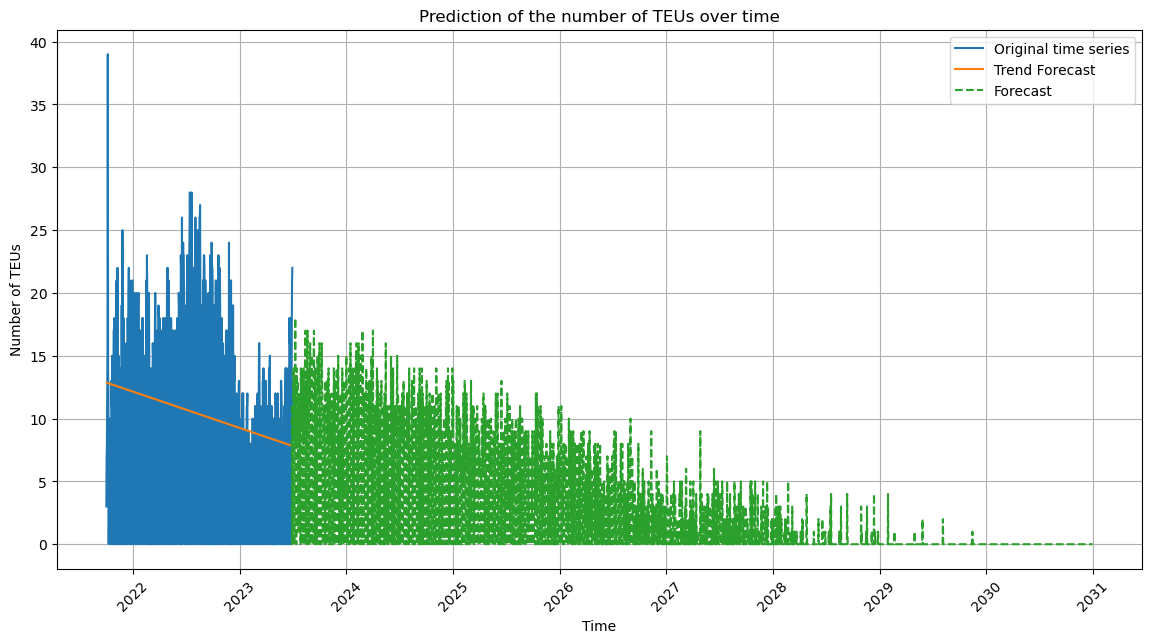

In [26]:
# Isolar os parametros da decomposição sazonal
trend_road = result_road.trend.dropna()
seasonal_road = result_road.seasonal.dropna()[:7]  # Sazonalidade de 7 dias
residuals_road = result_road.resid.dropna()

# Preparar os dados para a regressão linear
X = np.arange(len(trend_road)).reshape(-1, 1)
y = trend_road.values

# Ajustar a regressão linear
model = LinearRegression()
model.fit(X, y)

# Fazer previsões para a tendência usando os dados
y_pred = model.predict(X)

# Obter os coeficientes da regressão linear
m = model.coef_[0]
b = model.intercept_

# Exibir a expressão da regressão linear
print(f'Expressão da regressão linear: y = {m:.4f}x + {b:.4f}')

# Calcular a última data dos seus dados conhecidos
last_known_date = trend_road.index[-1]

# Definir a data de fim da previsão
end_date_2030 = pd.Timestamp('2030-12-31')

# Calcular o número de dias até a última data dos dados
days_until_2030 = (end_date_2030 - last_known_date).days

# Prever a tendência para um ano depois do fim dos dados
X_future = np.arange(len(trend_road), len(trend_road) + days_until_2030).reshape(-1, 1)
y_future = model.predict(X_future)
y_full_pred = y_future

# Adicionar a sazonalidade
seasonal_repeated = np.tile(seasonal_road, len(y_full_pred) // 7 + 1)[:len(y_full_pred)]
y_full_pred_with_seasonal = y_full_pred + seasonal_repeated

# Adicionar ruído baseado nos resíduos históricos e limitar o ruído a 2 desvios padrão da média
noise = np.random.choice(residuals_road, size=len(y_full_pred), replace=True)
noise = np.clip(noise, 
                a_min=residuals_road.mean() - 2 * residuals_road.std(), 
                a_max=residuals_road.mean() + 2 * residuals_road.std())
y_full_pred_with_noise = y_full_pred_with_seasonal + noise

# Garantir que os valores negativos são ajustados para zero
y_full_pred_with_noise = np.maximum(y_full_pred_with_noise, 0)
# Arredondar os valores para inteiros
y_full_pred_with_noise = np.round(y_full_pred_with_noise)
#print(y_full_pred_with_noise)

# Preparar a série temporal completa com as previsões
dates_full = pd.date_range(start=last_known_date + pd.Timedelta(days=1), periods=len(y_full_pred_with_noise), freq='D')
pred_series = pd.Series(y_full_pred_with_noise, index=dates_full)

# Plotar a série temporal original e a previsão
plt.figure(figsize=(14, 7))
plt.plot(serie_chegada_road, label='Original time series')
plt.plot(trend_road.index, model.predict(X), label='Trend Forecast')
plt.plot(pred_series.loc[trend_road.index[-1] + pd.Timedelta(days=1):], label='Forecast', linestyle='--')
plt.title('Prediction of the number of TEUs over time')
plt.xlabel('Time')
plt.ylabel('Number of TEUs')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

## Forecast Road Baseline Adjusted

Expressão da regressão linear: y = -0.0079x + 12.8425


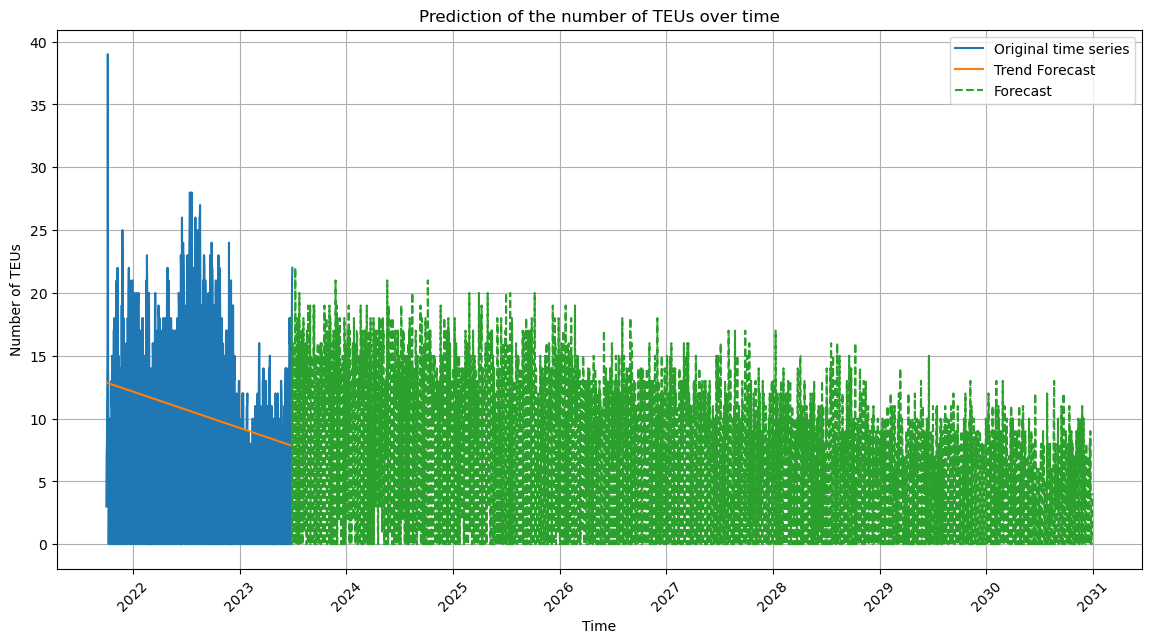

In [27]:
# Isolar os parametros da decomposição sazonal
trend_road = result_road.trend.dropna()
seasonal_road = result_road.seasonal.dropna()[:7]  # Sazonalidade de 7 dias
residuals_road = result_road.resid.dropna()

# Preparar os dados para a regressão linear
X = np.arange(len(trend_road)).reshape(-1, 1)
y = trend_road.values

# Ajustar a regressão linear
model = LinearRegression()
model.fit(X, y)

# Fazer previsões para a tendência usando os dados
y_pred = model.predict(X)

# Obter os coeficientes da regressão linear
m = model.coef_[0]
b = model.intercept_

# Exibir a expressão da regressão linear
print(f'Expressão da regressão linear: y = {m:.4f}x + {b:.4f}')

# Calcular a última data dos seus dados conhecidos
last_known_date = trend_road.index[-1]

# Definir a data de fim da previsão
end_date_2030 = pd.Timestamp('2030-12-31')

# Calcular o número de dias até a última data dos dados
days_until_2030 = (end_date_2030 - last_known_date).days
# Prever a tendência para 2030
X_future = np.arange(len(trend_road), len(trend_road) + days_until_2030).reshape(-1, 1)
y_future = model.predict(X_future)

# Ajustar o declive manualmente
adjusted_m = -0.0035  # Definir o declive manualmente
y_future_adjusted = adjusted_m * np.arange(len(trend_road), len(trend_road) + days_until_2030).reshape(-1, 1) + b
# Flatten para garantir compatibilidade dimensional
y_future_adjusted = y_future_adjusted.flatten()
y_full_pred =  y_future_adjusted

# Adicionar a sazonalidade
seasonal_repeated = np.tile(seasonal_road, len(y_full_pred) // 7 + 1)[:len(y_full_pred)]
y_full_pred_with_seasonal = y_full_pred + seasonal_repeated

# Adicionar ruído baseado nos resíduos históricos e limitar o ruído a 2 desvios padrão da média
noise = np.random.choice(residuals_road, size=len(y_full_pred), replace=True)
noise = np.clip(noise, 
                a_min=residuals_road.mean() - 2 * residuals_road.std(), 
                a_max=residuals_road.mean() + 2 * residuals_road.std())
y_full_pred_with_noise = y_full_pred_with_seasonal + noise

# Garantir que os valores negativos são ajustados para zero
y_full_pred_with_noise = np.maximum(y_full_pred_with_noise, 0)
# Arredondar os valores para inteiros
y_full_pred_with_noise = np.round(y_full_pred_with_noise)

# Preparar a série temporal completa com as previsões
dates_full = pd.date_range(start=last_known_date + pd.Timedelta(days=1), periods=len(y_full_pred_with_noise), freq='D')
pred_series = pd.Series(y_full_pred_with_noise, index=dates_full)

# Plotar a série temporal original e a previsão
plt.figure(figsize=(14, 7))
plt.plot(serie_chegada_road, label='Original time series')
plt.plot(trend_road.index, model.predict(X), label='Trend Forecast')
plt.plot(pred_series.loc[trend_road.index[-1] + pd.Timedelta(days=1):], label='Forecast', linestyle='--')
plt.title('Prediction of the number of TEUs over time')
plt.xlabel('Time')
plt.ylabel('Number of TEUs')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

## Road Forecast baseline e growth scenarios

In [28]:
def run_simulation_road(
    result, 
    forced_slope: float = -0.0035,
    n_sims: int = 500, 
    growth_rate: float = 0.0,
    noise_dist: str = 'empirical',
    noise_scale: float = 1.0,):

    trend     = result.trend.dropna()
    seasonal  = result.seasonal.dropna()[:7]
    residuals = result.resid.dropna()
    resid_std = residuals.std()
    
    #Adjust and intercept for the trend
    X_hist = np.arange(len(trend)).reshape(-1,1)
    b_orig = LinearRegression().fit(X_hist, trend.values).intercept_
    
    last_date = trend.index[-1]
    end_2030  = pd.Timestamp('2030-12-31')
    days      = (end_2030 - last_date).days
    Xf        = np.arange(len(trend), len(trend)+days)  # vetor 1D
    dates     = pd.date_range(start=last_date+pd.Timedelta(days=1),
                              periods=days, freq='D')
    
    trend_base = forced_slope * Xf + b_orig

    #Offset constant equal to 5.0
    y_offset = 5.0
    frac_year    = (dates - last_date).days / 365.0
    growth_off   = y_offset * ((1 + growth_rate)**frac_year - 1)

    trend_with_growth = trend_base + growth_off

    seasonal_rep = np.tile(seasonal, len(trend_with_growth)//7 + 1)[:len(trend_with_growth)]

    #Monte Carlo
    sims = []
    for _ in range(n_sims):
        if noise_dist == 'empirical':
            noise = np.random.choice(residuals, size=len(trend_with_growth), replace=True)
        else:
            sigma = resid_std * noise_scale
            noise = np.random.normal(0.0, sigma, size=len(trend_with_growth))

        y_sim = trend_with_growth + seasonal_rep + noise
        sims.append(np.round(np.maximum(y_sim, 0)))

    df = pd.DataFrame(sims).T
    df.index = dates
    return df

Total TEUs per month (2030) - baseline:
2030-01-31    145.0
2030-02-28    129.0
2030-03-31    140.0
2030-04-30    140.0
2030-05-31    129.0
2030-06-30    130.0
2030-07-31    136.0
2030-08-31    121.0
2030-09-30    125.0
2030-10-31    124.0
2030-11-30    117.0
2030-12-31    127.0
Freq: M, dtype: float64
Average TEUs for 2030 (baseline): 1557.72
Standard deviation of TEUs for 2030 (baseline): 50.85


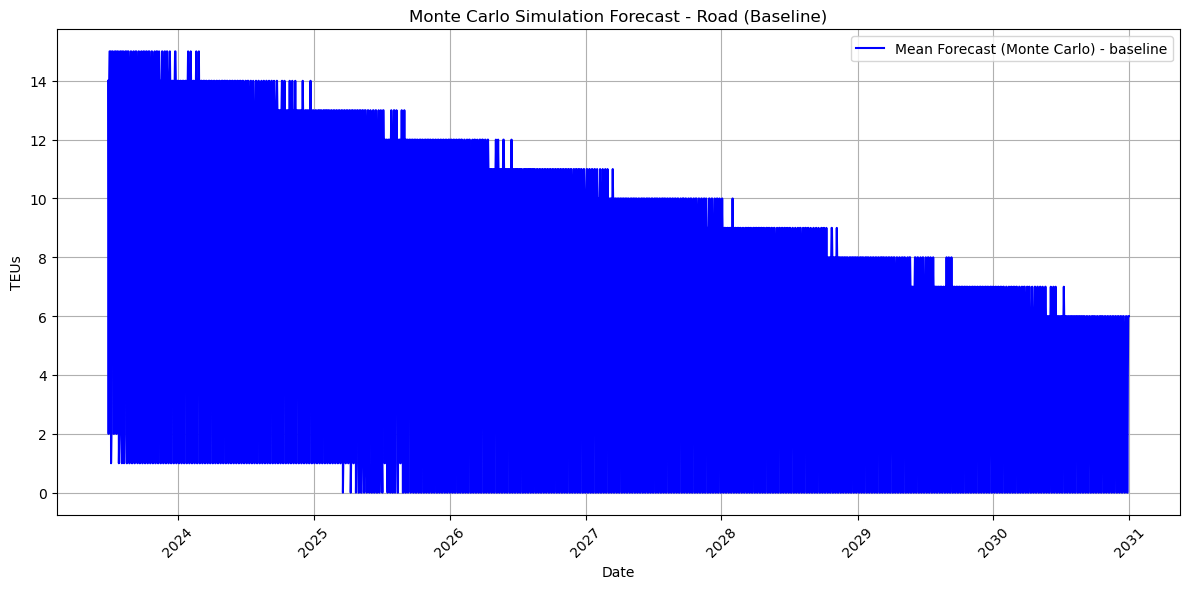

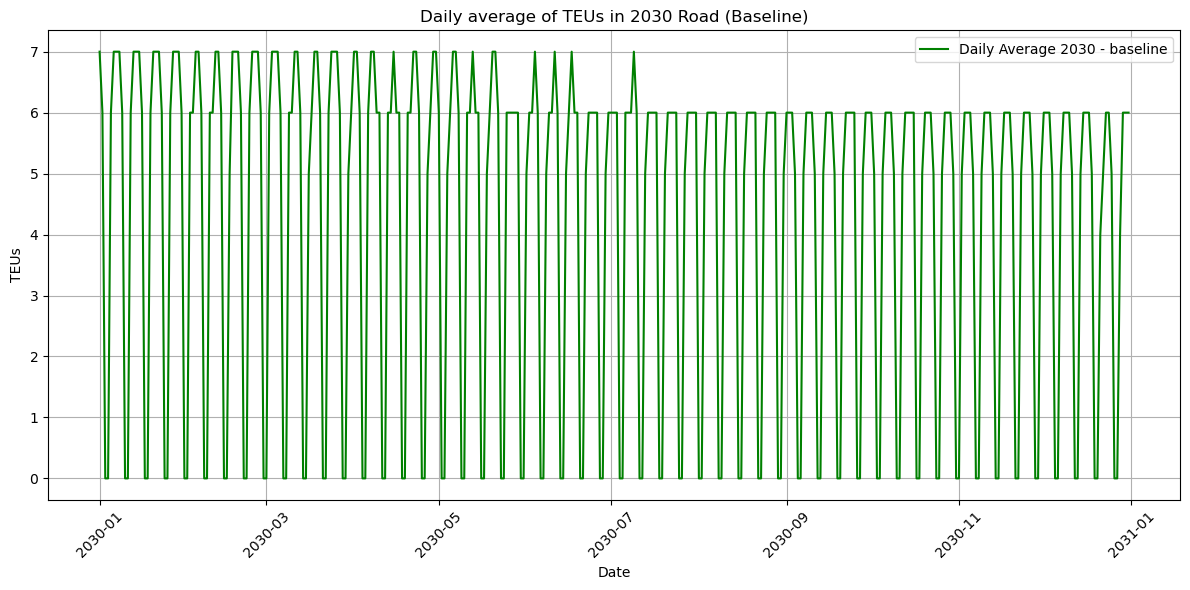

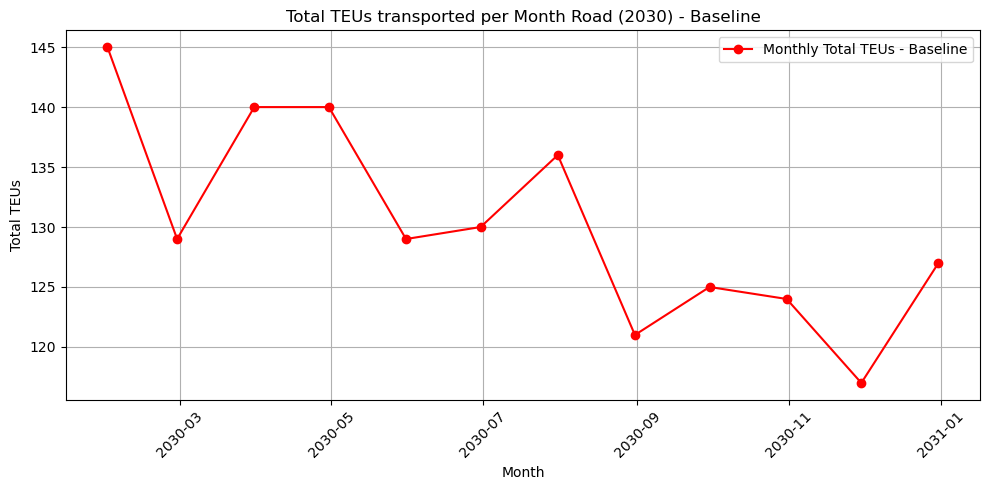

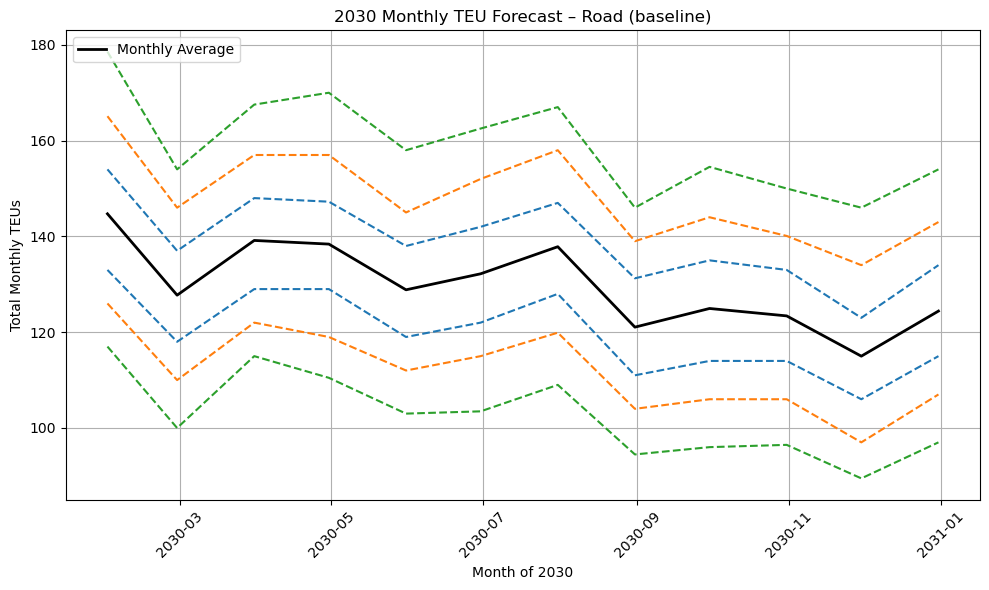

Total of TEUs per month (2030) - with growth:
2030-01-31    168.0
2030-02-28    151.0
2030-03-31    162.0
2030-04-30    158.0
2030-05-31    146.0
2030-06-30    155.0
2030-07-31    159.0
2030-08-31    140.0
2030-09-30    149.0
2030-10-31    145.0
2030-11-30    136.0
2030-12-31    153.0
Freq: M, dtype: float64
Average TEUs for 2030 (with growth): 1825.85
Standard deviation of TEUs for 2030 (with growth): 52.26


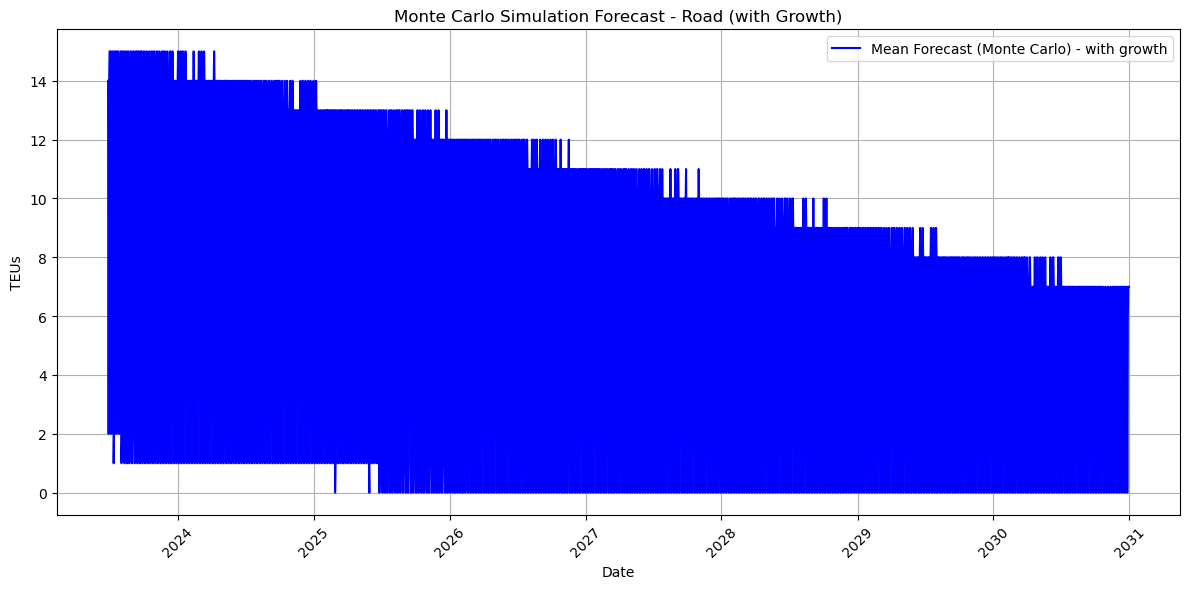

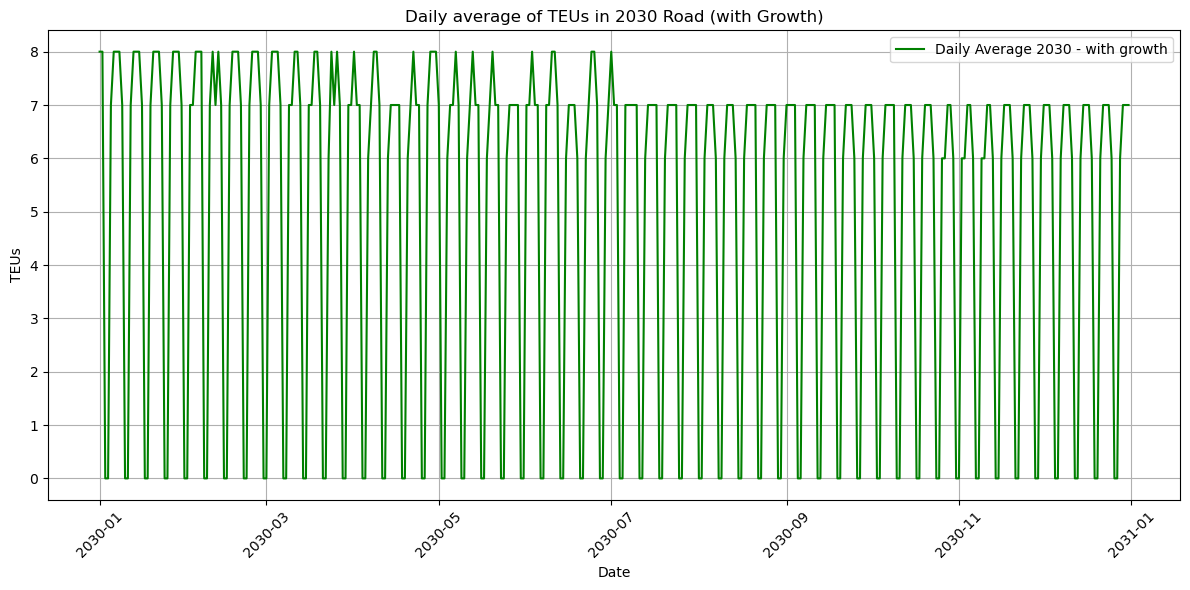

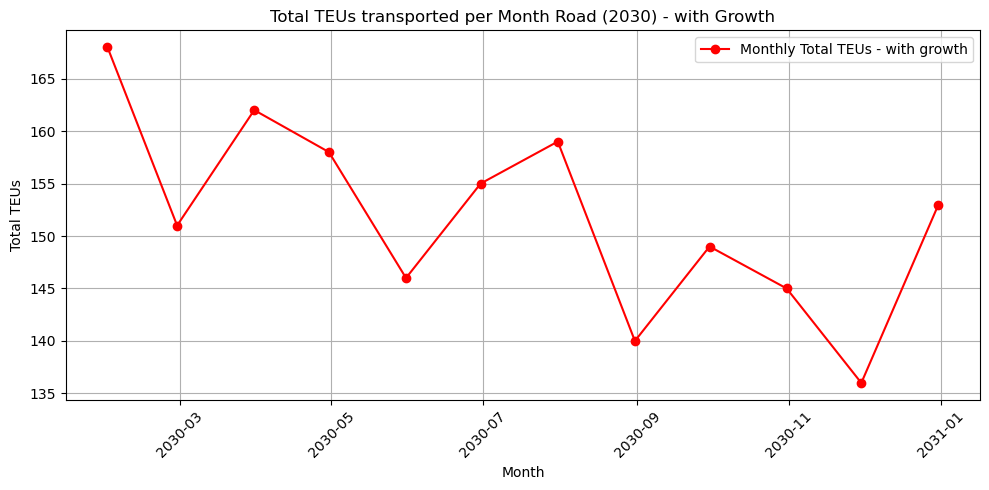

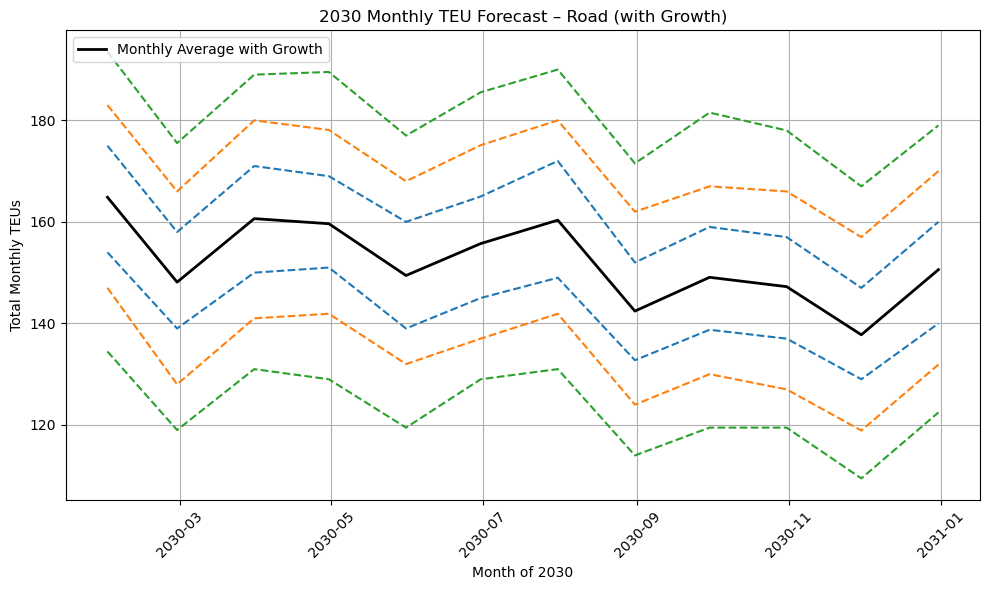

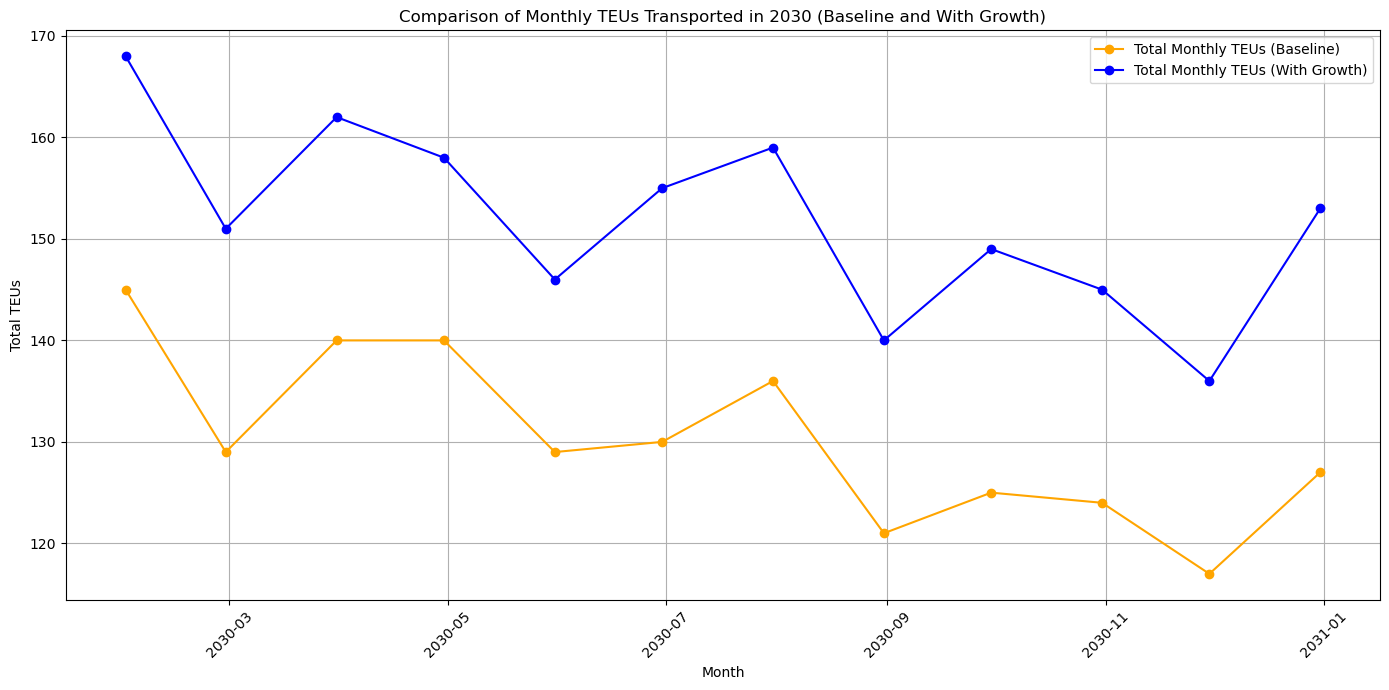

Values WITH growth and noise scale 1: 2030-01-31    164.0
2030-02-28    148.0
2030-03-31    160.0
2030-04-30    157.0
2030-05-31    145.0
2030-06-30    148.0
2030-07-31    155.0
2030-08-31    141.0
2030-09-30    145.0
2030-10-31    145.0
2030-11-30    138.0
2030-12-31    150.0
Freq: M, dtype: float64
Average TEUs for 2030 with growth and noise scale 1: 1793.12
Std TEUs for 2030 with growth and noise scale 1: 62.14


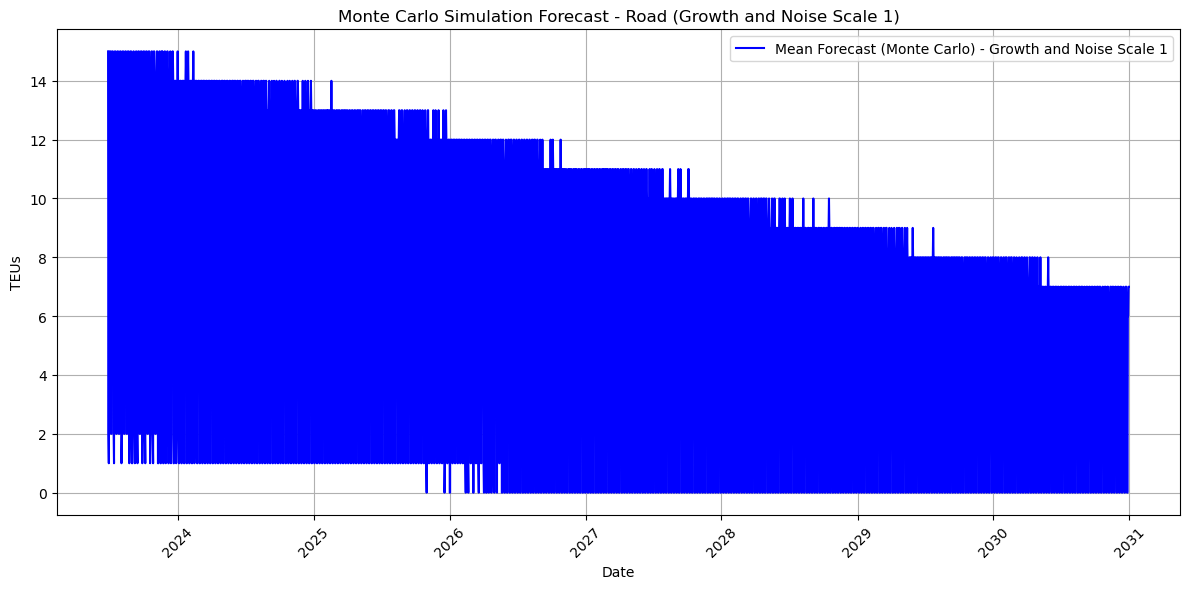

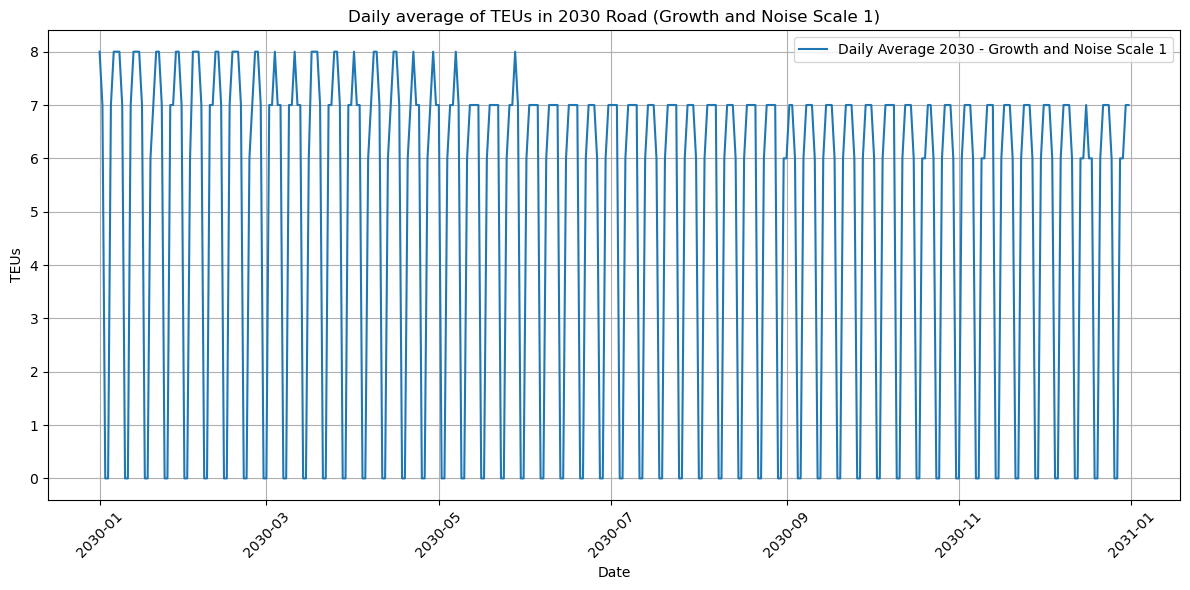

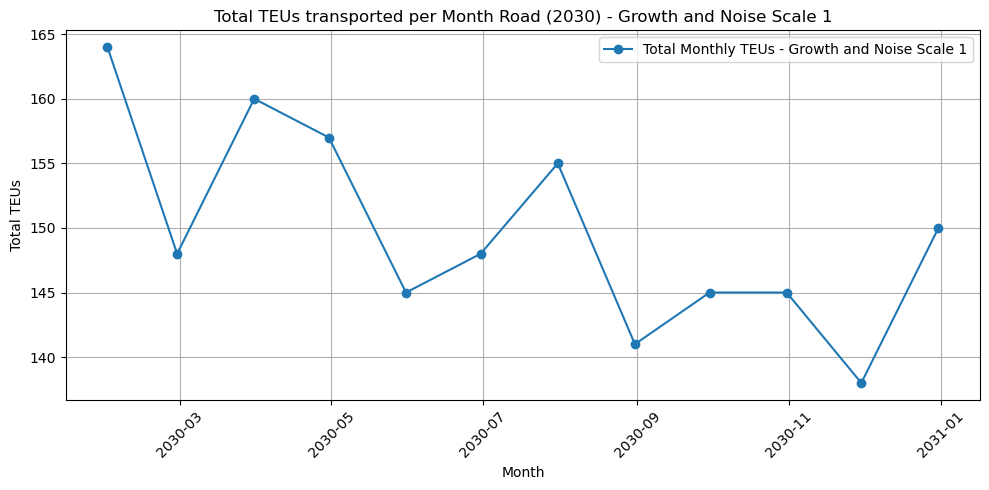

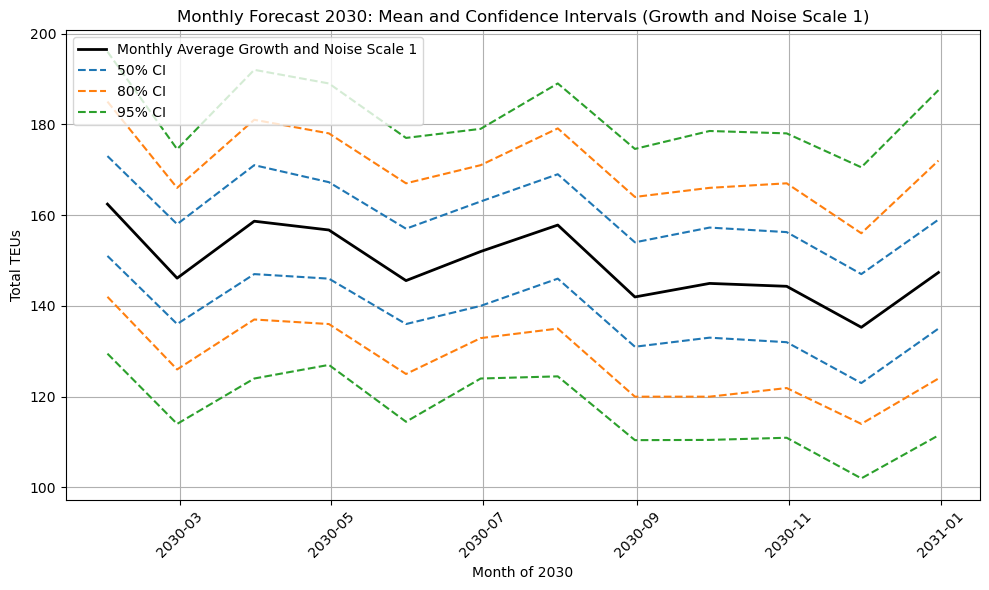

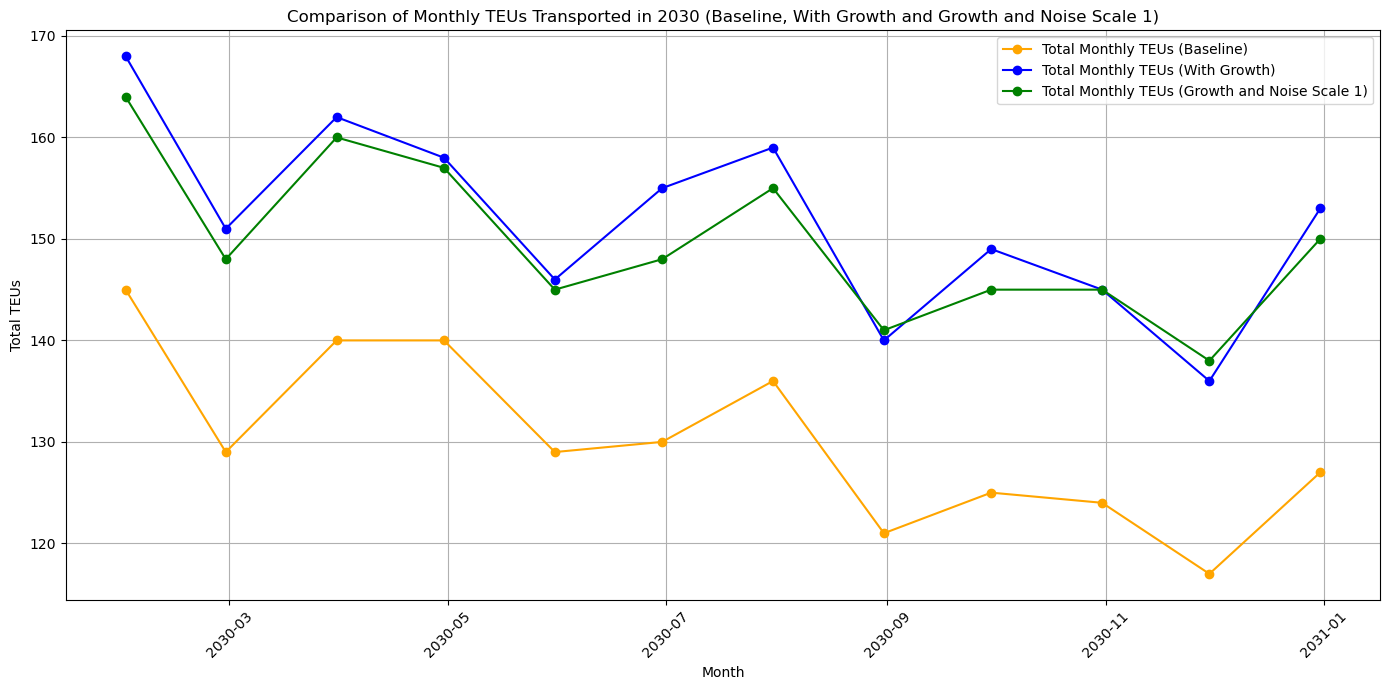

Values WITH growth and noise scale 2: 2030-01-31    184.0
2030-02-28    165.0
2030-03-31    180.0
2030-04-30    178.0
2030-05-31    168.0
2030-06-30    177.0
2030-07-31    179.0
2030-08-31    162.0
2030-09-30    169.0
2030-10-31    171.0
2030-11-30    153.0
2030-12-31    163.0
Freq: M, dtype: float64
Average TEUs for 2030 with growth and noise scale 2: 2021.44
Std TEUs for 2030 with growth and noise scale 2: 104.77


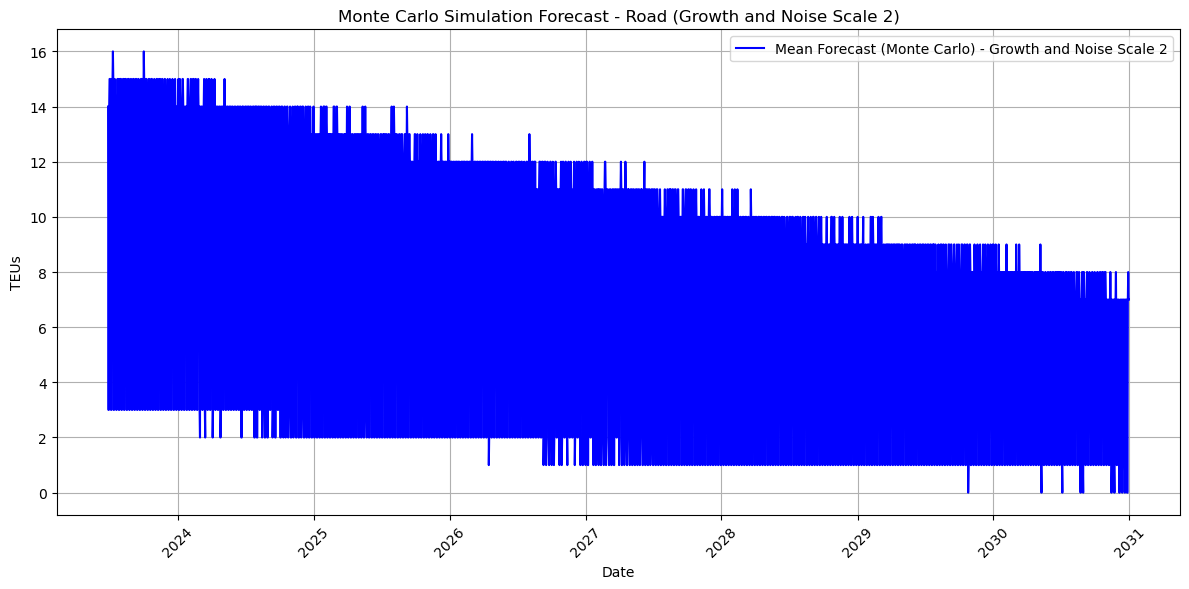

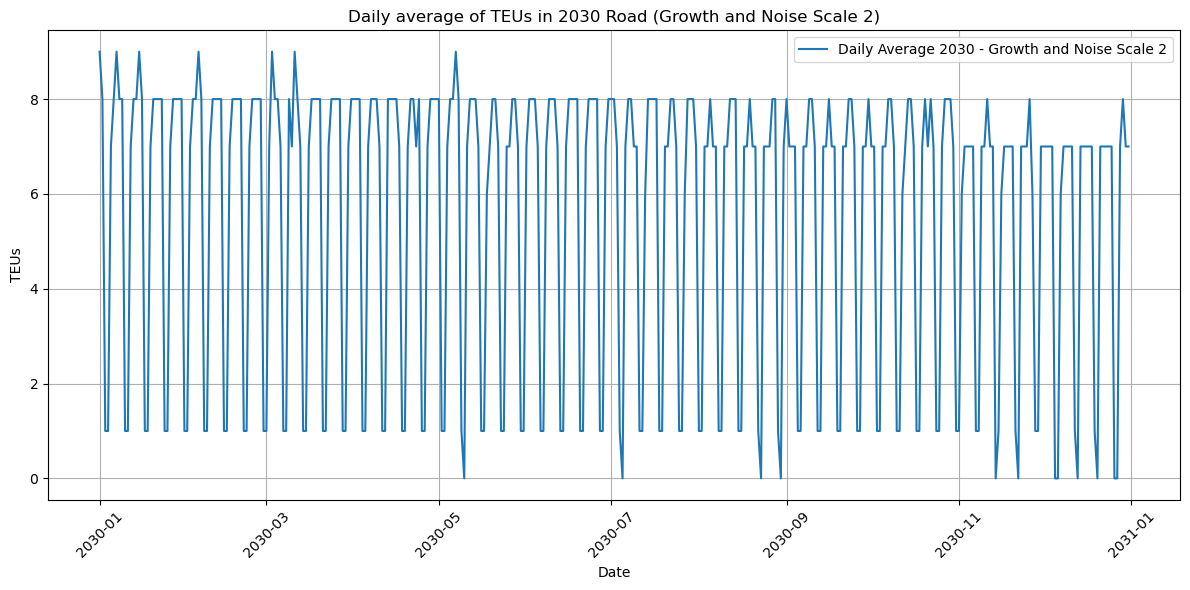

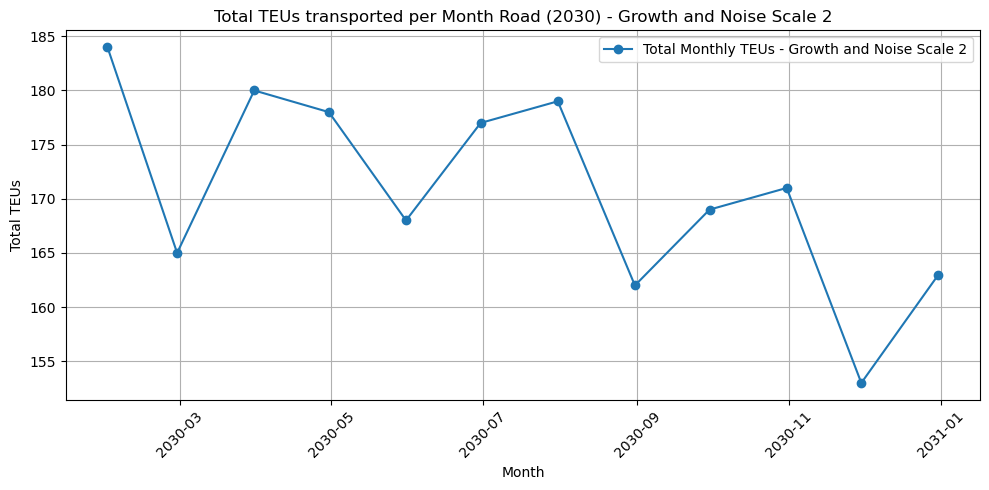

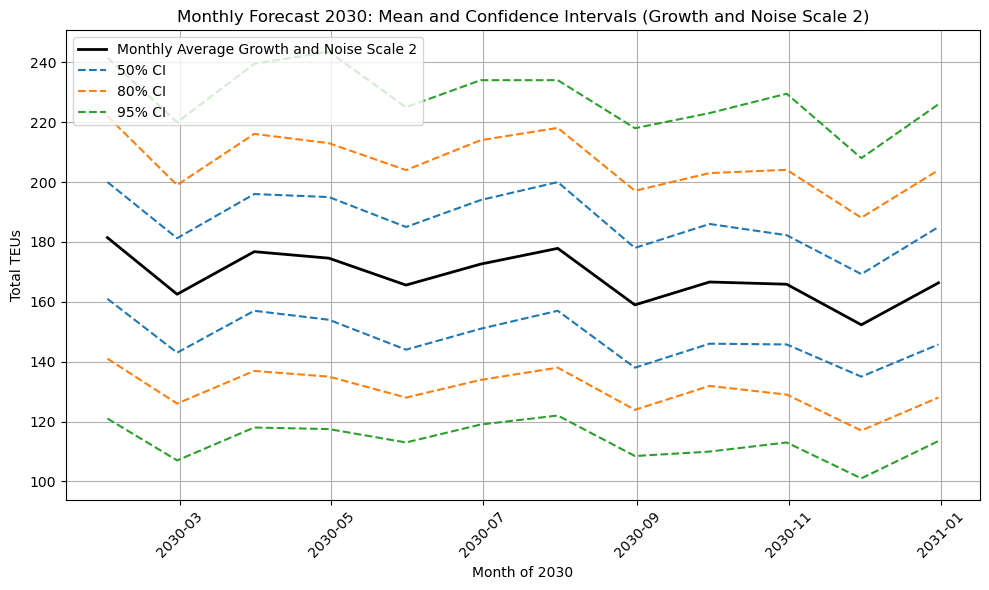

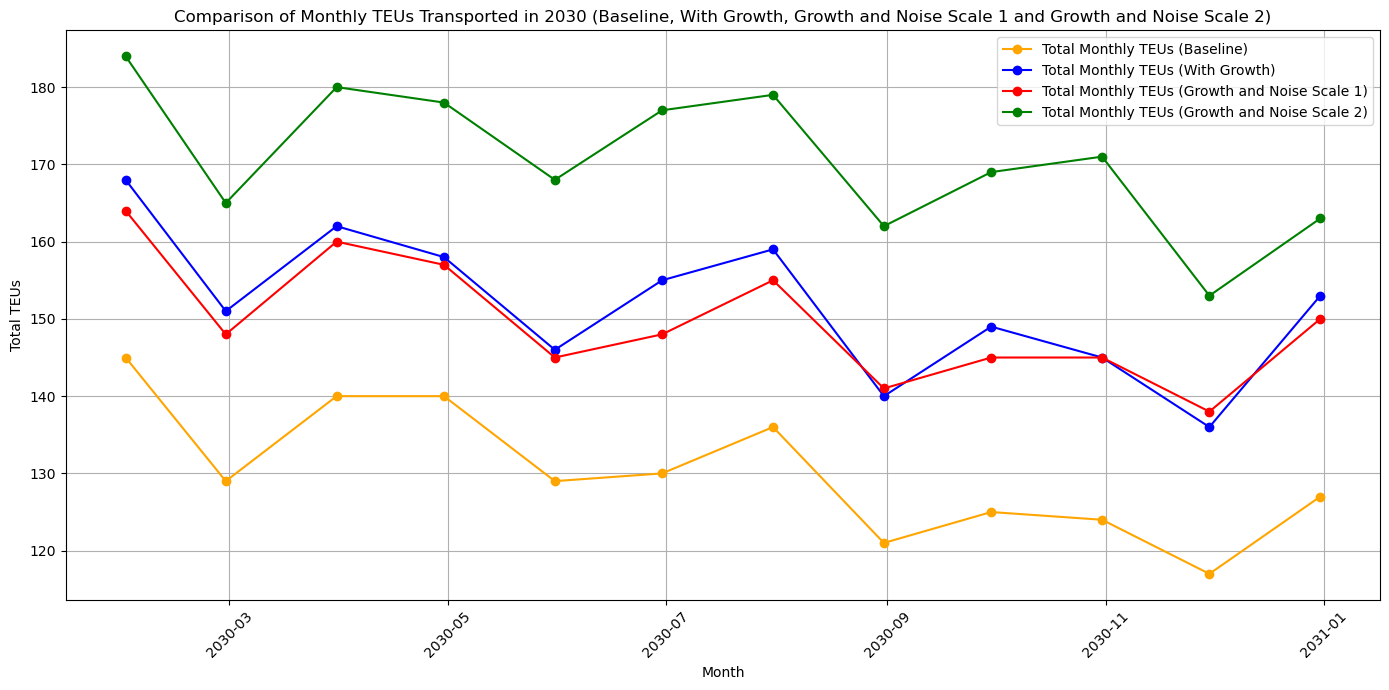

Values WITH growth and noise scale 3: 2030-01-31    218.0
2030-02-28    197.0
2030-03-31    214.0
2030-04-30    209.0
2030-05-31    204.0
2030-06-30    208.0
2030-07-31    213.0
2030-08-31    195.0
2030-09-30    198.0
2030-10-31    199.0
2030-11-30    188.0
2030-12-31    202.0
Freq: M, dtype: float64
Average TEUs for 2030 with growth and noise scale 3: 2427.79
Std TEUs for 2030 with growth and noise scale 3: 146.94


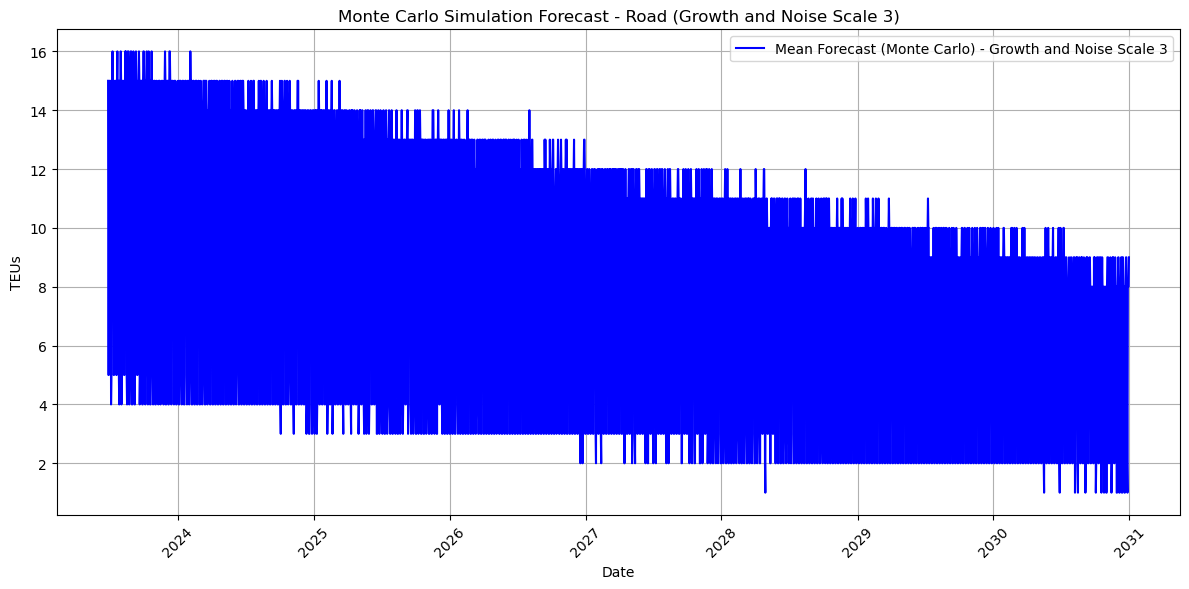

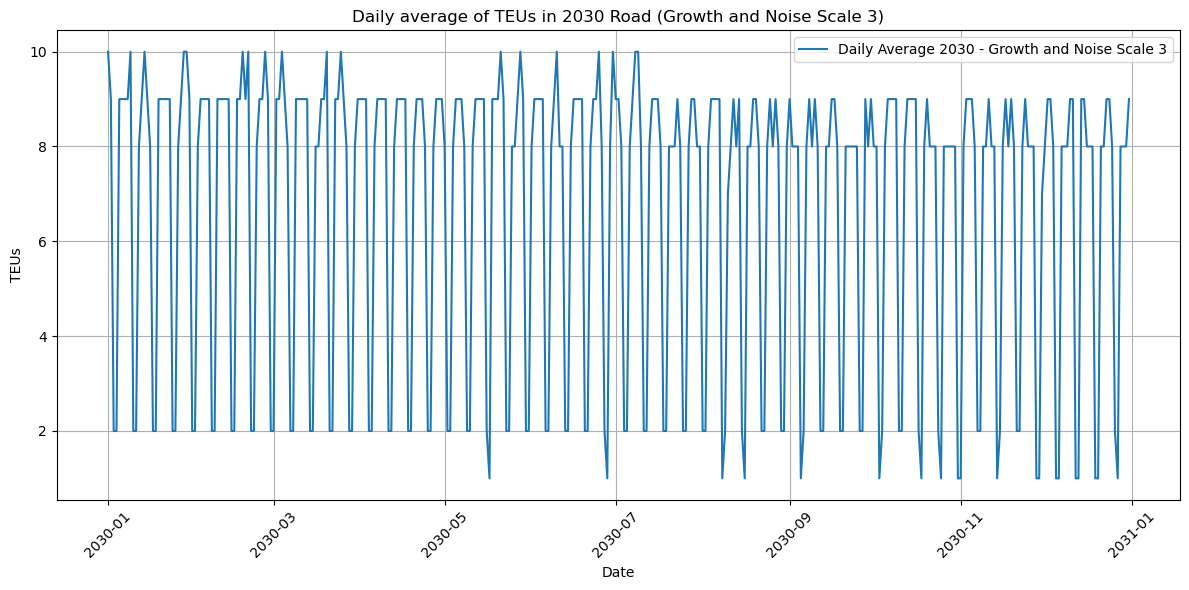

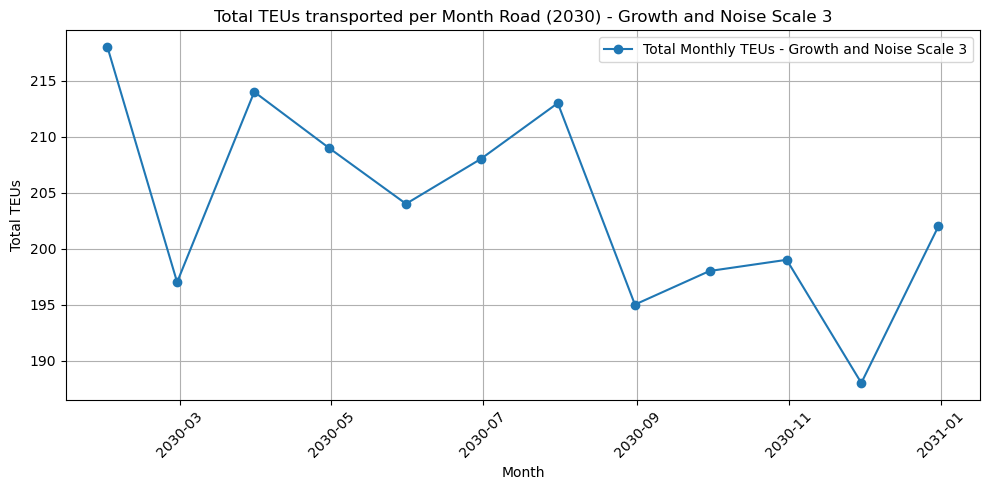

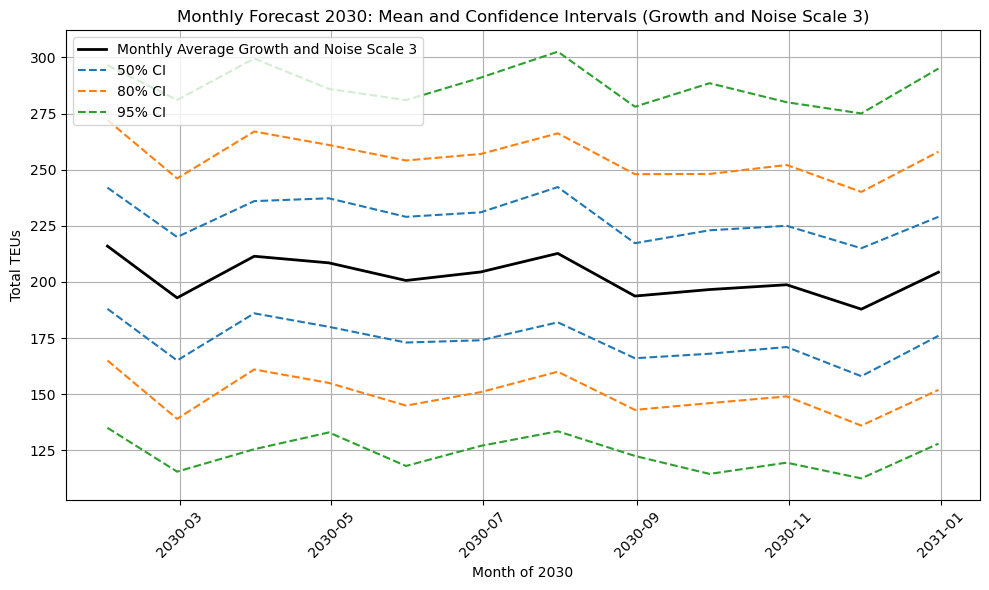

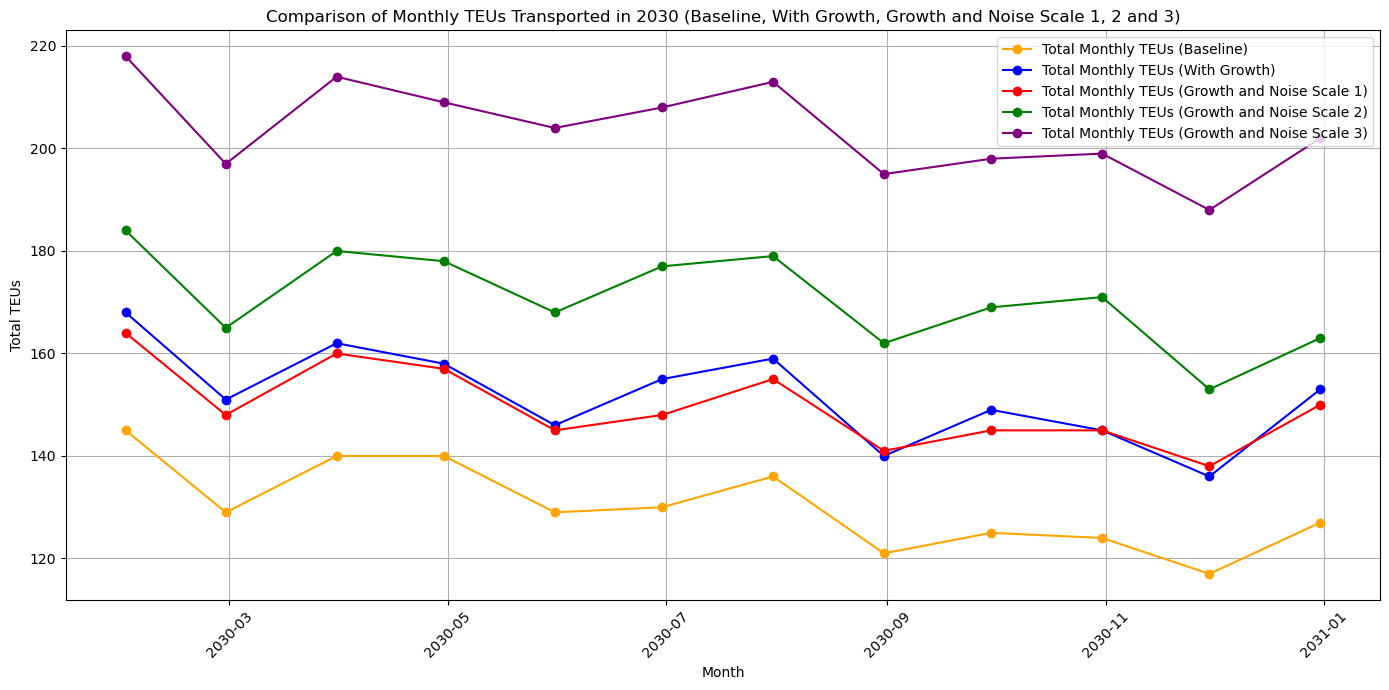

Values WITH growth and noise scale 4: 2030-01-31    251.0
2030-02-28    225.0
2030-03-31    245.0
2030-04-30    244.0
2030-05-31    239.0
2030-06-30    242.0
2030-07-31    250.0
2030-08-31    236.0
2030-09-30    237.0
2030-10-31    235.0
2030-11-30    229.0
2030-12-31    243.0
Freq: M, dtype: float64
Average TEUs for 2030 with growth and noise scale 4: 2875.60
Std TEUs for 2030 with growth and noise scale 4: 182.17


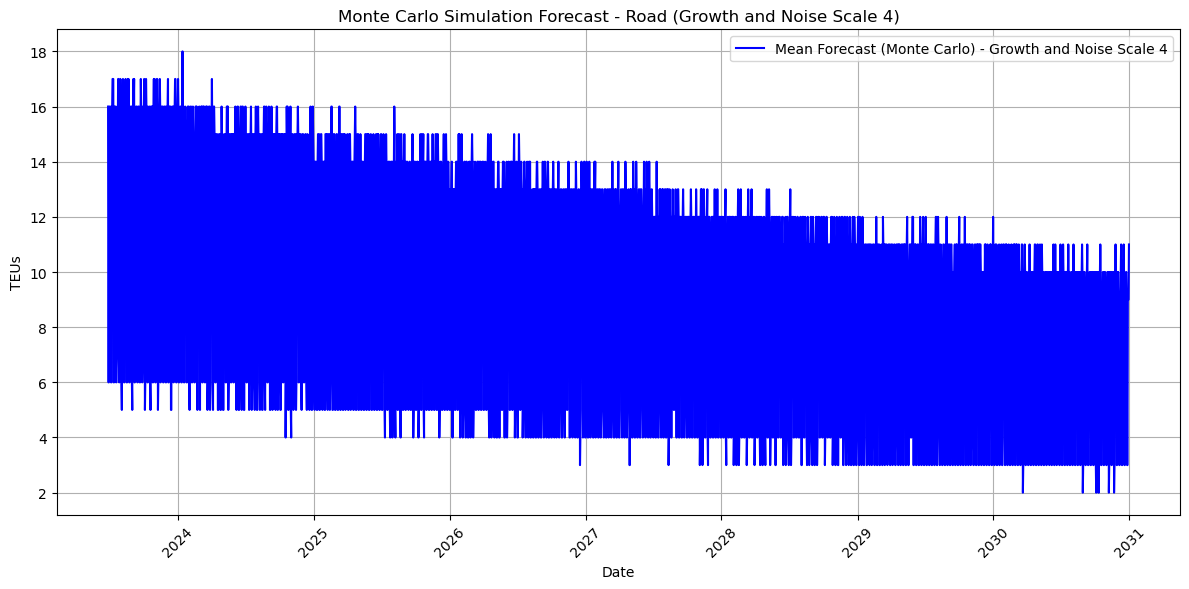

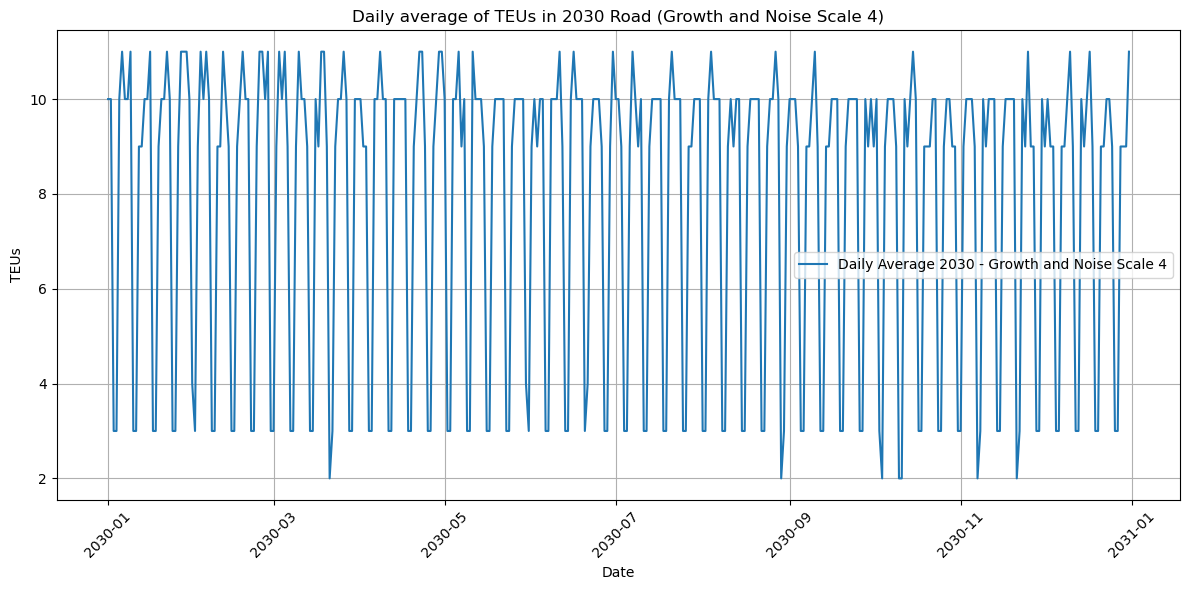

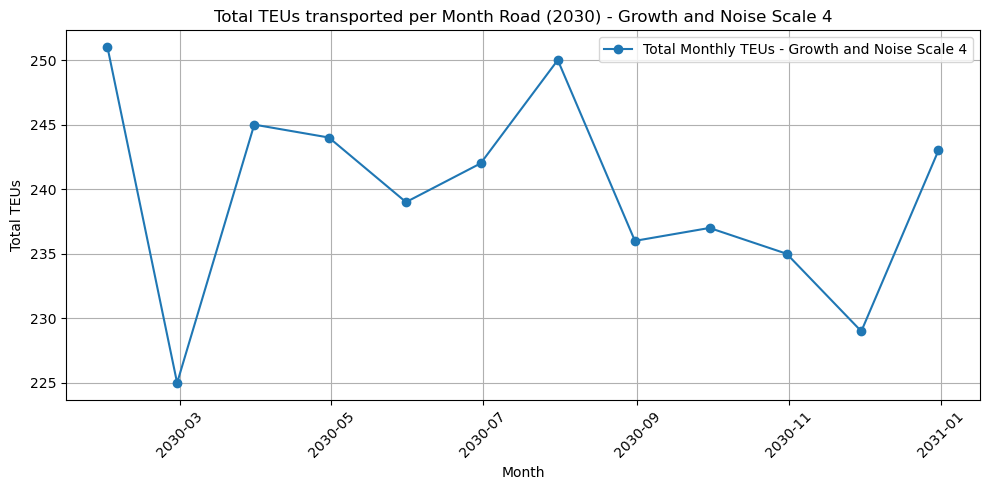

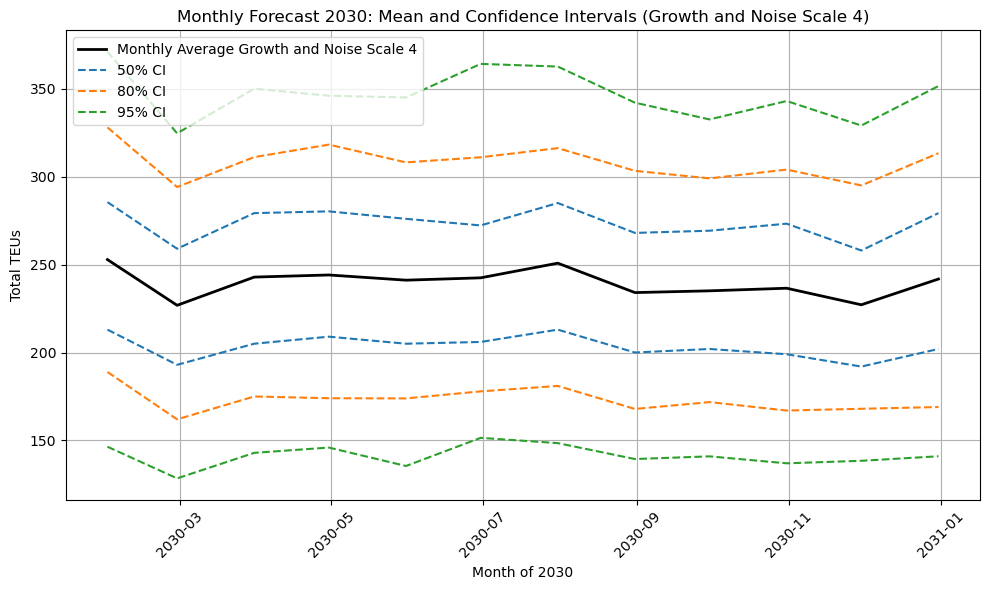

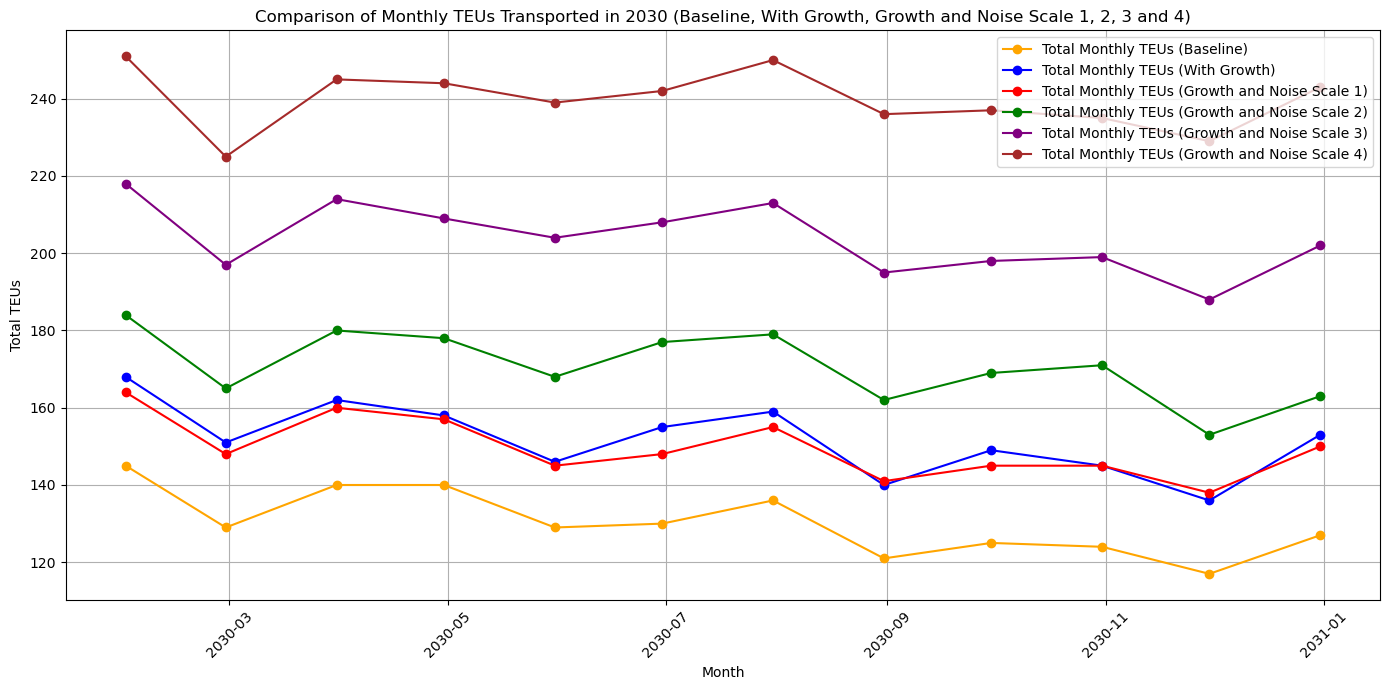

In [29]:
df_road_base = run_simulation_road(result_road, forced_slope=-0.0035, n_sims=500, growth_rate=0.0, noise_dist='empirical', noise_scale=1.0,) 
df_road_growth = run_simulation_road(result_road, forced_slope=-0.0035, n_sims=500, growth_rate=0.028, noise_dist='empirical', noise_scale=1.0,)

df_road_growth_norm1 = run_simulation_road(result_road, forced_slope=-0.0035, n_sims=500, growth_rate=0.028, noise_dist='normal', noise_scale=1.0,)
df_road_growth_norm2 = run_simulation_road(result_road, forced_slope=-0.0035, n_sims=500, growth_rate=0.028, noise_dist='normal', noise_scale=2.0,)
df_road_growth_norm3 = run_simulation_road(result_road, forced_slope=-0.0035, n_sims=500, growth_rate=0.028, noise_dist='normal', noise_scale=3.0,)
df_road_growth_norm4 = run_simulation_road(result_road, forced_slope=-0.0035, n_sims=500, growth_rate=0.028, noise_dist='normal', noise_scale=4.0,)

#Select year 2030
simulations_2030 = df_road_base.loc['2030-01-01':'2030-12-31']
monthly_sims = simulations_2030.resample('M').sum() 
simulations_2030_growth = df_road_growth.loc['2030-01-01':'2030-12-31']
monthly_sims_growth = simulations_2030_growth.resample('M').sum() 
simulations_2030_growth_norm1 = df_road_growth_norm1.loc['2030-01-01':'2030-12-31']
monthly_sims_growth_norm1 = simulations_2030_growth_norm1.resample('M').sum()
simulations_2030_growth_norm2 = df_road_growth_norm2.loc['2030-01-01':'2030-12-31']
monthly_sims_growth_norm2 = simulations_2030_growth_norm2.resample('M').sum()
simulations_2030_growth_norm3 = df_road_growth_norm3.loc['2030-01-01':'2030-12-31']
monthly_sims_growth_norm3 = simulations_2030_growth_norm3.resample('M').sum()
simulations_2030_growth_norm4 = df_road_growth_norm4.loc['2030-01-01':'2030-12-31']
monthly_sims_growth_norm4 = simulations_2030_growth_norm4.resample('M').sum()


# Stats for the year 2030
monthly_mean   = monthly_sims.mean(axis=1)
lower50, upper50 = monthly_sims.quantile(0.25, axis=1), monthly_sims.quantile(0.75, axis=1)
lower80, upper80 = monthly_sims.quantile(0.10, axis=1), monthly_sims.quantile(0.90, axis=1)
lower95, upper95 = monthly_sims.quantile(0.025,axis=1), monthly_sims.quantile(0.975,axis=1)

# Daily mean for all simulations
mean_forecast = np.round(df_road_base.mean(axis=1))

# Daily mean for 2030
mean_daily_2030 = np.round(simulations_2030.mean(axis=1))

# Total TEUs per month (sum of daily mean values)
monthly_total_2030 = np.round(mean_daily_2030.resample('M').sum())
print("Total TEUs per month (2030) - baseline:")
print(monthly_total_2030)

# Distribution for the year
teus_2030_simulations = simulations_2030.sum(axis=0).values
print(f"Average TEUs for 2030 (baseline): {teus_2030_simulations.mean():.2f}")
print(f"Standard deviation of TEUs for 2030 (baseline): {teus_2030_simulations.std():.2f}")

# Plot the mean of all simulations for the entire period
plt.figure(figsize=(12, 6))
plt.plot(mean_forecast.index, mean_forecast.values, label='Mean Forecast (Monte Carlo) - baseline', color='blue')
plt.title('Monte Carlo Simulation Forecast - Road (Baseline)')
plt.xlabel('Date')
plt.ylabel('TEUs')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot the daily mean for 2030
plt.figure(figsize=(12, 6))
plt.plot(mean_daily_2030.index, mean_daily_2030.values, label='Daily Average 2030 - baseline', color='green')
plt.title('Daily average of TEUs in 2030 Road (Baseline)')
plt.xlabel('Date')
plt.ylabel('TEUs')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot the total monthly for 2030
plt.figure(figsize=(10, 5))
plt.plot(monthly_total_2030.index, monthly_total_2030.values, marker='o', label='Monthly Total TEUs - Baseline', color='red')
plt.title("Total TEUs transported per Month Road (2030) - Baseline")
plt.xlabel("Month")
plt.ylabel("Total TEUs")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot: mean + CI dashed lines
fig, ax = plt.subplots(figsize=(10,6))

# average line
ax.plot(monthly_mean.index, monthly_mean.values,
        color='black', linewidth=2, label='Monthly Average')

# confidence bands: draw only the lower limit in the legends
levels = [
    (lower50, upper50, '50% CI',     'C0'),
    (lower80, upper80, '80% CI',     'C1'),
    (lower95, upper95, '95% CI',     'C2'),
]

for lower, upper, label, color in levels:
    ax.plot(lower.index, lower.values, linestyle='--', color=color)
    ax.plot(upper.index, upper.values, linestyle='--', color=color)

ax.set_title('2030 Monthly TEU Forecast – Road (baseline)')
ax.set_xlabel('Month of 2030')
ax.set_ylabel('Total Monthly TEUs')
ax.legend(loc='upper left')
ax.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


monthly_mean_growth   = monthly_sims_growth.mean(axis=1)
lower50_growth, upper50_growth = monthly_sims_growth.quantile(0.25, axis=1), monthly_sims_growth.quantile(0.75, axis=1)
lower80_growth, upper80_growth = monthly_sims_growth.quantile(0.10, axis=1), monthly_sims_growth.quantile(0.90, axis=1)
lower95_growth, upper95_growth = monthly_sims_growth.quantile(0.025,axis=1), monthly_sims_growth.quantile(0.975,axis=1)

mean_forecast_growth = np.round(df_road_growth.mean(axis=1))

mean_daily_2030_growth = np.round(simulations_2030_growth.mean(axis=1))

monthly_total_2030_growth = np.round(mean_daily_2030_growth.resample('M').sum())
print("Total of TEUs per month (2030) - with growth:")
print(monthly_total_2030_growth)

teus_2030_simulations_growth = simulations_2030_growth.sum(axis=0).values
print(f"Average TEUs for 2030 (with growth): {teus_2030_simulations_growth.mean():.2f}")
print(f"Standard deviation of TEUs for 2030 (with growth): {teus_2030_simulations_growth.std():.2f}")

plt.figure(figsize=(12, 6))
plt.plot(mean_forecast_growth.index, mean_forecast_growth.values, label='Mean Forecast (Monte Carlo) - with growth', color='blue')
plt.title('Monte Carlo Simulation Forecast - Road (with Growth)')
plt.xlabel('Date')
plt.ylabel('TEUs')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
# 3.2 Plot da média diária para 2030
plt.figure(figsize=(12, 6))
plt.plot(mean_daily_2030_growth.index, mean_daily_2030_growth.values, label='Daily Average 2030 - with growth', color='green')
plt.title('Daily average of TEUs in 2030 Road (with Growth)')
plt.xlabel('Date')
plt.ylabel('TEUs')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
# 3.3 Plot do total mensal para 2030
plt.figure(figsize=(10, 5))
plt.plot(monthly_total_2030_growth.index, monthly_total_2030_growth.values, marker='o', label='Monthly Total TEUs - with growth', color='red')
plt.title("Total TEUs transported per Month Road (2030) - with Growth")
plt.xlabel("Month")
plt.ylabel("Total TEUs")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
# 4) Plot: média + CI tracejadas
fig, ax = plt.subplots(figsize=(10,6))
# linha média
ax.plot(monthly_mean_growth.index, monthly_mean_growth.values,
        color='black', linewidth=2, label='Monthly Average with Growth')
# bandas de confiança: desenha apenas o limite inferior nas legendas
levels_growth = [
    (lower50_growth, upper50_growth, '50% CI',     'C0'),
    (lower80_growth, upper80_growth, '80% CI',     'C1'),
    (lower95_growth, upper95_growth, '95% CI',     'C2'),
]
for lower, upper, label, color in levels_growth:
    ax.plot(lower.index, lower.values, linestyle='--', color=color)
    ax.plot(upper.index, upper.values, linestyle='--', color=color)
ax.set_title('2030 Monthly TEU Forecast – Road (with Growth)')
ax.set_xlabel('Month of 2030')
ax.set_ylabel('Total Monthly TEUs')
ax.legend(loc='upper left')
ax.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
# Comparar os resultados com com baseline e com crescimento
plt.figure(figsize=(14, 7))
plt.plot(monthly_total_2030.index, monthly_total_2030.values, marker='o', label='Total Monthly TEUs (Baseline)', color='orange')
plt.plot(monthly_total_2030_growth.index, monthly_total_2030_growth.values, marker='o', label='Total Monthly TEUs (With Growth)', color='blue')
plt.title("Comparison of Monthly TEUs Transported in 2030 (Baseline and With Growth)")
plt.xlabel("Month")
plt.ylabel("Total TEUs")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

monthly_sims_growth_norm1 = simulations_2030_growth_norm1.resample('M').sum()
monthly_mean_growth_norm1 = monthly_sims_growth_norm1.mean(axis=1)
monthly_lower95_growth_norm1, monthly_upper95_growth_norm1 = (
    monthly_sims_growth_norm1.quantile(0.025, axis=1),
    monthly_sims_growth_norm1.quantile(0.975, axis=1),
)
monthly_lower80_growth_norm1, monthly_upper80_growth_norm1 = (
    monthly_sims_growth_norm1.quantile(0.10, axis=1),
    monthly_sims_growth_norm1.quantile(0.90, axis=1),
)
monthly_lower50_growth_norm1, monthly_upper50_growth_norm1 = (
    monthly_sims_growth_norm1.quantile(0.25, axis=1),
    monthly_sims_growth_norm1.quantile(0.75, axis=1),
)
# Calcular a média diária (ou qualquer estatística) ao longo de todas as simulações
mean_forecast_growth_norm1 = np.round(df_road_growth_norm1.mean(axis=1))
# Média diária de cada dia arredondada (ao longo de todas as simulações)
mean_daily_2030_growth_norm1 = np.round(simulations_2030_growth_norm1.mean(axis=1))
# Total de TEUs por mês
monthly_total_2030_growth_norm1 = np.round(mean_daily_2030_growth_norm1.resample('M').sum())
# Printar o total de TEUs por mês
print(f"Values WITH growth and noise scale 1: {monthly_total_2030_growth_norm1}")
teus_2030_simulations_growth_norm1 = []  # Lista para armazenar o total anual de cada simulação
# Iterar sobre cada simulação (cada coluna do DataFrame)
for col in df_road_growth_norm1.columns:
    sim_series = df_road_growth_norm1[col]
    # Filtrar os dados de 2030 e somar para obter o total anual de TEUs
    teus_2030_growth_norm1 = sim_series["2030-01-01":"2030-12-31"].sum()
    teus_2030_simulations_growth_norm1.append(teus_2030_growth_norm1)
# Converter a lista para um array NumPy
teus_2030_simulations_growth_norm1 = np.array(teus_2030_simulations_growth_norm1)
print(f"Average TEUs for 2030 with growth and noise scale 1: {teus_2030_simulations_growth_norm1.mean():.2f}")
print(f"Std TEUs for 2030 with growth and noise scale 1: {teus_2030_simulations_growth_norm1.std():.2f}")
# Plotar a média das simulações para 2030
plt.figure(figsize=(12, 6))
plt.plot(mean_forecast_growth_norm1.index, mean_forecast_growth_norm1.values, label='Mean Forecast (Monte Carlo) - Growth and Noise Scale 1', color='blue')
plt.title('Monte Carlo Simulation Forecast - Road (Growth and Noise Scale 1)')
plt.xlabel('Date')
plt.ylabel('TEUs')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(mean_daily_2030_growth_norm1.index, mean_daily_2030_growth_norm1.values, label='Daily Average 2030 - Growth and Noise Scale 1')
plt.title('Daily average of TEUs in 2030 Road (Growth and Noise Scale 1)')
plt.xlabel('Date')
plt.ylabel('TEUs')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
plt.figure(figsize=(10,5))
plt.plot(monthly_total_2030_growth_norm1.index, monthly_total_2030_growth_norm1.values, marker='o', label='Total Monthly TEUs - Growth and Noise Scale 1')
plt.title("Total TEUs transported per Month Road (2030) - Growth and Noise Scale 1")
plt.xlabel("Month")
plt.ylabel("Total TEUs")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(monthly_mean_growth_norm1.index, monthly_mean_growth_norm1.values,
        label='Monthly Average Growth and Noise Scale 1', linewidth=2, color='black')
levels = [
    (monthly_lower50_growth_norm1, monthly_upper50_growth_norm1,  '50% CI', 'C0'),
    (monthly_lower80_growth_norm1, monthly_upper80_growth_norm1,  '80% CI', 'C1'),
    (monthly_lower95_growth_norm1, monthly_upper95_growth_norm1,  '95% CI', 'C2'),
]
for lower, upper, label, color in levels:
    ax.plot(lower.index, lower.values,
            linestyle='--', color=color, label=label)
    ax.plot(upper.index, upper.values,
            linestyle='--', color=color, label='_nolegend_')
ax.set_xlabel('Month of 2030')
ax.set_ylabel('Total TEUs')
ax.set_title('Monthly Forecast 2030: Mean and Confidence Intervals (Growth and Noise Scale 1)')
ax.legend(loc='upper left')
ax.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
# Comparar os resultados com com baseline, com crescimento e com noise scale 1
plt.figure(figsize=(14, 7))
plt.plot(monthly_total_2030.index, monthly_total_2030.values, marker='o', label='Total Monthly TEUs (Baseline)', color='orange')
plt.plot(monthly_total_2030_growth.index, monthly_total_2030_growth.values, marker='o', label='Total Monthly TEUs (With Growth)', color='blue')
plt.plot(monthly_total_2030_growth_norm1.index, monthly_total_2030_growth_norm1.values, marker='o', label='Total Monthly TEUs (Growth and Noise Scale 1)', color='green')
plt.title("Comparison of Monthly TEUs Transported in 2030 (Baseline, With Growth and Growth and Noise Scale 1)")
plt.xlabel("Month")
plt.ylabel("Total TEUs")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

monthly_sims_growth_norm2 = simulations_2030_growth_norm2.resample('M').sum()
monthly_mean_growth_norm2 = monthly_sims_growth_norm2.mean(axis=1)
monthly_lower95_growth_norm2, monthly_upper95_growth_norm2 = (
    monthly_sims_growth_norm2.quantile(0.025, axis=1),
    monthly_sims_growth_norm2.quantile(0.975, axis=1),
)
monthly_lower80_growth_norm2, monthly_upper80_growth_norm2 = (
    monthly_sims_growth_norm2.quantile(0.10, axis=1),
    monthly_sims_growth_norm2.quantile(0.90, axis=1),
)
monthly_lower50_growth_norm2, monthly_upper50_growth_norm2 = (
    monthly_sims_growth_norm2.quantile(0.25, axis=1),
    monthly_sims_growth_norm2.quantile(0.75, axis=1),
)
# Calcular a média diária (ou qualquer estatística) ao longo de todas as simulações
mean_forecast_growth_norm2 = np.round(df_road_growth_norm2.mean(axis=1))
# Média diária de cada dia arredondada (ao longo de todas as simulações)
mean_daily_2030_growth_norm2 = np.round(simulations_2030_growth_norm2.mean(axis=1))
# Total de TEUs por mês
monthly_total_2030_growth_norm2 = np.round(mean_daily_2030_growth_norm2.resample('M').sum())
print(f"Values WITH growth and noise scale 2: {monthly_total_2030_growth_norm2}")
teus_2030_simulations_growth_norm2 = []  # Lista para armazenar o total anual de cada simulação
# Iterar sobre cada simulação (cada coluna do DataFrame)
for col in df_road_growth_norm2.columns:
    sim_series = df_road_growth_norm2[col]
    # Filtrar os dados de 2030 e somar para obter o total anual de TEUs
    teus_2030_growth_norm2 = sim_series["2030-01-01":"2030-12-31"].sum()
    teus_2030_simulations_growth_norm2.append(teus_2030_growth_norm2)
# Converter a lista para um array NumPy
teus_2030_simulations_growth_norm2 = np.array(teus_2030_simulations_growth_norm2)
print(f"Average TEUs for 2030 with growth and noise scale 2: {teus_2030_simulations_growth_norm2.mean():.2f}")
print(f"Std TEUs for 2030 with growth and noise scale 2: {teus_2030_simulations_growth_norm2.std():.2f}")
# Plotar a média das simulações para 2030
plt.figure(figsize=(12, 6))
plt.plot(mean_forecast_growth_norm2.index, mean_forecast_growth_norm2.values, label='Mean Forecast (Monte Carlo) - Growth and Noise Scale 2', color='blue')
plt.title('Monte Carlo Simulation Forecast - Road (Growth and Noise Scale 2)')
plt.xlabel('Date')
plt.ylabel('TEUs')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
plt.figure(figsize=(12, 6))
plt.plot(mean_daily_2030_growth_norm2.index, mean_daily_2030_growth_norm2.values, label='Daily Average 2030 - Growth and Noise Scale 2')
plt.title('Daily average of TEUs in 2030 Road (Growth and Noise Scale 2)')
plt.xlabel('Date')
plt.ylabel('TEUs')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
plt.figure(figsize=(10,5))
plt.plot(monthly_total_2030_growth_norm2.index, monthly_total_2030_growth_norm2.values, marker='o', label='Total Monthly TEUs - Growth and Noise Scale 2')
plt.title("Total TEUs transported per Month Road (2030) - Growth and Noise Scale 2")
plt.xlabel("Month")
plt.ylabel("Total TEUs")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(monthly_mean_growth_norm2.index, monthly_mean_growth_norm2.values,
        label='Monthly Average Growth and Noise Scale 2', linewidth=2, color='black')
levels = [
    (monthly_lower50_growth_norm2, monthly_upper50_growth_norm2,  '50% CI', 'C0'),
    (monthly_lower80_growth_norm2, monthly_upper80_growth_norm2,  '80% CI', 'C1'),
    (monthly_lower95_growth_norm2, monthly_upper95_growth_norm2,  '95% CI', 'C2'),
]
for lower, upper, label, color in levels:
    ax.plot(lower.index, lower.values,
            linestyle='--', color=color, label=label)
    ax.plot(upper.index, upper.values,
            linestyle='--', color=color, label='_nolegend_')
ax.set_xlabel('Month of 2030')
ax.set_ylabel('Total TEUs')
ax.set_title('Monthly Forecast 2030: Mean and Confidence Intervals (Growth and Noise Scale 2)')
ax.legend(loc='upper left')
ax.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
# Comparar os resultados com com baseline, com crescimento e com noise scale 1 e 2
plt.figure(figsize=(14, 7))
plt.plot(monthly_total_2030.index, monthly_total_2030.values, marker='o', label='Total Monthly TEUs (Baseline)', color='orange')
plt.plot(monthly_total_2030_growth.index, monthly_total_2030_growth.values, marker='o', label='Total Monthly TEUs (With Growth)', color='blue')
plt.plot(monthly_total_2030_growth_norm1.index, monthly_total_2030_growth_norm1.values, marker='o', label='Total Monthly TEUs (Growth and Noise Scale 1)', color='red')
plt.plot(monthly_total_2030_growth_norm2.index, monthly_total_2030_growth_norm2.values, marker='o', label='Total Monthly TEUs (Growth and Noise Scale 2)', color='green')
plt.title("Comparison of Monthly TEUs Transported in 2030 (Baseline, With Growth, Growth and Noise Scale 1 and Growth and Noise Scale 2)")
plt.xlabel("Month")
plt.ylabel("Total TEUs")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

monthly_sims_growth_norm3 = simulations_2030_growth_norm3.resample('M').sum()
monthly_mean_growth_norm3 = monthly_sims_growth_norm3.mean(axis=1)
monthly_lower95_growth_norm3, monthly_upper95_growth_norm3 = (
    monthly_sims_growth_norm3.quantile(0.025, axis=1),
    monthly_sims_growth_norm3.quantile(0.975, axis=1),
)
monthly_lower80_growth_norm3, monthly_upper80_growth_norm3 = (
    monthly_sims_growth_norm3.quantile(0.10, axis=1),
    monthly_sims_growth_norm3.quantile(0.90, axis=1),
)
monthly_lower50_growth_norm3, monthly_upper50_growth_norm3 = (
    monthly_sims_growth_norm3.quantile(0.25, axis=1),
    monthly_sims_growth_norm3.quantile(0.75, axis=1),
)
# Calcular a média diária (ou qualquer estatística) ao longo de todas as simulações
mean_forecast_growth_norm3 = np.round(df_road_growth_norm3.mean(axis=1))
# Média diária de cada dia arredondada (ao longo de todas as simulações)
mean_daily_2030_growth_norm3 = np.round(simulations_2030_growth_norm3.mean(axis=1))
# Total de TEUs por mês
monthly_total_2030_growth_norm3 = np.round(mean_daily_2030_growth_norm3.resample('M').sum())
print(f"Values WITH growth and noise scale 3: {monthly_total_2030_growth_norm3}")
teus_2030_simulations_growth_norm3 = []  # Lista para armazenar o total anual de cada simulação
# Iterar sobre cada simulação (cada coluna do DataFrame)
for col in df_road_growth_norm3.columns:
    sim_series = df_road_growth_norm3[col]
    # Filtrar os dados de 2030 e somar para obter o total anual de TEUs
    teus_2030_growth_norm3 = sim_series["2030-01-01":"2030-12-31"].sum()
    teus_2030_simulations_growth_norm3.append(teus_2030_growth_norm3)
# Converter a lista para um array NumPy
teus_2030_simulations_growth_norm3 = np.array(teus_2030_simulations_growth_norm3)
print(f"Average TEUs for 2030 with growth and noise scale 3: {teus_2030_simulations_growth_norm3.mean():.2f}")
print(f"Std TEUs for 2030 with growth and noise scale 3: {teus_2030_simulations_growth_norm3.std():.2f}")
# Plotar a média das simulações para 2030
plt.figure(figsize=(12, 6))
plt.plot(mean_forecast_growth_norm3.index, mean_forecast_growth_norm3.values, label='Mean Forecast (Monte Carlo) - Growth and Noise Scale 3', color='blue')
plt.title('Monte Carlo Simulation Forecast - Road (Growth and Noise Scale 3)')
plt.xlabel('Date')
plt.ylabel('TEUs')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
plt.figure(figsize=(12, 6))
plt.plot(mean_daily_2030_growth_norm3.index, mean_daily_2030_growth_norm3.values, label='Daily Average 2030 - Growth and Noise Scale 3')
plt.title('Daily average of TEUs in 2030 Road (Growth and Noise Scale 3)')
plt.xlabel('Date')
plt.ylabel('TEUs')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
plt.figure(figsize=(10,5))
plt.plot(monthly_total_2030_growth_norm3.index, monthly_total_2030_growth_norm3.values, marker='o', label='Total Monthly TEUs - Growth and Noise Scale 3')
plt.title("Total TEUs transported per Month Road (2030) - Growth and Noise Scale 3")
plt.xlabel("Month")
plt.ylabel("Total TEUs")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(monthly_mean_growth_norm3.index, monthly_mean_growth_norm3.values,
        label='Monthly Average Growth and Noise Scale 3', linewidth=2, color='black')
levels = [
    (monthly_lower50_growth_norm3, monthly_upper50_growth_norm3,  '50% CI', 'C0'),
    (monthly_lower80_growth_norm3, monthly_upper80_growth_norm3,  '80% CI', 'C1'),
    (monthly_lower95_growth_norm3, monthly_upper95_growth_norm3,  '95% CI', 'C2'),
]
for lower, upper, label, color in levels:
    ax.plot(lower.index, lower.values,
            linestyle='--', color=color, label=label)
    ax.plot(upper.index, upper.values,
            linestyle='--', color=color, label='_nolegend_')
ax.set_xlabel('Month of 2030')
ax.set_ylabel('Total TEUs')
ax.set_title('Monthly Forecast 2030: Mean and Confidence Intervals (Growth and Noise Scale 3)')
ax.legend(loc='upper left')
ax.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
# Comparar os resultados com com baseline, com crescimento e com noise scale 1, 2 e 3
plt.figure(figsize=(14, 7))
plt.plot(monthly_total_2030.index, monthly_total_2030.values, marker='o', label='Total Monthly TEUs (Baseline)', color='orange')
plt.plot(monthly_total_2030_growth.index, monthly_total_2030_growth.values, marker='o', label='Total Monthly TEUs (With Growth)', color='blue')
plt.plot(monthly_total_2030_growth_norm1.index, monthly_total_2030_growth_norm1.values, marker='o', label='Total Monthly TEUs (Growth and Noise Scale 1)', color='red')
plt.plot(monthly_total_2030_growth_norm2.index, monthly_total_2030_growth_norm2.values, marker='o', label='Total Monthly TEUs (Growth and Noise Scale 2)', color='green')
plt.plot(monthly_total_2030_growth_norm3.index, monthly_total_2030_growth_norm3.values, marker='o', label='Total Monthly TEUs (Growth and Noise Scale 3)', color='purple')
plt.title("Comparison of Monthly TEUs Transported in 2030 (Baseline, With Growth, Growth and Noise Scale 1, 2 and 3)")
plt.xlabel("Month")
plt.ylabel("Total TEUs")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

monthly_sims_growth_norm4 = simulations_2030_growth_norm4.resample('M').sum()
monthly_mean_growth_norm4 = monthly_sims_growth_norm4.mean(axis=1)
monthly_lower95_growth_norm4, monthly_upper95_growth_norm4 = (
    monthly_sims_growth_norm4.quantile(0.025, axis=1),
    monthly_sims_growth_norm4.quantile(0.975, axis=1),
)
monthly_lower80_growth_norm4, monthly_upper80_growth_norm4 = (
    monthly_sims_growth_norm4.quantile(0.10, axis=1),
    monthly_sims_growth_norm4.quantile(0.90, axis=1),
)
monthly_lower50_growth_norm4, monthly_upper50_growth_norm4 = (
    monthly_sims_growth_norm4.quantile(0.25, axis=1),
    monthly_sims_growth_norm4.quantile(0.75, axis=1),
)
# Calcular a média diária (ou qualquer estatística) ao longo de todas as simulações
mean_forecast_growth_norm4 = np.round(df_road_growth_norm4.mean(axis=1))
# Média diária de cada dia arredondada (ao longo de todas as simulações)
mean_daily_2030_growth_norm4 = np.round(simulations_2030_growth_norm4.mean(axis=1))
# Total de TEUs por mês
monthly_total_2030_growth_norm4 = np.round(mean_daily_2030_growth_norm4.resample('M').sum())
print(f"Values WITH growth and noise scale 4: {monthly_total_2030_growth_norm4}")
teus_2030_simulations_growth_norm4 = []  # Lista para armazenar o total anual de cada simulação
# Iterar sobre cada simulação (cada coluna do DataFrame)
for col in df_road_growth_norm4.columns:
    sim_series = df_road_growth_norm4[col]
    # Filtrar os dados de 2030 e somar para obter o total anual de TEUs
    teus_2030_growth_norm4 = sim_series["2030-01-01":"2030-12-31"].sum()
    teus_2030_simulations_growth_norm4.append(teus_2030_growth_norm4)
# Converter a lista para um array NumPy
teus_2030_simulations_growth_norm4 = np.array(teus_2030_simulations_growth_norm4)
print(f"Average TEUs for 2030 with growth and noise scale 4: {teus_2030_simulations_growth_norm4.mean():.2f}")
print(f"Std TEUs for 2030 with growth and noise scale 4: {teus_2030_simulations_growth_norm4.std():.2f}")
# Plotar a média das simulações para 2030
plt.figure(figsize=(12, 6))
plt.plot(mean_forecast_growth_norm4.index, mean_forecast_growth_norm4.values, label='Mean Forecast (Monte Carlo) - Growth and Noise Scale 4', color='blue')
plt.title('Monte Carlo Simulation Forecast - Road (Growth and Noise Scale 4)')
plt.xlabel('Date')
plt.ylabel('TEUs')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
plt.figure(figsize=(12, 6))
plt.plot(mean_daily_2030_growth_norm4.index, mean_daily_2030_growth_norm4.values, label='Daily Average 2030 - Growth and Noise Scale 4')
plt.title('Daily average of TEUs in 2030 Road (Growth and Noise Scale 4)')
plt.xlabel('Date')
plt.ylabel('TEUs')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
plt.figure(figsize=(10,5))
plt.plot(monthly_total_2030_growth_norm4.index, monthly_total_2030_growth_norm4.values, marker='o', label='Total Monthly TEUs - Growth and Noise Scale 4')
plt.title("Total TEUs transported per Month Road (2030) - Growth and Noise Scale 4")
plt.xlabel("Month")
plt.ylabel("Total TEUs")    
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(monthly_mean_growth_norm4.index, monthly_mean_growth_norm4.values,
        label='Monthly Average Growth and Noise Scale 4', linewidth=2, color='black')
levels = [
    (monthly_lower50_growth_norm4, monthly_upper50_growth_norm4,  '50% CI', 'C0'),
    (monthly_lower80_growth_norm4, monthly_upper80_growth_norm4,  '80% CI', 'C1'),
    (monthly_lower95_growth_norm4, monthly_upper95_growth_norm4,  '95% CI', 'C2'),
]
for lower, upper, label, color in levels:
    ax.plot(lower.index, lower.values,
            linestyle='--', color=color, label=label)
    ax.plot(upper.index, upper.values,
            linestyle='--', color=color, label='_nolegend_')
ax.set_xlabel('Month of 2030')
ax.set_ylabel('Total TEUs')
ax.set_title('Monthly Forecast 2030: Mean and Confidence Intervals (Growth and Noise Scale 4)')
ax.legend(loc='upper left')
ax.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
# Comparar os resultados com com baseline, com crescimento e com noise scale 1, 2, 3 e 4
plt.figure(figsize=(14, 7))
plt.plot(monthly_total_2030.index, monthly_total_2030.values, marker='o', label='Total Monthly TEUs (Baseline)', color='orange')
plt.plot(monthly_total_2030_growth.index, monthly_total_2030_growth.values, marker='o', label='Total Monthly TEUs (With Growth)', color='blue')
plt.plot(monthly_total_2030_growth_norm1.index, monthly_total_2030_growth_norm1.values, marker='o', label='Total Monthly TEUs (Growth and Noise Scale 1)', color='red')
plt.plot(monthly_total_2030_growth_norm2.index, monthly_total_2030_growth_norm2.values, marker='o', label='Total Monthly TEUs (Growth and Noise Scale 2)', color='green')
plt.plot(monthly_total_2030_growth_norm3.index, monthly_total_2030_growth_norm3.values, marker='o', label='Total Monthly TEUs (Growth and Noise Scale 3)', color='purple')
plt.plot(monthly_total_2030_growth_norm4.index, monthly_total_2030_growth_norm4.values, marker='o', label='Total Monthly TEUs (Growth and Noise Scale 4)', color='brown')
plt.title("Comparison of Monthly TEUs Transported in 2030 (Baseline, With Growth, Growth and Noise Scale 1, 2, 3 and 4)")
plt.xlabel("Month")
plt.ylabel("Total TEUs")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [30]:
def stats_monthly(df_sims, year=2030):
    # soma ao nível do mês em cada sim
    monthly = df_sims.loc[f'{year}-01-01':f'{year}-12-31'].resample('M').sum()

    stats = pd.DataFrame({
        'mean':    monthly.mean(axis=1).round().astype(int),
        'lower95': monthly.quantile(0.025, axis=1).round().astype(int),
        'upper95': monthly.quantile(0.975, axis=1).round().astype(int),
        'lower80': monthly.quantile(0.10,  axis=1).round().astype(int),
        'upper80': monthly.quantile(0.90,  axis=1).round().astype(int),
        'lower50': monthly.quantile(0.25,  axis=1).round().astype(int),
        'upper50': monthly.quantile(0.75,  axis=1).round().astype(int),
        'dif_upper95_mean': monthly.quantile(0.975, axis=1).round().astype(int) - monthly.mean(axis=1).round().astype(int),
        'dif_lower95_mean': monthly.mean(axis=1).round().astype(int) - monthly.quantile(0.025, axis=1).round().astype(int),
        'dif_upper95_lower95': monthly.quantile(0.975, axis=1).round().astype(int) - monthly.quantile(0.025, axis=1).round().astype(int),
        'dif_upper80_mean': monthly.quantile(0.90, axis=1).round().astype(int) - monthly.mean(axis=1).round().astype(int),
        'dif_lower80_mean': monthly.mean(axis=1).round().astype(int) - monthly.quantile(0.10, axis=1).round().astype(int),
        'dif_upper80_lower80': monthly.quantile(0.90, axis=1).round().astype(int) - monthly.quantile(0.10, axis=1).round().astype(int),
        'dif_upper50_mean': monthly.quantile(0.75, axis=1).round().astype(int) - monthly.mean(axis=1).round().astype(int),
        'dif_lower50_mean': monthly.mean(axis=1).round().astype(int) - monthly.quantile(0.25, axis=1).round().astype(int),
        'dif_upper50_lower50': monthly.quantile(0.75, axis=1).round().astype(int) - monthly.quantile(0.25, axis=1).round().astype(int),
        
    })
    return stats

In [31]:
dfs = {
    'Rail - Baseline':                  run_simulation(result_rail, n_sims=500, growth_rate=0.0, noise_dist='empirical',),
    'Rail - Growth Empirical':          run_simulation(result_rail, n_sims=500, growth_rate=0.028, noise_dist='empirical'),
    'Rail - Growth Normal 1std':         run_simulation(result_rail, n_sims=500, growth_rate=0.028, noise_dist='normal', noise_scale=1),
    'Rail - Growth Normal 2std':         run_simulation(result_rail, n_sims=500, growth_rate=0.028, noise_dist='normal', noise_scale=2),
    'Rail - Growth Normal 3std':         run_simulation(result_rail, n_sims=500, growth_rate=0.028, noise_dist='normal', noise_scale=3),
    'Rail - Growth Normal 4std':         run_simulation(result_rail, n_sims=500, growth_rate=0.028, noise_dist='normal', noise_scale=4),
    'Road - Baseline':                  run_simulation_road(result_road, forced_slope =-0.0035, n_sims=500, growth_rate=0.0, noise_dist='empirical',),
    'Road - Growth Empirical':          run_simulation_road(result_road, forced_slope =-0.0035, n_sims=500, growth_rate=0.028, noise_dist='empirical'),
    'Road - Growth Normal 1std':         run_simulation_road(result_road, forced_slope =-0.0035, n_sims=500, growth_rate=0.028, noise_dist='normal', noise_scale=1),
    'Road - Growth Normal 2std':         run_simulation_road(result_road, forced_slope =-0.0035, n_sims=500, growth_rate=0.028, noise_dist='normal', noise_scale=2),
    'Road - Growth Normal 3std':         run_simulation_road(result_road, forced_slope =-0.0035, n_sims=500, growth_rate=0.028, noise_dist='normal', noise_scale=3),
    'Road - Growth Normal 4std':         run_simulation_road(result_road, forced_slope =-0.0035, n_sims=500, growth_rate=0.028, noise_dist='normal', noise_scale=4),
}

# calcula estatísticas mensais para cada cenário
stats_by_scenario = {name: stats_monthly(df) for name, df in dfs.items()}

with pd.ExcelWriter('teus_forecast_inbound2030.xlsx') as writer:
    for name, stats in stats_by_scenario.items():
        # sheet names não podem ter >31 chars nem certos símbolos
        safe_name = name[:28].replace(' ','_')
        stats.to_excel(writer, sheet_name=safe_name)

## EMISSÕES

In [32]:
rail_inbound_28 = [4624, 4173, 4567, 4583, 4667, 4617, 4880, 4815, 4742, 4942, 4761, 5030]
total_rail_inbound_28_2030 = 56401
avg_total_rail_inbound_28_2030 = 56408
std_rail_inbound_28_2030 = 607

road_inbound_28 = [161, 148, 161, 156, 147, 153, 157, 143, 147, 148, 137, 149]
total_road_inbound_28_2030 = 1807
avg_total_road_inbound_28_2030 = 1812
std_road_inbound_28_2030 = 51

rail_inbound_sustainable_28 = [4656, 4203, 4599, 4614, 4696, 4648, 4911, 4844, 4771, 4972, 4788, 5060]
total_rail_inbound_sustainable_28_2030 = 56762
avg_total_rail_inbound_sustainable_28_2030 = 56770
std_rail_inbound_sustainable_28_2030 = 607

road_inbound_sustainable_28 = [129, 118, 129, 125, 118, 122, 126, 114, 118, 118, 110, 119]
total_road_inbound_sustainable_28_2030 = 1446
avg_total_road_inbound_sustainable_28_2030 = 1450
std_road_inbound_sustainable_28_2030 = 41

rail_inbound_tendencial = [3855, 3475, 3819, 3809, 3913, 3814, 3974, 3959, 3890, 4069, 3890, 4111]
total_rail_inbound_tendencial_2030 = 46578
avg_total_rail_inbound_tendencial_2030 = 46584
std_rail_inbound_tendencial_2030 = 638

road_inbound_tendencial = [142, 127, 141, 135, 130, 134, 131, 119, 128, 120, 115, 124]
total_road_inbound_tendencial_2030 = 1546
avg_total_road_inbound_tendencial_2030 = 1544
std_road_inbound_tendencial_2030 = 47

rail_inbound_sustainable_tendencial = [3883, 3500, 3847, 3836, 3939, 3841, 4000, 3983, 3916, 4093, 3913, 4136]
total_rail_inbound_sustainable_tendencial_2030 = 46887
avg_total_rail_inbound_sustainable_tendencial_2030 = 46893
std_rail_inbound_sustainable_tendencial_2030 = 638

road_inbound_sustainable_tendencial = [114, 102, 113, 108, 104, 107, 105, 95, 102, 96, 92, 99]
total_road_inbound_sustainable_tendencial_2030 = 1237
avg_total_road_inbound_sustainable_tendencial_2030 = 1235
std_road_inbound_sustainable_tendencial_2030 = 38

emission_factor_road_diesel = 0.6  # toneladas de CO₂ por TEU by Diesel(rodoviário)
emission_factor_road_bev = 0.18  # toneladas de CO₂ por TEU by BEV (rodoviário)
emission_factor_lng = 0.66 # toneladas de CO₂ por TEU by LNG (rodoviário)
emission_factor_fcev = 0.69 # toneladas de CO₂ por TEU by FCEV (rodoviário)
emission_factor_rail = 0.28  # toneladas de CO₂ por TEU (ferroviário)

total_teus_inbound_28_2030 = total_rail_inbound_28_2030 + total_road_inbound_28_2030
total_teus_inbound_sustainable_28_2030 = total_rail_inbound_sustainable_28_2030 + total_road_inbound_sustainable_28_2030
total_teus_inbound_tendencial_2030 = total_rail_inbound_tendencial_2030 + total_road_inbound_tendencial_2030
total_teus_inbound_sustainable_tendencial_2030 = total_rail_inbound_sustainable_tendencial_2030 + total_road_inbound_sustainable_tendencial_2030

# Média e desvio padrão dos TEUs totais crescimento 2.8% ao ano
total_teus_mean_28 = avg_total_rail_inbound_28_2030 + avg_total_road_inbound_28_2030
total_teus_std_28 = np.sqrt(std_rail_inbound_28_2030**2 + std_road_inbound_28_2030**2)

total_teus_mean_sustainable_28 = avg_total_rail_inbound_sustainable_28_2030 + avg_total_road_inbound_sustainable_28_2030
total_teus_std_sustainable_28 = np.sqrt(std_rail_inbound_sustainable_28_2030**2 + std_road_inbound_sustainable_28_2030**2)

total_teus_mean_tendencial = avg_total_rail_inbound_tendencial_2030 + avg_total_road_inbound_tendencial_2030
total_teus_std_tendencial = np.sqrt(std_rail_inbound_tendencial_2030**2 + std_road_inbound_tendencial_2030**2)

total_teus_mean_sustainable_tendencial = avg_total_rail_inbound_sustainable_tendencial_2030 + avg_total_road_inbound_sustainable_tendencial_2030
total_teus_std_sustainable_tendencial = np.sqrt(std_rail_inbound_sustainable_tendencial_2030**2 + std_road_inbound_sustainable_tendencial_2030**2)

## Sensitivity analysis para cenário crescimento 2.8%, segunda imagem é com desvio padrão.

     % Road  % Rail  Emissions Road (tons)  Emissions Rail (tons)  \
0         0     100                   0.00              16301.600   
1         1      99                 349.32              16138.584   
2         2      98                 698.64              15975.568   
3         3      97                1047.96              15812.552   
4         4      96                1397.28              15649.536   
..      ...     ...                    ...                    ...   
96       96       4               33534.72                652.064   
97       97       3               33884.04                489.048   
98       98       2               34233.36                326.032   
99       99       1               34582.68                163.016   
100     100       0               34932.00                  0.000   

     Total Emissions (tons)  
0                 16301.600  
1                 16487.904  
2                 16674.208  
3                 16860.512  
4                 170

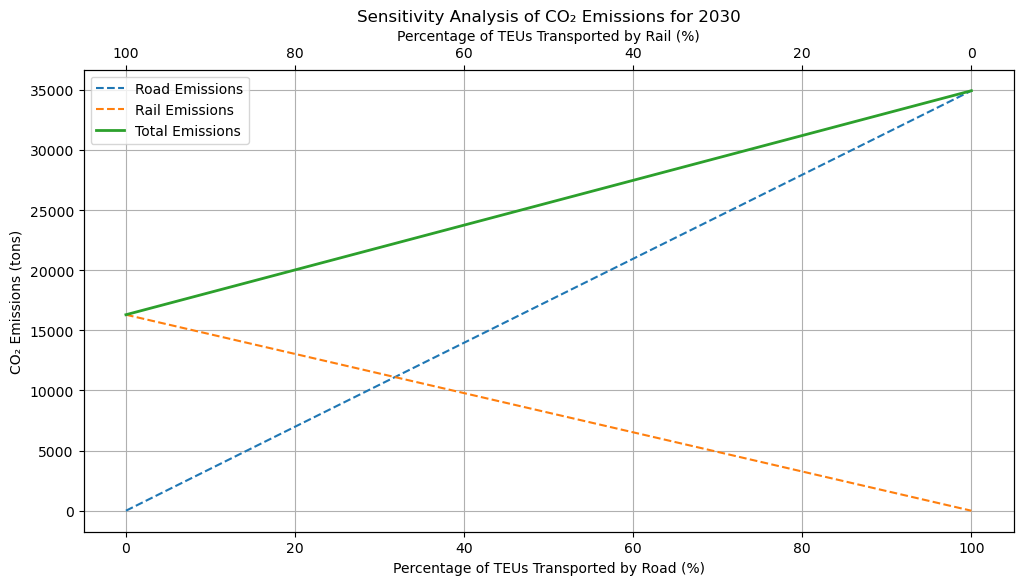

In [33]:
percentages = np.arange(0, 101, 1)

results = []
for road_percentage in percentages:
    rail_percentage = 100 - road_percentage
    teus_road = (road_percentage / 100) * total_teus_mean_28
    teus_rail = (rail_percentage / 100) * total_teus_mean_28
    emissions_road = teus_road * emission_factor_road_diesel
    emissions_rail = teus_rail * emission_factor_rail
    total_emissions = emissions_road + emissions_rail
    results.append([road_percentage, rail_percentage, emissions_road, emissions_rail, total_emissions])

# Criar um DataFrame para armazenar os resultados
df_results = pd.DataFrame(results, columns=["% Road", "% Rail", "Emissions Road (tons)", "Emissions Rail (tons)", "Total Emissions (tons)"])

# Mostrar a tabela de resultados
print(df_results)

# Plotar os resultados
plt.figure(figsize=(12, 6))
plt.plot(df_results["% Road"], df_results["Emissions Road (tons)"], label="Road Emissions", linestyle="--")
plt.plot(df_results["% Road"], df_results["Emissions Rail (tons)"], label="Rail Emissions", linestyle="--")
plt.plot(df_results["% Road"], df_results["Total Emissions (tons)"], label="Total Emissions", linewidth=2)
plt.xlabel("Percentage of TEUs Transported by Road (%)")
plt.ylabel("CO₂ Emissions (tons)")
plt.title("Sensitivity Analysis of CO₂ Emissions for 2030")
plt.legend()
plt.grid(True)

# Criar uma segunda escala para ferrovia
ax1 = plt.gca()  # Pega o eixo principal
ax2 = ax1.twiny()  # Cria um eixo gêmeo no topo

# Definir as escalas do eixo superior (ferrovia)
ax2.set_xlim(ax1.get_xlim())  # Alinha os limites do eixo superior ao eixo inferior
ax2.set_xticks(df_results["% Road"][::20])  # Seleciona menos pontos para evitar sobreposição
ax2.set_xticklabels(100 - df_results["% Road"][::20])  # Usa os valores complementares para o eixo superior

# Adicionar rótulo ao eixo superior
ax2.set_xlabel("Percentage of TEUs Transported by Rail (%)")

# Mostrar o gráfico
plt.show()

0      16301.600
1      16487.904
2      16674.208
3      16860.512
4      17046.816
         ...    
96     34186.784
97     34373.088
98     34559.392
99     34745.696
100    34932.000
Name: Total Emissions Mean, Length: 101, dtype: float64


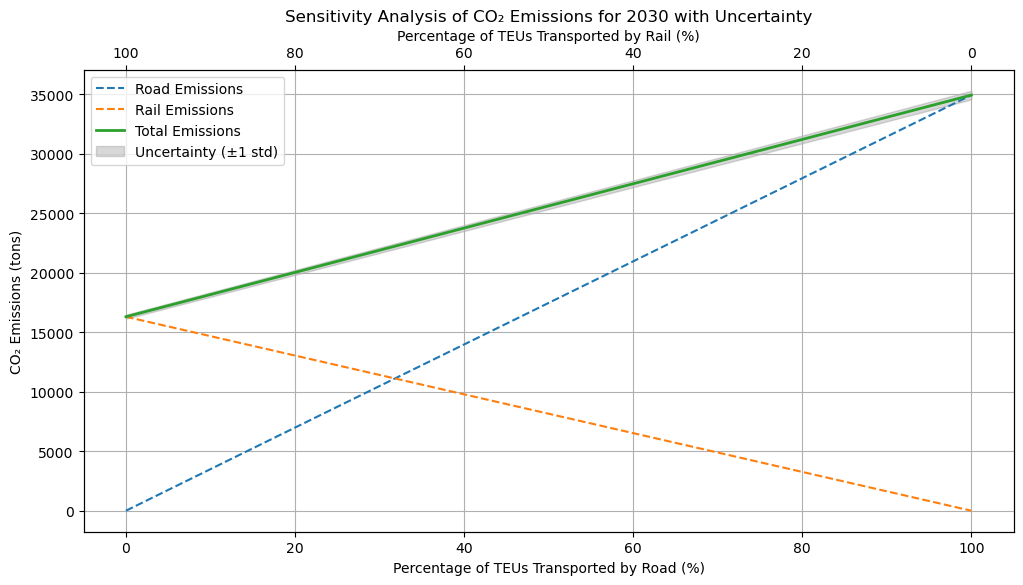

In [34]:
# Porcentagens de transporte
percentages = np.arange(0, 101, 1)

# Listas para armazenar resultados
sensitivity_results = []

for road_percentage in percentages:
    rail_percentage = 100 - road_percentage
    
    # TEUs médios
    teus_road_mean = (road_percentage / 100) * total_teus_mean_28
    teus_rail_mean = (rail_percentage / 100) * total_teus_mean_28
    
    # TEUs para os desvios padrão
    teus_road_std = (road_percentage / 100) * total_teus_std_28
    teus_rail_std = (rail_percentage / 100) * total_teus_std_28
    
    # Emissões médias
    emissions_road_mean = teus_road_mean * emission_factor_road_diesel
    emissions_rail_mean = teus_rail_mean * emission_factor_rail
    total_emissions_mean = emissions_road_mean + emissions_rail_mean
    
    # Emissões com incerteza (mínima e máxima)
    emissions_road_min = (teus_road_mean - teus_road_std) * emission_factor_road_diesel
    emissions_road_max = (teus_road_mean + teus_road_std) * emission_factor_road_diesel
    
    emissions_rail_min = (teus_rail_mean - teus_rail_std) * emission_factor_rail
    emissions_rail_max = (teus_rail_mean + teus_rail_std) * emission_factor_rail
    
    total_emissions_min = emissions_road_min + emissions_rail_min
    total_emissions_max = emissions_road_max + emissions_rail_max
    
    sensitivity_results.append({
        "% Road": road_percentage,
        "% Rail": rail_percentage,
        "Road Emissions Mean": emissions_road_mean,
        "Rail Emissions Mean": emissions_rail_mean,
        "Total Emissions Mean": total_emissions_mean,
        "Total Emissions Min": total_emissions_min,
        "Total Emissions Max": total_emissions_max
    })

# Converter os resultados para um DataFrame
df_sensitivity = pd.DataFrame(sensitivity_results)

# Print valores total emissões
print(df_sensitivity["Total Emissions Mean"])

# Plotar os resultados
plt.figure(figsize=(12, 6))

# Plotar a linha média das emissões
plt.plot(df_sensitivity["% Road"], df_sensitivity["Road Emissions Mean"], label="Road Emissions", linestyle="--")
plt.plot(df_sensitivity["% Road"], df_sensitivity["Rail Emissions Mean"], label="Rail Emissions", linestyle="--")
plt.plot(df_sensitivity["% Road"], df_sensitivity["Total Emissions Mean"], label="Total Emissions", linewidth=2)

# Adicionar áreas de incerteza (faixas)
plt.fill_between(df_sensitivity["% Road"], 
                 df_sensitivity["Total Emissions Min"], 
                 df_sensitivity["Total Emissions Max"], 
                 color="gray", alpha=0.3, label="Uncertainty (±1 std)")

# Configurações do gráfico
plt.xlabel("Percentage of TEUs Transported by Road (%)")
plt.ylabel("CO₂ Emissions (tons)")
plt.title("Sensitivity Analysis of CO₂ Emissions for 2030 with Uncertainty")
plt.legend()
plt.grid(True)

# Criar uma segunda escala para ferrovia
ax1 = plt.gca()  # Pega o eixo principal
ax2 = ax1.twiny()  # Cria um eixo gêmeo no topo

# Definir as escalas do eixo superior (ferrovia)
ax2.set_xlim(ax1.get_xlim())  # Alinha os limites do eixo superior ao eixo inferior
ax2.set_xticks(df_results["% Road"][::20])  # Seleciona menos pontos para evitar sobreposição
ax2.set_xticklabels(100 - df_results["% Road"][::20])  # Usa os valores complementares para o eixo superior

# Adicionar rótulo ao eixo superior
ax2.set_xlabel("Percentage of TEUs Transported by Rail (%)")

# Mostrar o gráfico
plt.show()

## Sensitivity analysis para o crescimento de 2.8% mas com parte da frota rodoviária movida a combustíveis sustentáveis

0      16301.60000
1      16481.61624
2      16661.63248
3      16841.64872
4      17021.66496
          ...     
96     33583.15904
97     33763.17528
98     33943.19152
99     34123.20776
100    34303.22400
Name: Total Emissions Mean, Length: 101, dtype: float64


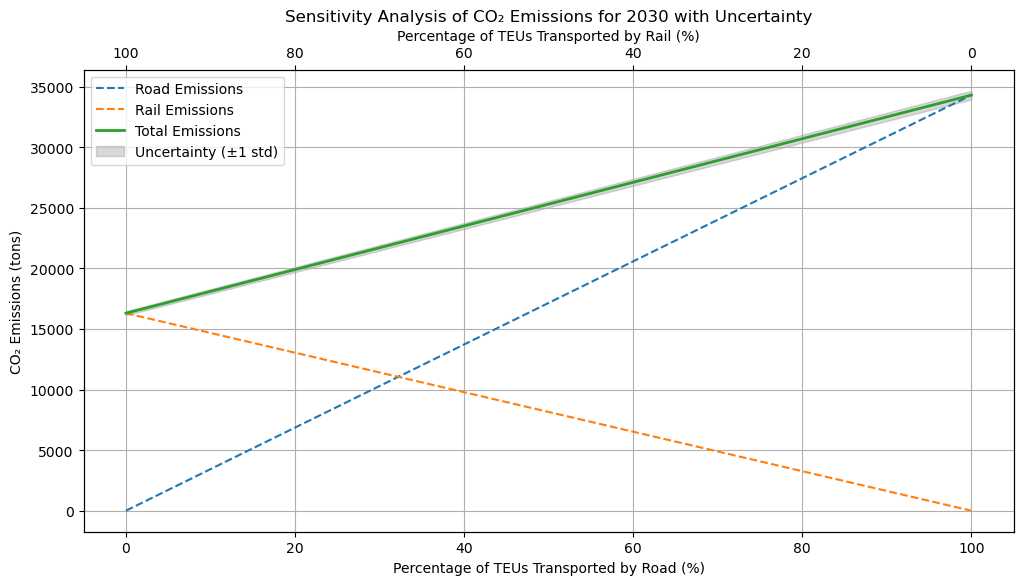

In [35]:
# Percentagens de transporte
percentages = np.arange(0, 101, 1)

# Listas para armazenar resultados
sensitivity_results = []

for road_percentage in percentages:
    rail_percentage = 100 - road_percentage
    
    # TEUs médios
    teus_road_mean = (road_percentage / 100) * total_teus_mean_28
    teus_rail_mean = (rail_percentage / 100) * total_teus_mean_28
    
    # TEUs para os desvios padrão
    teus_road_std = (road_percentage / 100) * total_teus_std_28
    teus_rail_std = (rail_percentage / 100) * total_teus_std_28
    
    # Emissões médias
    emissions_road_mean = (
        0.81 * teus_road_mean * emission_factor_road_diesel +
        0.05 * teus_road_mean * emission_factor_road_bev +
        0.08 * teus_road_mean * emission_factor_lng +
        0.06 * teus_road_mean * emission_factor_fcev
    )  
    emissions_rail_mean = teus_rail_mean * emission_factor_rail
    total_emissions_mean = emissions_road_mean + emissions_rail_mean
    
    # Emissões com incerteza (mínima e máxima)
    emissions_road_min = (
        0.81 * (teus_road_mean - teus_road_std) * emission_factor_road_diesel +
        0.05 * (teus_road_mean - teus_road_std) * emission_factor_road_bev +
        0.08 * (teus_road_mean - teus_road_std) * emission_factor_lng +
        0.06 * (teus_road_mean - teus_road_std) * emission_factor_fcev
    )
    emissions_road_max = (
        0.81 * (teus_road_mean + teus_road_std) * emission_factor_road_diesel +
        0.05 * (teus_road_mean + teus_road_std) * emission_factor_road_bev +
        0.08 * (teus_road_mean + teus_road_std) * emission_factor_lng +
        0.06 * (teus_road_mean + teus_road_std) * emission_factor_fcev
    )    
    emissions_rail_min = (teus_rail_mean - teus_rail_std) * emission_factor_rail
    emissions_rail_max = (teus_rail_mean + teus_rail_std) * emission_factor_rail
    
    total_emissions_min = emissions_road_min + emissions_rail_min
    total_emissions_max = emissions_road_max + emissions_rail_max
    
    sensitivity_results.append({
        "% Road": road_percentage,
        "% Rail": rail_percentage,
        "Road Emissions Mean": emissions_road_mean,
        "Rail Emissions Mean": emissions_rail_mean,
        "Total Emissions Mean": total_emissions_mean,
        "Total Emissions Min": total_emissions_min,
        "Total Emissions Max": total_emissions_max
    })

# Converter os resultados para um DataFrame
df_sensitivity = pd.DataFrame(sensitivity_results)

# Print valores total emissões
print(df_sensitivity["Total Emissions Mean"])

# Plotar os resultados
plt.figure(figsize=(12, 6))

# Plotar a linha média das emissões
plt.plot(df_sensitivity["% Road"], df_sensitivity["Road Emissions Mean"], label="Road Emissions", linestyle="--")
plt.plot(df_sensitivity["% Road"], df_sensitivity["Rail Emissions Mean"], label="Rail Emissions", linestyle="--")
plt.plot(df_sensitivity["% Road"], df_sensitivity["Total Emissions Mean"], label="Total Emissions", linewidth=2)

# Adicionar áreas de incerteza (faixas)
plt.fill_between(df_sensitivity["% Road"], 
                 df_sensitivity["Total Emissions Min"], 
                 df_sensitivity["Total Emissions Max"], 
                 color="gray", alpha=0.3, label="Uncertainty (±1 std)")

# Configurações do gráfico
plt.xlabel("Percentage of TEUs Transported by Road (%)")
plt.ylabel("CO₂ Emissions (tons)")
plt.title("Sensitivity Analysis of CO₂ Emissions for 2030 with Uncertainty")
plt.legend()
plt.grid(True)

# Criar uma segunda escala para ferrovia
ax1 = plt.gca()  # Pega o eixo principal
ax2 = ax1.twiny()  # Cria um eixo gêmeo no topo

# Definir as escalas do eixo superior (ferrovia)
ax2.set_xlim(ax1.get_xlim())  # Alinha os limites do eixo superior ao eixo inferior
ax2.set_xticks(df_sensitivity["% Road"][::20])  # Seleciona menos pontos para evitar sobreposição
ax2.set_xticklabels(100 - df_sensitivity["% Road"][::20])  # Usa os valores complementares para o eixo superior

# Adicionar rótulo ao eixo superior
ax2.set_xlabel("Percentage of TEUs Transported by Rail (%)")

# Mostrar o gráfico
plt.show()

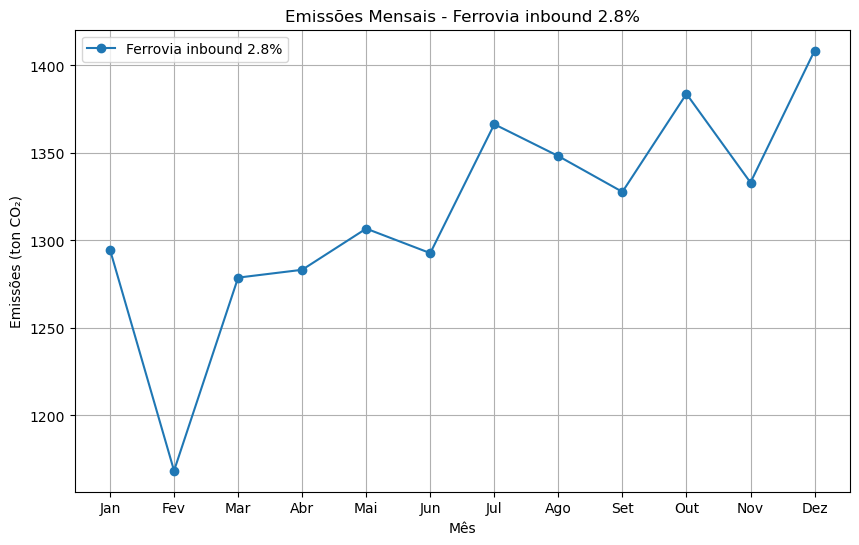

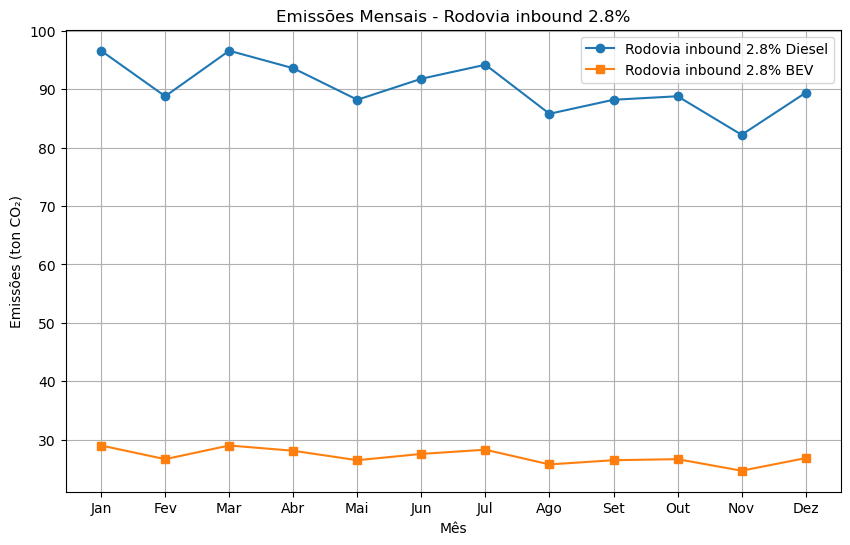

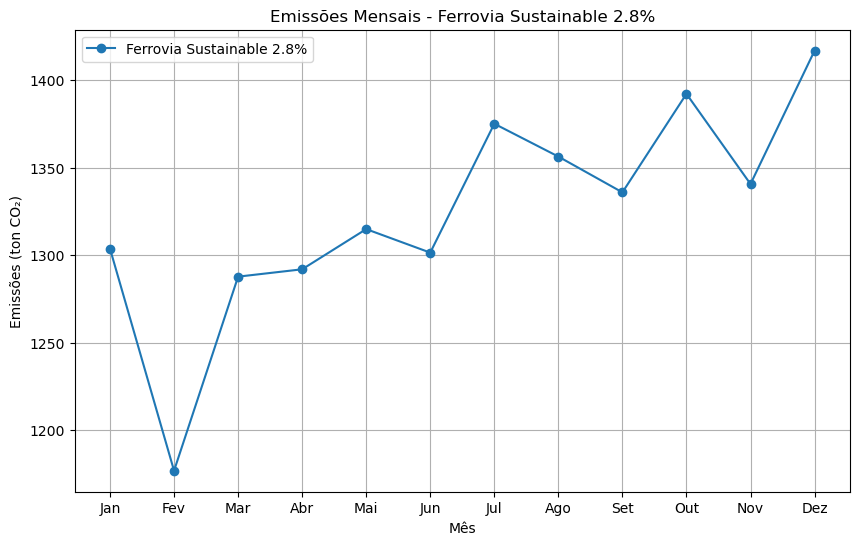

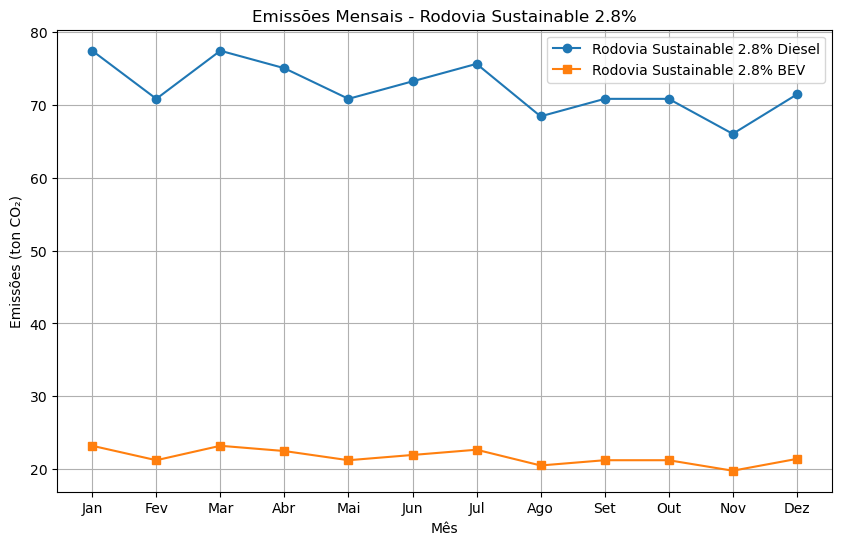

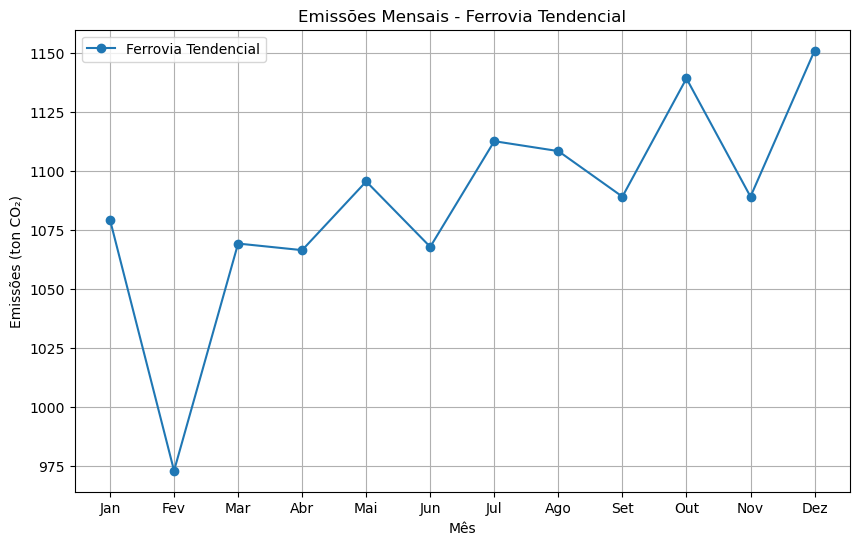

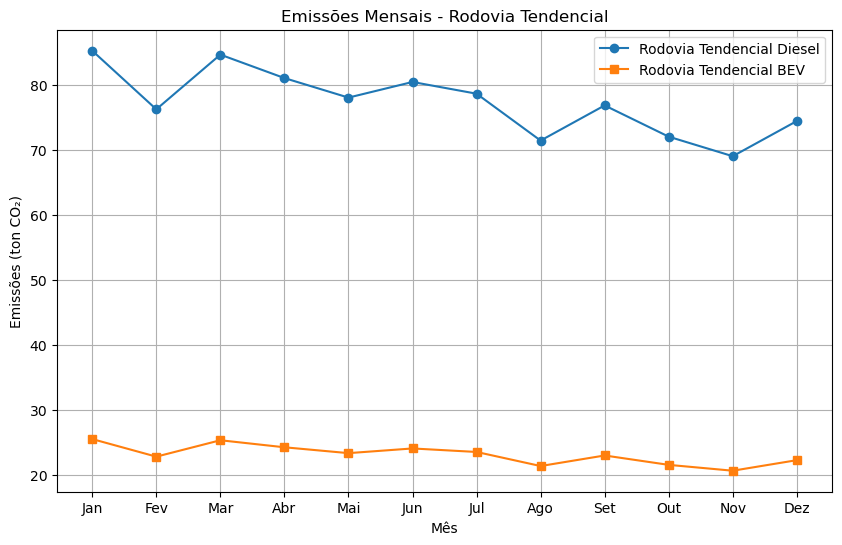

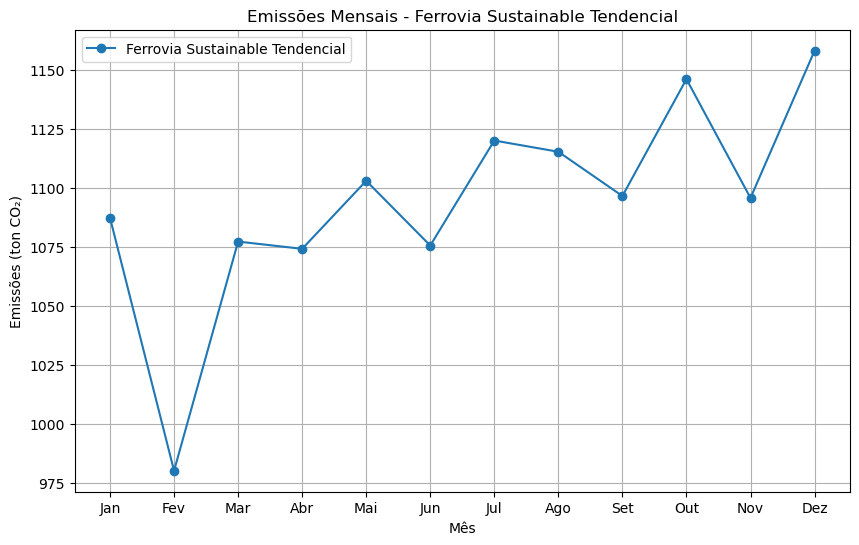

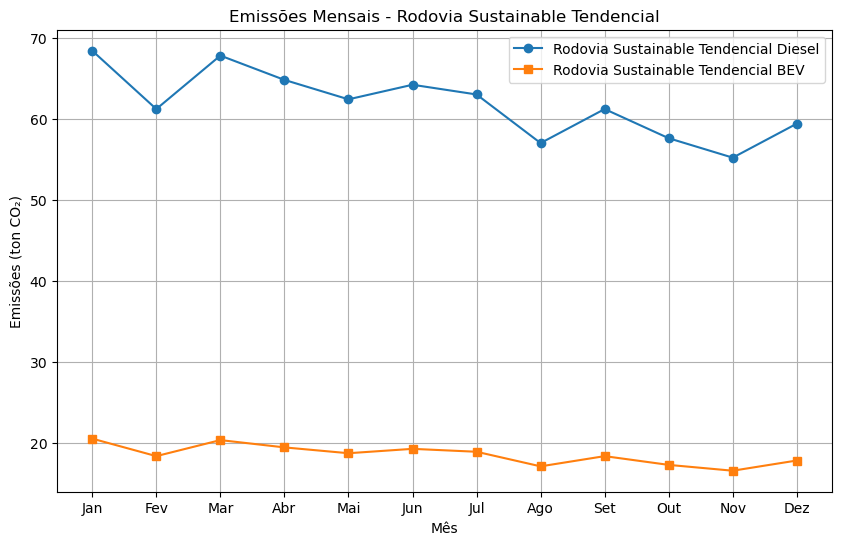

In [36]:
# Definir os nomes dos meses para o eixo x
meses = ["Jan", "Fev", "Mar", "Abr", "Mai", "Jun", "Jul", "Ago", "Set", "Out", "Nov", "Dez"]

# Cálculo das emissões para cada mês
rail_inbound_28_emissions = [teu * emission_factor_rail for teu in rail_inbound_28]
road_inbound_28_emissions_diesel = [teu * emission_factor_road_diesel for teu in road_inbound_28]
road_inbound_28_emissions_bev = [teu * emission_factor_road_bev for teu in road_inbound_28]

# Plotar cenários inbound 2.8%
plt.figure(figsize=(10,6))
plt.plot(meses, rail_inbound_28_emissions, marker='o', label='Ferrovia inbound 2.8%')
plt.title("Emissões Mensais - Ferrovia inbound 2.8%")
plt.xlabel("Mês")
plt.ylabel("Emissões (ton CO₂)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10,6))
plt.plot(meses, road_inbound_28_emissions_diesel, marker='o', label='Rodovia inbound 2.8% Diesel')
plt.plot(meses, road_inbound_28_emissions_bev, marker='s', label='Rodovia inbound 2.8% BEV')
plt.title("Emissões Mensais - Rodovia inbound 2.8%")
plt.xlabel("Mês")
plt.ylabel("Emissões (ton CO₂)")
plt.legend()
plt.grid(True)
plt.show()

# Cenário: inbound Sustainable 2.8%

rail_inbound_sustainable_28_emissions = [teu * emission_factor_rail for teu in rail_inbound_sustainable_28]
road_inbound_sustainable_28_emissions_diesel = [teu * emission_factor_road_diesel for teu in road_inbound_sustainable_28]
road_inbound_sustainable_28_emissions_bev = [teu * emission_factor_road_bev for teu in road_inbound_sustainable_28]

plt.figure(figsize=(10,6))
plt.plot(meses, rail_inbound_sustainable_28_emissions, marker='o', label='Ferrovia Sustainable 2.8%')
plt.title("Emissões Mensais - Ferrovia Sustainable 2.8%")
plt.xlabel("Mês")
plt.ylabel("Emissões (ton CO₂)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10,6))
plt.plot(meses, road_inbound_sustainable_28_emissions_diesel, marker='o', label='Rodovia Sustainable 2.8% Diesel')
plt.plot(meses, road_inbound_sustainable_28_emissions_bev, marker='s', label='Rodovia Sustainable 2.8% BEV')
plt.title("Emissões Mensais - Rodovia Sustainable 2.8%")
plt.xlabel("Mês")
plt.ylabel("Emissões (ton CO₂)")
plt.legend()
plt.grid(True)
plt.show()

# Cenário: inbound Tendencial

rail_inbound_tendencial_emissions = [teu * emission_factor_rail for teu in rail_inbound_tendencial]
road_inbound_tendencial_emissions_diesel = [teu * emission_factor_road_diesel for teu in road_inbound_tendencial]
road_inbound_tendencial_emissions_bev = [teu * emission_factor_road_bev for teu in road_inbound_tendencial]

plt.figure(figsize=(10,6))
plt.plot(meses, rail_inbound_tendencial_emissions, marker='o', label='Ferrovia Tendencial')
plt.title("Emissões Mensais - Ferrovia Tendencial")
plt.xlabel("Mês")
plt.ylabel("Emissões (ton CO₂)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10,6))
plt.plot(meses, road_inbound_tendencial_emissions_diesel, marker='o', label='Rodovia Tendencial Diesel')
plt.plot(meses, road_inbound_tendencial_emissions_bev, marker='s', label='Rodovia Tendencial BEV')
plt.title("Emissões Mensais - Rodovia Tendencial")
plt.xlabel("Mês")
plt.ylabel("Emissões (ton CO₂)")
plt.legend()
plt.grid(True)
plt.show()

# Cenário: inbound Sustainable Tendencial

rail_inbound_sustainable_tendencial_emissions = [teu * emission_factor_rail for teu in rail_inbound_sustainable_tendencial]
road_inbound_sustainable_tendencial_emissions_diesel = [teu * emission_factor_road_diesel for teu in road_inbound_sustainable_tendencial]
road_inbound_sustainable_tendencial_emissions_bev = [teu * emission_factor_road_bev for teu in road_inbound_sustainable_tendencial]

plt.figure(figsize=(10,6))
plt.plot(meses, rail_inbound_sustainable_tendencial_emissions, marker='o', label='Ferrovia Sustainable Tendencial')
plt.title("Emissões Mensais - Ferrovia Sustainable Tendencial")
plt.xlabel("Mês")
plt.ylabel("Emissões (ton CO₂)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10,6))
plt.plot(meses, road_inbound_sustainable_tendencial_emissions_diesel, marker='o', label='Rodovia Sustainable Tendencial Diesel')
plt.plot(meses, road_inbound_sustainable_tendencial_emissions_bev, marker='s', label='Rodovia Sustainable Tendencial BEV')
plt.title("Emissões Mensais - Rodovia Sustainable Tendencial")
plt.xlabel("Mês")
plt.ylabel("Emissões (ton CO₂)")
plt.legend()
plt.grid(True)
plt.show()

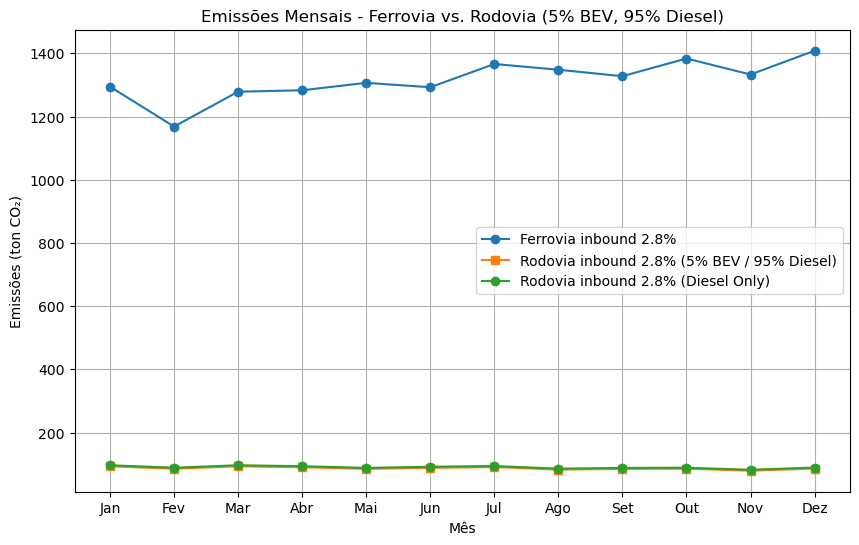

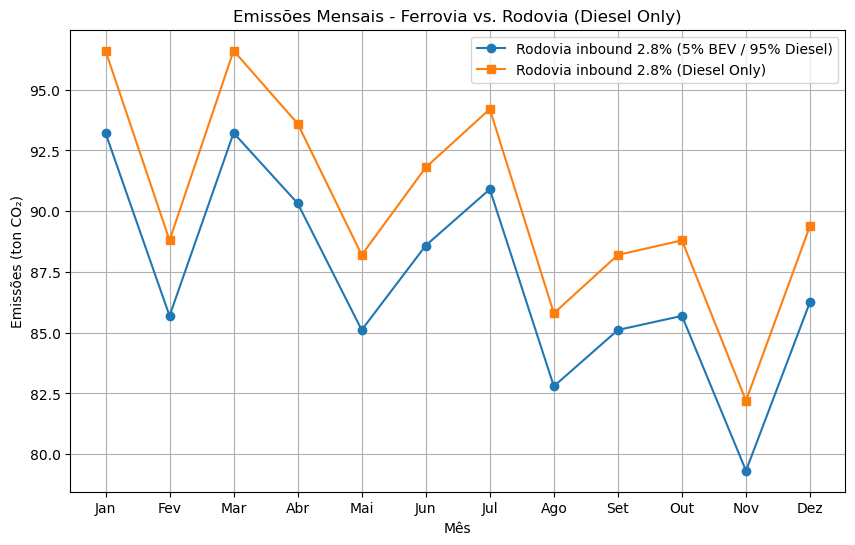

Emissões Rodoviárias (Diesel)
[96.6, 88.8, 96.6, 93.6, 88.2, 91.8, 94.2, 85.8, 88.2, 88.8, 82.2, 89.39999999999999]
Emissões Rodoviárias (5% BEV / 95% Diesel)
[93.219, 85.692, 93.219, 90.324, 85.113, 88.58699999999999, 90.90299999999999, 82.797, 85.113, 85.692, 79.323, 86.271]


In [37]:
# Para o cenário misto (5% BEV e 95% Diesel) usamos um fator ponderado:
weighted_factor = 0.05 * emission_factor_road_bev + 0.95 * emission_factor_road_diesel
road_inbound_28_emissions_mixture = [teu * weighted_factor for teu in road_inbound_28]

plt.figure(figsize=(10,6))
plt.plot(meses, rail_inbound_28_emissions, marker='o', label='Ferrovia inbound 2.8%')
plt.plot(meses, road_inbound_28_emissions_mixture, marker='s', label='Rodovia inbound 2.8% (5% BEV / 95% Diesel)')
plt.plot(meses, road_inbound_28_emissions_diesel, marker='o', label='Rodovia inbound 2.8% (Diesel Only)')
plt.title("Emissões Mensais - Ferrovia vs. Rodovia (5% BEV, 95% Diesel)")
plt.xlabel("Mês")
plt.ylabel("Emissões (ton CO₂)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10,6))
plt.plot(meses, road_inbound_28_emissions_mixture, marker='o', label='Rodovia inbound 2.8% (5% BEV / 95% Diesel)')
plt.plot(meses, road_inbound_28_emissions_diesel, marker='s', label='Rodovia inbound 2.8% (Diesel Only)')
plt.title("Emissões Mensais - Ferrovia vs. Rodovia (Diesel Only)")
plt.xlabel("Mês")
plt.ylabel("Emissões (ton CO₂)")
plt.legend()
plt.grid(True)
plt.show()

print("Emissões Rodoviárias (Diesel)")
print(road_inbound_28_emissions_diesel)
print("Emissões Rodoviárias (5% BEV / 95% Diesel)")
print(road_inbound_28_emissions_mixture)

In [38]:
total_diesel = sum(road_inbound_28_emissions_diesel)
total_mixed = sum(road_inbound_28_emissions_mixture)

ganho_percentual = ((total_diesel - total_mixed) / total_diesel) * 100

print(f"Emissões totais (diesel): {total_diesel:.2f} ton CO2")
print(f"Emissões totais (misto): {total_mixed:.2f} ton CO2")
print(f"Ganho (redução) percentual: {ganho_percentual:.2f}%")

Emissões totais (diesel): 1084.20 ton CO2
Emissões totais (misto): 1046.25 ton CO2
Ganho (redução) percentual: 3.50%
